## Image clustering and prediction

This notebook takes as input a set of images of different breeds of dogs. Several versions of images are included and evaluated to get the best result.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from os import listdir
from os.path import isfile, join
from lxml import etree

from PIL import Image
from PIL import ImageOps as IO
import cv2

import scipy.io
from scipy.cluster.vq import vq, kmeans2, whiten

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier


In [4]:
# method to read picture information from a matlab file
def load_img_from_mat(mat_file):

    mat_data = scipy.io.loadmat(mat_file)
    # load annotations for each picture
    dogs_annotation = []
    
    for img_annotation in mat_data['annotation_list']:
        dog_annotation = str(img_annotation[0][0])
        dogs_annotation.append(dog_annotation)

    # load picture filenames and path for each picture contained in mat file
    dogs_full_path = []
    dogs_folder = []
    dogs_file = []

    for img_file in mat_data['file_list']:
        dog_full_path = str(img_file[0][0])
        folder, filen =  dog_full_path.split('/')
        dogs_full_path.append(dog_full_path)
        dogs_folder.append(folder)
        dogs_file.append(filen)

    # Create dataframe with these informations
    file_df = pd.DataFrame({'file' : dogs_file,
                             'folder' : dogs_folder,
                             'full_path' : dogs_full_path,
                             'annotation' : dogs_annotation})
    
    # Load label information and create a complete dataframe
    labels_df = pd.DataFrame(mat_data['labels'], columns = ['label'])
    file_df = file_df.join(labels_df)
    
    return file_df

In [5]:
# method to read a file picture
def load_img(variant, img_folder, img_file):
    picture_file = join(variant, img_folder, img_file)
    img = Image.open(picture_file)
    img_sift = np.array(img)
    return img_sift

In [6]:
# Extract SIFT features from a dataframe of pictures
# Passed dataframe must have 'folder' and 'file columns'
def sift_extract(variants, pict_df):
    start_time = time.time()
    lap_time = start_time
    
    # Variable to hold all descriptors
    descriptors_list = []
    
    # Variable to hold for each picture the number of descriptors
    descriptors_number = []
    img_index = 0

    sift = cv2.xfeatures2d.SIFT_create()

    for dog_folder, dog_file in np.array(pict_df[['folder', 'file']]):
        img_descriptors_number = 0
        # There may be several variants of an image, depending of the chosen pre-processing
        for variant in variants:
            gray_img = load_img(variant, dog_folder, dog_file)
            if np.count_nonzero(gray_img)/(gray_img.size*1.0) > 0.3:

                # Get SIFT keypoints and descriptors for each image
                keypoints, descriptors = sift.detectAndCompute(gray_img, None)

                # Compute the number of descriptors for this image
                img_descriptors_number += len(descriptors)
                # Add this image descriptors to the list
                for descriptor in descriptors:
                    descriptors_list.append(descriptor)
                img_index += 1

        # Total number of decriptors for all variants of this image
        descriptors_number.append(img_descriptors_number)
        img_descriptors_number = 0
        
        if (img_index % 500) == 0:
                print("{0} images processed in {1} seconds per batch of 500".format(img_index, time.time() - lap_time))
                lap_time = time.time()

    end_time = time.time()
    print("temps de traitement SIFT features: %15.2f secondes" % (end_time - start_time))
    
    return descriptors_number, descriptors_list

In [7]:
def build_histograms(descriptors_number, descriptors_list, centroids):
    """Build matrix of histograms.
    Each line is a picture, each columns is a cluster ID
    Values are the number of times a picture belongs to a cluster, 
    i.e. a visual word, divided by the number of pictures for this image"""
    
    desc_idx = 0
    im_histos = np.zeros((len(descriptors_number), len(centroids)), "float64")
    
    for img_idx in range(len(descriptors_number)):
        # Get array of descriptors for this image
        img_desc_nb = descriptors_number[img_idx]
        my_descriptors = descriptors_list[desc_idx: img_desc_nb + desc_idx]
        
        # Find the nearest centroid for each descriptor
        cvect, dist = vq(my_descriptors, centroids)
        for c in cvect:
            im_histos[img_idx][c] += 1.0/img_desc_nb
        desc_idx = img_desc_nb + desc_idx
    return im_histos

In [92]:
def get_decriptors_train(sample_train_df, variants):

    print 'Number of pictures of train data:', len(sample_train_df)

    # Extract SIFT Features from train Data and create histograms
    train_descriptors_number, train_descriptors_list = sift_extract(variants, sample_train_df)

    print 'Number of SIFT descriptors for train data:', len(train_descriptors_list)
    print("Maximum number of descriptors for one picture {0}".format(np.max(train_descriptors_number)))
    print("Minimum number of descriptors for one picture {0}".format(np.min(train_descriptors_number)))
    
    return train_descriptors_number, train_descriptors_list

In [93]:
def get_decriptors_test(sample_test_df, variants):

    print 'Number of pictures of test data:', len(sample_test_df)

    test_descriptors_number, test_descriptors_list = sift_extract(variants, sample_test_df)

    print 'Number of SIFT descriptors for test data:', len(test_descriptors_list)

    return test_descriptors_number, test_descriptors_list

In [24]:
def eval_score(n_clusters):
    # Do a clustering of the feature descriptors
    train_centroids, train_clusters = kmeans2(whiten(train_descriptors_list), n_clusters)

    train_histos = build_histograms(train_descriptors_number, train_descriptors_list, train_centroids)

    test_histos = build_histograms(test_descriptors_number, test_descriptors_list, train_centroids)

    # Define X array and Y vector for the supervised classification
    X = train_histos
    Y = sample_train_df['label']

    # Fit a Random Forest
    rdc = RidgeClassifier()
    rdc.fit(X, Y)

    score = rdc.score(test_histos,sample_test_df['label'])
    
    print("Score for {0} clusters : {1:.2%}".format(n_clusters, score))
    
    return score

In [111]:
def plot_histogram(n_clusters):
    # Do a clustering of the feature descriptors
    train_centroids, train_clusters = kmeans2(whiten(train_descriptors_list), n_clusters)

    train_histos = build_histograms(train_descriptors_number, train_descriptors_list, train_centroids)
    
    plt.figure(figsize=(10,10))
    y = train_histos[1]
    N = len(y)
    x = range(N)
    width = 1/1.5
    plt.bar(x, y, width, color="blue")
    plt.title('Usage of visual words for one picture')

    plt.show()

### Main execution 

In [2]:
# Define data directories
my_data = "../data"
annotations = my_data + '/Annotation'        # BO file to be merged with additional information
images = my_data + '/Images' # SAP file with order fulfilment dates
cropped = my_data + '/Cropped'
grabcut = my_data + '/Grabcut'
bw = my_data + '/BWEqu'

Load image metadata from Matlab file

In [88]:
# Load train data
train_df = load_img_from_mat(my_data + '/train_list.mat')

# Load test data
test_df = load_img_from_mat(my_data + '/test_list.mat')

### Parameters

The available dataset are pictures of 120 breeds of dogs. The available memory and processing power sets some limitations. also, the SIFT algorithm is not powerful enough to reach a good accuracy with many breeds. This will be evaluated later.

In [123]:
# Parameters

# Number of dogs breeds to include
nb_breeds = 10

# Number of clusters for the kMeans clustering of image descriptors
n_clusters = 250

In [124]:
sample_train_df = train_df[train_df['label'] <= nb_breeds]
sample_test_df = test_df[test_df['label'] <= nb_breeds]
train_descriptors_number, train_descriptors_list = get_decriptors_train(sample_train_df, [cropped, grabcut])
test_descriptors_number, test_descriptors_list = get_decriptors_test(sample_test_df, [bw])
score = eval_score(n_clusters)


Number of pictures of train data: 1000
500 images processed in 28.3079998493 seconds per batch of 500
1000 images processed in 29.5240001678 seconds per batch of 500
1500 images processed in 33.875 seconds per batch of 500
temps de traitement SIFT features:          124.54 secondes
Number of SIFT descriptors for train data: 1181116
Maximum number of descriptors for one picture 9096
Minimum number of descriptors for one picture 25
Number of pictures of test data: 919
500 images processed in 76.3989999294 seconds per batch of 500
temps de traitement SIFT features:          142.33 secondes
Number of SIFT descriptors for test data: 1359395
Score for 250 clusters : 17.19%


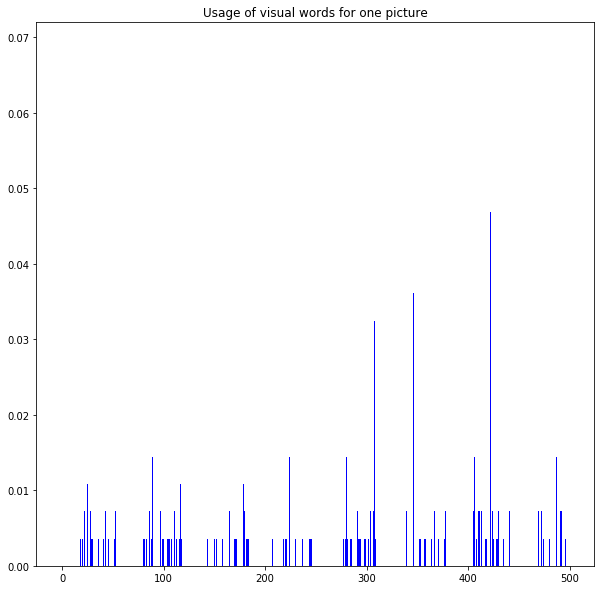

In [112]:
plot_histogram(n_clusters)

In [30]:
# Compare breeds 2 by 2 to find which ones can be separated most and least easily 
score_table = np.zeros((120,120), np.float64)
n_clusters = 100

for i in range(1,120):
    for j in range (i+1,120):

        train_filter = (train_df['label'] == i) | (train_df['label'] == j)
        sample_train_df = train_df[train_filter]

        train_descriptors_number, train_descriptors_list = get_decriptors_train(sample_train_df, [cropped])

        test_filter = (test_df['label'] == i) | (test_df['label'] == j)
        sample_test_df = test_df[test_filter]

        test_descriptors_number, test_descriptors_list = get_decriptors_test(sample_test_df, [cropped])

        score_table[i,j] = eval_score(n_clusters)

Number of pictures of train data: 200
temps de traitement SIFT features:           10.58 secondes
Number of SIFT descriptors for train data: 129214
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 137
temps de traitement SIFT features:            8.54 secondes
Number of SIFT descriptors for test data: 106409
Score for 100 clusters : 74.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.11 secondes
Number of SIFT descriptors for train data: 121103
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 204
temps de traitement SIFT features:           12.92 secondes
Number of SIFT descriptors for test data: 156561
Score for 100 clusters : 80.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.70 secondes
Number of SIFT descriptors for train data: 133357


temps de traitement SIFT features:            9.24 secondes
Number of SIFT descriptors for test data: 113779
Score for 100 clusters : 58.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.32 secondes
Number of SIFT descriptors for train data: 148526
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 139
temps de traitement SIFT features:            9.61 secondes
Number of SIFT descriptors for test data: 124984
Score for 100 clusters : 67.63%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.22 secondes
Number of SIFT descriptors for train data: 159270
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 140
temps de traitement SIFT features:           11.75 secondes
Number of SIFT descriptors for test data: 134076
Score for 100 clusters : 61.43%
Number 

Score for 100 clusters : 68.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.47 secondes
Number of SIFT descriptors for train data: 159814
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 154
temps de traitement SIFT features:           12.10 secondes
Number of SIFT descriptors for test data: 151421
Score for 100 clusters : 72.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.47 secondes
Number of SIFT descriptors for train data: 156660
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 149
temps de traitement SIFT features:           11.73 secondes
Number of SIFT descriptors for test data: 142591
Score for 100 clusters : 79.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.60 secondes
Number of SIFT des

temps de traitement SIFT features:            8.91 secondes
Number of SIFT descriptors for test data: 119123
Score for 100 clusters : 71.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.81 secondes
Number of SIFT descriptors for train data: 137239
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 106
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 101501
Score for 100 clusters : 69.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.77 secondes
Number of SIFT descriptors for train data: 164629
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 25
Number of pictures of test data: 113
temps de traitement SIFT features:            8.82 secondes
Number of SIFT descriptors for test data: 108730
Score for 100 clusters : 61.95%
Number 

Score for 100 clusters : 75.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.81 secondes
Number of SIFT descriptors for train data: 127979
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 109
temps de traitement SIFT features:            8.24 secondes
Number of SIFT descriptors for test data: 99848
Score for 100 clusters : 67.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.51 secondes
Number of SIFT descriptors for train data: 136867
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 105
temps de traitement SIFT features:            7.77 secondes
Number of SIFT descriptors for test data: 92994
Score for 100 clusters : 71.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT descr

temps de traitement SIFT features:            8.97 secondes
Number of SIFT descriptors for test data: 105876
Score for 100 clusters : 64.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.05 secondes
Number of SIFT descriptors for train data: 131457
Maximum number of descriptors for one picture 4159
Minimum number of descriptors for one picture 25
Number of pictures of test data: 144
temps de traitement SIFT features:            9.87 secondes
Number of SIFT descriptors for test data: 116262
Score for 100 clusters : 52.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.92 secondes
Number of SIFT descriptors for train data: 153348
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 25
Number of pictures of test data: 102
temps de traitement SIFT features:            8.19 secondes
Number of SIFT descriptors for test data: 105454
Score for 100 clusters : 75.49%
Number 

Score for 100 clusters : 64.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.02 secondes
Number of SIFT descriptors for train data: 189549
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 25
Number of pictures of test data: 102
temps de traitement SIFT features:            7.23 secondes
Number of SIFT descriptors for test data: 92248
Score for 100 clusters : 76.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.48 secondes
Number of SIFT descriptors for train data: 117113
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 70
Number of pictures of test data: 237
temps de traitement SIFT features:           12.91 secondes
Number of SIFT descriptors for test data: 151638
Score for 100 clusters : 71.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.92 secondes
Number of SIFT des

temps de traitement SIFT features:            8.46 secondes
Number of SIFT descriptors for test data: 108856
Score for 100 clusters : 77.84%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.19 secondes
Number of SIFT descriptors for train data: 144536
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 57
Number of pictures of test data: 172
temps de traitement SIFT features:            8.95 secondes
Number of SIFT descriptors for test data: 120061
Score for 100 clusters : 80.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.74 secondes
Number of SIFT descriptors for train data: 155280
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 70
Number of pictures of test data: 173
temps de traitement SIFT features:            9.71 secondes
Number of SIFT descriptors for test data: 129153
Score for 100 clusters : 77.46%
Number 

Score for 100 clusters : 64.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.31 secondes
Number of SIFT descriptors for train data: 155824
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 70
Number of pictures of test data: 187
temps de traitement SIFT features:           11.17 secondes
Number of SIFT descriptors for test data: 146498
Score for 100 clusters : 77.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.15 secondes
Number of SIFT descriptors for train data: 152670
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 182
temps de traitement SIFT features:           10.79 secondes
Number of SIFT descriptors for test data: 137668
Score for 100 clusters : 75.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.37 secondes
Number of SIFT des

temps de traitement SIFT features:            8.43 secondes
Number of SIFT descriptors for test data: 114200
Score for 100 clusters : 81.02%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.54 secondes
Number of SIFT descriptors for train data: 133249
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 69
Number of pictures of test data: 139
temps de traitement SIFT features:            7.42 secondes
Number of SIFT descriptors for test data: 96578
Score for 100 clusters : 81.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.40 secondes
Number of SIFT descriptors for train data: 160639
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 146
temps de traitement SIFT features:            8.28 secondes
Number of SIFT descriptors for test data: 103807
Score for 100 clusters : 68.49%
Number o

Score for 100 clusters : 72.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.54 secondes
Number of SIFT descriptors for train data: 123989
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 70
Number of pictures of test data: 142
temps de traitement SIFT features:            7.78 secondes
Number of SIFT descriptors for test data: 94925
Score for 100 clusters : 62.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.11 secondes
Number of SIFT descriptors for train data: 132877
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 70
Number of pictures of test data: 138
temps de traitement SIFT features:            7.29 secondes
Number of SIFT descriptors for test data: 88071
Score for 100 clusters : 68.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.80 secondes
Number of SIFT descr

temps de traitement SIFT features:            8.13 secondes
Number of SIFT descriptors for test data: 100953
Score for 100 clusters : 65.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.45 secondes
Number of SIFT descriptors for train data: 127467
Maximum number of descriptors for one picture 3081
Minimum number of descriptors for one picture 62
Number of pictures of test data: 177
temps de traitement SIFT features:            8.94 secondes
Number of SIFT descriptors for test data: 111339
Score for 100 clusters : 75.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.22 secondes
Number of SIFT descriptors for train data: 149358
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 70
Number of pictures of test data: 135
temps de traitement SIFT features:            7.48 secondes
Number of SIFT descriptors for test data: 100531
Score for 100 clusters : 80.74%
Number 

Score for 100 clusters : 77.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.31 secondes
Number of SIFT descriptors for train data: 185559
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 135
temps de traitement SIFT features:            6.54 secondes
Number of SIFT descriptors for test data: 87325
Score for 100 clusters : 77.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.16 secondes
Number of SIFT descriptors for train data: 121256
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 100
Number of pictures of test data: 201
temps de traitement SIFT features:           11.06 secondes
Number of SIFT descriptors for test data: 131563
Score for 100 clusters : 61.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.21 secondes
Number of SIFT de

temps de traitement SIFT features:           13.23 secondes
Number of SIFT descriptors for test data: 170213
Score for 100 clusters : 74.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.27 secondes
Number of SIFT descriptors for train data: 147169
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 100
Number of pictures of test data: 240
temps de traitement SIFT features:           14.13 secondes
Number of SIFT descriptors for test data: 179305
Score for 100 clusters : 72.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.94 secondes
Number of SIFT descriptors for train data: 133433
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 248
temps de traitement SIFT features:           14.02 secondes
Number of SIFT descriptors for test data: 174719
Score for 100 clusters : 76.61%
Number

Score for 100 clusters : 74.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.54 secondes
Number of SIFT descriptors for train data: 144559
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 249
temps de traitement SIFT features:           14.99 secondes
Number of SIFT descriptors for test data: 187820
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.67 secondes
Number of SIFT descriptors for train data: 145659
Maximum number of descriptors for one picture 2905
Minimum number of descriptors for one picture 98
Number of pictures of test data: 248
temps de traitement SIFT features:           14.68 secondes
Number of SIFT descriptors for test data: 184530
Score for 100 clusters : 66.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.79 secondes
Number of SIFT des

temps de traitement SIFT features:           11.87 secondes
Number of SIFT descriptors for test data: 146730
Score for 100 clusters : 81.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.01 secondes
Number of SIFT descriptors for train data: 152528
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 213
temps de traitement SIFT features:           12.76 secondes
Number of SIFT descriptors for test data: 153959
Score for 100 clusters : 70.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.96 secondes
Number of SIFT descriptors for train data: 152007
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 100
Number of pictures of test data: 207
temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for test data: 148290
Score for 100 clusters : 71.50%
Number

Score for 100 clusters : 62.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.87 secondes
Number of SIFT descriptors for train data: 124766
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 100
Number of pictures of test data: 205
temps de traitement SIFT features:           11.78 secondes
Number of SIFT descriptors for test data: 138223
Score for 100 clusters : 58.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.45 secondes
Number of SIFT descriptors for train data: 134018
Maximum number of descriptors for one picture 2781
Minimum number of descriptors for one picture 100
Number of pictures of test data: 202
temps de traitement SIFT features:           12.30 secondes
Number of SIFT descriptors for test data: 144022
Score for 100 clusters : 68.32%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.59 secondes
Number of SIFT d

temps de traitement SIFT features:           13.42 secondes
Number of SIFT descriptors for test data: 161491
Score for 100 clusters : 74.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.93 secondes
Number of SIFT descriptors for train data: 141247
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 100
Number of pictures of test data: 202
temps de traitement SIFT features:           11.90 secondes
Number of SIFT descriptors for test data: 150683
Score for 100 clusters : 71.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.66 secondes
Number of SIFT descriptors for train data: 129112
Maximum number of descriptors for one picture 3134
Minimum number of descriptors for one picture 5
Number of pictures of test data: 261
temps de traitement SIFT features:           15.46 secondes
Number of SIFT descriptors for test data: 194582
Score for 100 clusters : 85.06%
Number 

Score for 100 clusters : 78.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.65 secondes
Number of SIFT descriptors for train data: 134041
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 154
Number of pictures of test data: 163
temps de traitement SIFT features:            9.52 secondes
Number of SIFT descriptors for test data: 117029
Score for 100 clusters : 49.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.15 secondes
Number of SIFT descriptors for train data: 143567
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 52
Number of pictures of test data: 137
temps de traitement SIFT features:            7.10 secondes
Number of SIFT descriptors for test data: 86940
Score for 100 clusters : 64.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.91 secondes
Number of SIFT des

temps de traitement SIFT features:            8.01 secondes
Number of SIFT descriptors for test data: 104492
Score for 100 clusters : 77.93%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.45 secondes
Number of SIFT descriptors for train data: 167847
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 100
temps de traitement SIFT features:            5.66 secondes
Number of SIFT descriptors for test data: 78954
Score for 100 clusters : 68.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.29 secondes
Number of SIFT descriptors for train data: 147942
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 109
Number of pictures of test data: 149
temps de traitement SIFT features:            7.82 secondes
Number of SIFT descriptors for test data: 103739
Score for 100 clusters : 83.22%
Number 

Score for 100 clusters : 70.34%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT descriptors for train data: 156016
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 110
Number of pictures of test data: 129
temps de traitement SIFT features:            6.80 secondes
Number of SIFT descriptors for test data: 86441
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.69 secondes
Number of SIFT descriptors for train data: 132305
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 72
Number of pictures of test data: 131
temps de traitement SIFT features:            7.37 secondes
Number of SIFT descriptors for test data: 91260
Score for 100 clusters : 73.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.31 secondes
Number of SIFT desc

temps de traitement SIFT features:            5.84 secondes
Number of SIFT descriptors for test data: 78063
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for train data: 176859
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 103
Number of pictures of test data: 102
temps de traitement SIFT features:            5.98 secondes
Number of SIFT descriptors for test data: 81365
Score for 100 clusters : 77.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.29 secondes
Number of SIFT descriptors for train data: 143858
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 101
temps de traitement SIFT features:            5.00 secondes
Number of SIFT descriptors for test data: 61442
Score for 100 clusters : 74.26%
Number o

Score for 100 clusters : 70.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.28 secondes
Number of SIFT descriptors for train data: 196194
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 99
temps de traitement SIFT features:           10.63 secondes
Number of SIFT descriptors for test data: 164156
Score for 100 clusters : 82.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.55 secondes
Number of SIFT descriptors for train data: 160718
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 174
Number of pictures of test data: 101
temps de traitement SIFT features:            6.01 secondes
Number of SIFT descriptors for test data: 72278
Score for 100 clusters : 71.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.70 secondes
Number of SIFT des

temps de traitement SIFT features:            9.69 secondes
Number of SIFT descriptors for test data: 124355
Score for 100 clusters : 87.34%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.60 secondes
Number of SIFT descriptors for train data: 129646
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 60
Number of pictures of test data: 149
temps de traitement SIFT features:            8.23 secondes
Number of SIFT descriptors for test data: 98757
Score for 100 clusters : 65.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for train data: 154596
Maximum number of descriptors for one picture 4741
Minimum number of descriptors for one picture 10
Number of pictures of test data: 159
temps de traitement SIFT features:            9.24 secondes
Number of SIFT descriptors for test data: 123614
Score for 100 clusters : 72.96%
Number o

Score for 100 clusters : 62.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.70 secondes
Number of SIFT descriptors for train data: 135652
Maximum number of descriptors for one picture 2301
Minimum number of descriptors for one picture 62
Number of pictures of test data: 186
temps de traitement SIFT features:           11.07 secondes
Number of SIFT descriptors for test data: 141430
Score for 100 clusters : 86.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.66 secondes
Number of SIFT descriptors for train data: 140670
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 186
temps de traitement SIFT features:           10.99 secondes
Number of SIFT descriptors for test data: 144728
Score for 100 clusters : 80.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.54 secondes
Number of SIFT de

temps de traitement SIFT features:           19.63 secondes
Number of SIFT descriptors for test data: 272327
Score for 100 clusters : 78.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.99 secondes
Number of SIFT descriptors for train data: 136461
Maximum number of descriptors for one picture 1825
Minimum number of descriptors for one picture 129
Number of pictures of test data: 174
temps de traitement SIFT features:           10.64 secondes
Number of SIFT descriptors for test data: 129826
Score for 100 clusters : 78.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.02 secondes
Number of SIFT descriptors for train data: 157927
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 169
temps de traitement SIFT features:           10.14 secondes
Number of SIFT descriptors for test data: 130896
Score for 100 clusters : 77.51%
Number

Score for 100 clusters : 68.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.21 secondes
Number of SIFT descriptors for train data: 162906
Maximum number of descriptors for one picture 2755
Minimum number of descriptors for one picture 135
Number of pictures of test data: 171
temps de traitement SIFT features:           10.55 secondes
Number of SIFT descriptors for test data: 136055
Score for 100 clusters : 74.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.09 secondes
Number of SIFT descriptors for train data: 160498
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 169
temps de traitement SIFT features:           10.60 secondes
Number of SIFT descriptors for test data: 134037
Score for 100 clusters : 64.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.16 secondes
Number of SIFT de

temps de traitement SIFT features:            9.36 secondes
Number of SIFT descriptors for test data: 113705
Score for 100 clusters : 67.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.97 secondes
Number of SIFT descriptors for train data: 136983
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 154
Number of pictures of test data: 173
temps de traitement SIFT features:           10.91 secondes
Number of SIFT descriptors for test data: 134067
Score for 100 clusters : 78.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.14 secondes
Number of SIFT descriptors for train data: 142188
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 103
Number of pictures of test data: 164
temps de traitement SIFT features:            9.62 secondes
Number of SIFT descriptors for test data: 121057
Score for 100 clusters : 73.17%
Numbe

Score for 100 clusters : 76.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 175857
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 127
Number of pictures of test data: 164
temps de traitement SIFT features:           10.19 secondes
Number of SIFT descriptors for test data: 127914
Score for 100 clusters : 84.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.70 secondes
Number of SIFT descriptors for train data: 146009
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 154
Number of pictures of test data: 198
temps de traitement SIFT features:           11.77 secondes
Number of SIFT descriptors for test data: 145330
Score for 100 clusters : 78.79%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.89 secondes
Number of SIFT 

temps de traitement SIFT features:           12.92 secondes
Number of SIFT descriptors for test data: 166092
Score for 100 clusters : 78.47%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.97 secondes
Number of SIFT descriptors for train data: 125135
Maximum number of descriptors for one picture 2972
Minimum number of descriptors for one picture 49
Number of pictures of test data: 227
temps de traitement SIFT features:           11.67 secondes
Number of SIFT descriptors for test data: 142323
Score for 100 clusters : 70.93%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.64 secondes
Number of SIFT descriptors for train data: 102855
Maximum number of descriptors for one picture 1606
Minimum number of descriptors for one picture 66
Number of pictures of test data: 232
temps de traitement SIFT features:           11.51 secondes
Number of SIFT descriptors for test data: 133032
Score for 100 clusters : 66.81%
Number 

Score for 100 clusters : 69.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.87 secondes
Number of SIFT descriptors for train data: 151318
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 52
Number of pictures of test data: 183
temps de traitement SIFT features:           10.14 secondes
Number of SIFT descriptors for test data: 124793
Score for 100 clusters : 67.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.24 secondes
Number of SIFT descriptors for train data: 161845
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 52
Number of pictures of test data: 175
temps de traitement SIFT features:           10.41 secondes
Number of SIFT descriptors for test data: 133657
Score for 100 clusters : 74.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.58 secondes
Number of SIFT des

temps de traitement SIFT features:           10.81 secondes
Number of SIFT descriptors for test data: 130302
Score for 100 clusters : 63.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.33 secondes
Number of SIFT descriptors for train data: 179215
Maximum number of descriptors for one picture 3220
Minimum number of descriptors for one picture 52
Number of pictures of test data: 160
temps de traitement SIFT features:            9.21 secondes
Number of SIFT descriptors for test data: 117658
Score for 100 clusters : 73.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 171938
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 52
Number of pictures of test data: 167
temps de traitement SIFT features:           11.06 secondes
Number of SIFT descriptors for test data: 164938
Score for 100 clusters : 81.44%
Number 

Score for 100 clusters : 65.46%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.24 secondes
Number of SIFT descriptors for train data: 177564
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 52
Number of pictures of test data: 171
temps de traitement SIFT features:           10.51 secondes
Number of SIFT descriptors for test data: 135845
Score for 100 clusters : 79.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.25 secondes
Number of SIFT descriptors for train data: 166731
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 52
Number of pictures of test data: 144
temps de traitement SIFT features:            7.70 secondes
Number of SIFT descriptors for test data: 99612
Score for 100 clusters : 78.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.13 secondes
Number of SIFT desc

temps de traitement SIFT features:           11.83 secondes
Number of SIFT descriptors for test data: 164131
Score for 100 clusters : 69.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.53 secondes
Number of SIFT descriptors for train data: 366333
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 52
Number of pictures of test data: 138
temps de traitement SIFT features:           11.42 secondes
Number of SIFT descriptors for test data: 150782
Score for 100 clusters : 81.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.32 secondes
Number of SIFT descriptors for train data: 157689
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 52
Number of pictures of test data: 138
temps de traitement SIFT features:            6.98 secondes
Number of SIFT descriptors for test data: 83459
Score for 100 clusters : 65.94%
Number

Score for 100 clusters : 51.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.51 secondes
Number of SIFT descriptors for train data: 149547
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 52
Number of pictures of test data: 139
temps de traitement SIFT features:            7.67 secondes
Number of SIFT descriptors for test data: 97058
Score for 100 clusters : 69.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.11 secondes
Number of SIFT descriptors for train data: 180205
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 190
temps de traitement SIFT features:           12.29 secondes
Number of SIFT descriptors for test data: 166223
Score for 100 clusters : 77.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.28 secondes
Number of SIFT des

temps de traitement SIFT features:           11.74 secondes
Number of SIFT descriptors for test data: 145650
Score for 100 clusters : 84.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.88 secondes
Number of SIFT descriptors for train data: 151437
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 52
Number of pictures of test data: 146
temps de traitement SIFT features:            8.02 secondes
Number of SIFT descriptors for test data: 97509
Score for 100 clusters : 82.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.21 secondes
Number of SIFT descriptors for train data: 164551
Maximum number of descriptors for one picture 11283
Minimum number of descriptors for one picture 52
Number of pictures of test data: 141
temps de traitement SIFT features:            8.03 secondes
Number of SIFT descriptors for test data: 104280
Score for 100 clusters : 73.76%
Number 

Score for 100 clusters : 76.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.38 secondes
Number of SIFT descriptors for train data: 129630
Maximum number of descriptors for one picture 3248
Minimum number of descriptors for one picture 26
Number of pictures of test data: 153
temps de traitement SIFT features:            8.31 secondes
Number of SIFT descriptors for test data: 92955
Score for 100 clusters : 69.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.07 secondes
Number of SIFT descriptors for train data: 147624
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 132
Number of pictures of test data: 144
temps de traitement SIFT features:            8.55 secondes
Number of SIFT descriptors for test data: 98843
Score for 100 clusters : 78.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.61 secondes
Number of SIFT desc

temps de traitement SIFT features:            9.98 secondes
Number of SIFT descriptors for test data: 123316
Score for 100 clusters : 69.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.66 secondes
Number of SIFT descriptors for train data: 165412
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 160
temps de traitement SIFT features:           10.37 secondes
Number of SIFT descriptors for test data: 120677
Score for 100 clusters : 68.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.00 secondes
Number of SIFT descriptors for train data: 125465
Maximum number of descriptors for one picture 2432
Minimum number of descriptors for one picture 89
Number of pictures of test data: 153
temps de traitement SIFT features:            9.10 secondes
Number of SIFT descriptors for test data: 115480
Score for 100 clusters : 65.36%
Number

Score for 100 clusters : 62.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.32 secondes
Number of SIFT descriptors for train data: 169315
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 67
Number of pictures of test data: 147
temps de traitement SIFT features:            8.94 secondes
Number of SIFT descriptors for test data: 113927
Score for 100 clusters : 73.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.42 secondes
Number of SIFT descriptors for train data: 163251
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 126
Number of pictures of test data: 146
temps de traitement SIFT features:            8.57 secondes
Number of SIFT descriptors for test data: 97295
Score for 100 clusters : 58.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.07 secondes
Number of SIFT des

temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 95912
Score for 100 clusters : 63.01%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.10 secondes
Number of SIFT descriptors for train data: 166120
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 70
Number of pictures of test data: 148
temps de traitement SIFT features:            9.12 secondes
Number of SIFT descriptors for test data: 110636
Score for 100 clusters : 70.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.81 secondes
Number of SIFT descriptors for train data: 146979
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 97
Number of pictures of test data: 149
temps de traitement SIFT features:            8.00 secondes
Number of SIFT descriptors for test data: 91328
Score for 100 clusters : 69.13%
Number of

Score for 100 clusters : 53.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.62 secondes
Number of SIFT descriptors for train data: 132189
Maximum number of descriptors for one picture 2266
Minimum number of descriptors for one picture 93
Number of pictures of test data: 155
temps de traitement SIFT features:            8.47 secondes
Number of SIFT descriptors for test data: 99185
Score for 100 clusters : 70.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.94 secondes
Number of SIFT descriptors for train data: 244182
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 152
temps de traitement SIFT features:           10.34 secondes
Number of SIFT descriptors for test data: 127344
Score for 100 clusters : 76.32%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.43 secondes
Number of SIFT des

temps de traitement SIFT features:            8.82 secondes
Number of SIFT descriptors for test data: 107042
Score for 100 clusters : 74.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.58 secondes
Number of SIFT descriptors for train data: 180937
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 106
Number of pictures of test data: 151
temps de traitement SIFT features:            9.01 secondes
Number of SIFT descriptors for test data: 116049
Score for 100 clusters : 73.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.84 secondes
Number of SIFT descriptors for train data: 185347
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 155
temps de traitement SIFT features:            9.30 secondes
Number of SIFT descriptors for test data: 111220
Score for 100 clusters : 62.58%
Numbe

Score for 100 clusters : 72.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.98 secondes
Number of SIFT descriptors for train data: 161034
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 62
Number of pictures of test data: 160
temps de traitement SIFT features:            9.85 secondes
Number of SIFT descriptors for test data: 133479
Score for 100 clusters : 61.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.49 secondes
Number of SIFT descriptors for train data: 147298
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 168
temps de traitement SIFT features:            9.78 secondes
Number of SIFT descriptors for test data: 128893
Score for 100 clusters : 71.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.53 secondes
Number of SIFT des

temps de traitement SIFT features:           10.55 secondes
Number of SIFT descriptors for test data: 141994
Score for 100 clusters : 88.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.23 secondes
Number of SIFT descriptors for train data: 159524
Maximum number of descriptors for one picture 2905
Minimum number of descriptors for one picture 62
Number of pictures of test data: 168
temps de traitement SIFT features:           10.35 secondes
Number of SIFT descriptors for test data: 138704
Score for 100 clusters : 86.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.34 secondes
Number of SIFT descriptors for train data: 157627
Maximum number of descriptors for one picture 2301
Minimum number of descriptors for one picture 62
Number of pictures of test data: 152
temps de traitement SIFT features:            8.52 secondes
Number of SIFT descriptors for test data: 110842
Score for 100 clusters : 90.79%
Number 

Score for 100 clusters : 78.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.92 secondes
Number of SIFT descriptors for train data: 166393
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 62
Number of pictures of test data: 133
temps de traitement SIFT features:            8.62 secondes
Number of SIFT descriptors for test data: 108133
Score for 100 clusters : 76.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 165872
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 62
Number of pictures of test data: 127
temps de traitement SIFT features:            7.71 secondes
Number of SIFT descriptors for test data: 102464
Score for 100 clusters : 87.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.73 secondes
Number of SIFT des

temps de traitement SIFT features:            7.36 secondes
Number of SIFT descriptors for test data: 92397
Score for 100 clusters : 82.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for train data: 147883
Maximum number of descriptors for one picture 2781
Minimum number of descriptors for one picture 62
Number of pictures of test data: 122
temps de traitement SIFT features:            7.91 secondes
Number of SIFT descriptors for test data: 98196
Score for 100 clusters : 80.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.08 secondes
Number of SIFT descriptors for train data: 197805
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 122
temps de traitement SIFT features:           12.10 secondes
Number of SIFT descriptors for test data: 188557
Score for 100 clusters : 84.43%
Number o

Score for 100 clusters : 62.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.55 secondes
Number of SIFT descriptors for train data: 155112
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 62
Number of pictures of test data: 122
temps de traitement SIFT features:            7.62 secondes
Number of SIFT descriptors for test data: 104857
Score for 100 clusters : 83.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.36 secondes
Number of SIFT descriptors for train data: 142977
Maximum number of descriptors for one picture 3134
Minimum number of descriptors for one picture 5
Number of pictures of test data: 181
temps de traitement SIFT features:           11.14 secondes
Number of SIFT descriptors for test data: 148756
Score for 100 clusters : 68.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.37 secondes
Number of SIFT desc

temps de traitement SIFT features:           12.91 secondes
Number of SIFT descriptors for test data: 174344
Score for 100 clusters : 66.35%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.09 secondes
Number of SIFT descriptors for train data: 141891
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 73
Number of pictures of test data: 147
temps de traitement SIFT features:           10.37 secondes
Number of SIFT descriptors for test data: 141516
Score for 100 clusters : 65.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.44 secondes
Number of SIFT descriptors for train data: 147890
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 84
Number of pictures of test data: 167
temps de traitement SIFT features:            9.66 secondes
Number of SIFT descriptors for test data: 126888
Score for 100 clusters : 65.27%
Number 

Score for 100 clusters : 69.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.94 secondes
Number of SIFT descriptors for train data: 156912
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 8
Number of pictures of test data: 136
temps de traitement SIFT features:            8.17 secondes
Number of SIFT descriptors for test data: 112204
Score for 100 clusters : 59.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.90 secondes
Number of SIFT descriptors for train data: 149358
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 70
Number of pictures of test data: 154
temps de traitement SIFT features:           10.39 secondes
Number of SIFT descriptors for test data: 132397
Score for 100 clusters : 84.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.88 secondes
Number of SIFT desc

temps de traitement SIFT features:            8.60 secondes
Number of SIFT descriptors for test data: 121452
Score for 100 clusters : 70.77%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.01 secondes
Number of SIFT descriptors for train data: 155643
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 178
temps de traitement SIFT features:           10.74 secondes
Number of SIFT descriptors for test data: 144132
Score for 100 clusters : 79.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.83 secondes
Number of SIFT descriptors for train data: 174136
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 155
temps de traitement SIFT features:           10.03 secondes
Number of SIFT descriptors for test data: 137940
Score for 100 clusters : 84.52%
Numbe

Score for 100 clusters : 68.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for train data: 176526
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 131
temps de traitement SIFT features:            8.82 secondes
Number of SIFT descriptors for test data: 120305
Score for 100 clusters : 73.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.73 secondes
Number of SIFT descriptors for train data: 213928
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 109
Number of pictures of test data: 123
temps de traitement SIFT features:           11.43 secondes
Number of SIFT descriptors for test data: 166226
Score for 100 clusters : 80.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           25.18 secondes
Number of SIFT d

temps de traitement SIFT features:            7.66 secondes
Number of SIFT descriptors for test data: 101604
Score for 100 clusters : 65.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.56 secondes
Number of SIFT descriptors for train data: 148579
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 73
Number of pictures of test data: 190
temps de traitement SIFT features:           10.89 secondes
Number of SIFT descriptors for test data: 145059
Score for 100 clusters : 79.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.10 secondes
Number of SIFT descriptors for train data: 146119
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 77
Number of pictures of test data: 123
temps de traitement SIFT features:            7.23 secondes
Number of SIFT descriptors for test data: 99153
Score for 100 clusters : 73.98%
Number o

Score for 100 clusters : 74.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.93 secondes
Number of SIFT descriptors for train data: 139699
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 191
temps de traitement SIFT features:           10.49 secondes
Number of SIFT descriptors for test data: 135206
Score for 100 clusters : 84.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.97 secondes
Number of SIFT descriptors for train data: 171017
Maximum number of descriptors for one picture 4410
Minimum number of descriptors for one picture 109
Number of pictures of test data: 168
temps de traitement SIFT features:           11.24 secondes
Number of SIFT descriptors for test data: 147745
Score for 100 clusters : 86.31%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.41 secondes
Number of SIFT d

temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for test data: 157830
Score for 100 clusters : 73.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.00 secondes
Number of SIFT descriptors for train data: 143842
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 40
Number of pictures of test data: 190
temps de traitement SIFT features:           11.42 secondes
Number of SIFT descriptors for test data: 151776
Score for 100 clusters : 65.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.99 secondes
Number of SIFT descriptors for train data: 148319
Maximum number of descriptors for one picture 3986
Minimum number of descriptors for one picture 3
Number of pictures of test data: 257
temps de traitement SIFT features:           15.18 secondes
Number of SIFT descriptors for test data: 208087
Score for 100 clusters : 63.42%
Number o

Score for 100 clusters : 62.56%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.75 secondes
Number of SIFT descriptors for train data: 130888
Maximum number of descriptors for one picture 2432
Minimum number of descriptors for one picture 47
Number of pictures of test data: 196
temps de traitement SIFT features:           12.71 secondes
Number of SIFT descriptors for test data: 174467
Score for 100 clusters : 80.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.81 secondes
Number of SIFT descriptors for train data: 155632
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 47
Number of pictures of test data: 236
temps de traitement SIFT features:           14.97 secondes
Number of SIFT descriptors for test data: 200029
Score for 100 clusters : 75.85%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.97 secondes
Number of SIFT de

temps de traitement SIFT features:           12.22 secondes
Number of SIFT descriptors for test data: 156282
Score for 100 clusters : 67.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.73 secondes
Number of SIFT descriptors for train data: 135016
Maximum number of descriptors for one picture 2525
Minimum number of descriptors for one picture 47
Number of pictures of test data: 210
temps de traitement SIFT features:           13.03 secondes
Number of SIFT descriptors for test data: 166020
Score for 100 clusters : 77.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.89 secondes
Number of SIFT descriptors for train data: 145653
Maximum number of descriptors for one picture 2773
Minimum number of descriptors for one picture 16
Number of pictures of test data: 206
temps de traitement SIFT features:           12.25 secondes
Number of SIFT descriptors for test data: 165016
Score for 100 clusters : 64.08%
Number 

Score for 100 clusters : 51.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.55 secondes
Number of SIFT descriptors for train data: 152402
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 47
Number of pictures of test data: 192
temps de traitement SIFT features:           11.58 secondes
Number of SIFT descriptors for test data: 150315
Score for 100 clusters : 61.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.11 secondes
Number of SIFT descriptors for train data: 211358
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 47
Number of pictures of test data: 193
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for test data: 191703
Score for 100 clusters : 67.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.72 secondes
Number of SIFT de

temps de traitement SIFT features:           13.94 secondes
Number of SIFT descriptors for test data: 186331
Score for 100 clusters : 68.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.33 secondes
Number of SIFT descriptors for train data: 162356
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 47
Number of pictures of test data: 209
temps de traitement SIFT features:           13.52 secondes
Number of SIFT descriptors for test data: 169243
Score for 100 clusters : 82.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.58 secondes
Number of SIFT descriptors for train data: 144605
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 189
temps de traitement SIFT features:           11.61 secondes
Number of SIFT descriptors for test data: 149171
Score for 100 clusters : 78.31%
Numbe

Score for 100 clusters : 81.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 190770
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 47
Number of pictures of test data: 198
temps de traitement SIFT features:           12.88 secondes
Number of SIFT descriptors for test data: 170207
Score for 100 clusters : 64.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.28 secondes
Number of SIFT descriptors for train data: 165493
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 47
Number of pictures of test data: 194
temps de traitement SIFT features:           12.39 secondes
Number of SIFT descriptors for test data: 169124
Score for 100 clusters : 78.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.74 secondes
Number of SIFT des

temps de traitement SIFT features:           19.06 secondes
Number of SIFT descriptors for test data: 269115
Score for 100 clusters : 80.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.30 secondes
Number of SIFT descriptors for train data: 137682
Maximum number of descriptors for one picture 2092
Minimum number of descriptors for one picture 73
Number of pictures of test data: 135
temps de traitement SIFT features:            9.85 secondes
Number of SIFT descriptors for test data: 126614
Score for 100 clusters : 68.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.29 secondes
Number of SIFT descriptors for train data: 159148
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 130
temps de traitement SIFT features:            9.50 secondes
Number of SIFT descriptors for test data: 127684
Score for 100 clusters : 65.38%
Number 

Score for 100 clusters : 72.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.52 secondes
Number of SIFT descriptors for train data: 164127
Maximum number of descriptors for one picture 2755
Minimum number of descriptors for one picture 73
Number of pictures of test data: 132
temps de traitement SIFT features:            9.89 secondes
Number of SIFT descriptors for test data: 132843
Score for 100 clusters : 75.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.49 secondes
Number of SIFT descriptors for train data: 161719
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 130
temps de traitement SIFT features:            9.85 secondes
Number of SIFT descriptors for test data: 130825
Score for 100 clusters : 75.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.88 secondes
Number of SIFT des

temps de traitement SIFT features:            8.57 secondes
Number of SIFT descriptors for test data: 110493
Score for 100 clusters : 70.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.23 secondes
Number of SIFT descriptors for train data: 138204
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 73
Number of pictures of test data: 134
temps de traitement SIFT features:           10.13 secondes
Number of SIFT descriptors for test data: 130855
Score for 100 clusters : 65.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.34 secondes
Number of SIFT descriptors for train data: 143409
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 73
Number of pictures of test data: 125
temps de traitement SIFT features:            8.89 secondes
Number of SIFT descriptors for test data: 117845
Score for 100 clusters : 67.20%
Number 

Score for 100 clusters : 66.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.25 secondes
Number of SIFT descriptors for train data: 177078
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 73
Number of pictures of test data: 125
temps de traitement SIFT features:           10.00 secondes
Number of SIFT descriptors for test data: 124702
Score for 100 clusters : 65.60%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.67 secondes
Number of SIFT descriptors for train data: 147230
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 73
Number of pictures of test data: 159
temps de traitement SIFT features:           11.68 secondes
Number of SIFT descriptors for test data: 142118
Score for 100 clusters : 67.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.11 secondes
Number of SIFT de

temps de traitement SIFT features:           12.64 secondes
Number of SIFT descriptors for test data: 162880
Score for 100 clusters : 74.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.68 secondes
Number of SIFT descriptors for train data: 126356
Maximum number of descriptors for one picture 2972
Minimum number of descriptors for one picture 49
Number of pictures of test data: 188
temps de traitement SIFT features:           11.27 secondes
Number of SIFT descriptors for test data: 139111
Score for 100 clusters : 67.02%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.56 secondes
Number of SIFT descriptors for train data: 104076
Maximum number of descriptors for one picture 2092
Minimum number of descriptors for one picture 66
Number of pictures of test data: 193
temps de traitement SIFT features:           11.96 secondes
Number of SIFT descriptors for test data: 129820
Score for 100 clusters : 79.27%
Number 

Score for 100 clusters : 61.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.58 secondes
Number of SIFT descriptors for train data: 157444
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 84
Number of pictures of test data: 143
temps de traitement SIFT features:            8.97 secondes
Number of SIFT descriptors for test data: 110374
Score for 100 clusters : 61.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.04 secondes
Number of SIFT descriptors for train data: 148239
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 40
Number of pictures of test data: 146
temps de traitement SIFT features:            8.47 secondes
Number of SIFT descriptors for test data: 104320
Score for 100 clusters : 63.01%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.02 secondes
Number of SIFT des

temps de traitement SIFT features:           11.10 secondes
Number of SIFT descriptors for test data: 132208
Score for 100 clusters : 81.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.68 secondes
Number of SIFT descriptors for train data: 135285
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 84
Number of pictures of test data: 152
temps de traitement SIFT features:            9.81 secondes
Number of SIFT descriptors for test data: 127011
Score for 100 clusters : 72.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.77 secondes
Number of SIFT descriptors for train data: 160029
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 84
Number of pictures of test data: 192
temps de traitement SIFT features:           12.02 secondes
Number of SIFT descriptors for test data: 152573
Score for 100 clusters : 75.00%
Number

Score for 100 clusters : 66.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.85 secondes
Number of SIFT descriptors for train data: 173071
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 84
Number of pictures of test data: 145
temps de traitement SIFT features:            9.06 secondes
Number of SIFT descriptors for test data: 108826
Score for 100 clusters : 65.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.44 secondes
Number of SIFT descriptors for train data: 139413
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 55
Number of pictures of test data: 166
temps de traitement SIFT features:            9.79 secondes
Number of SIFT descriptors for test data: 118564
Score for 100 clusters : 57.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.65 secondes
Number of SIFT des

temps de traitement SIFT features:            9.56 secondes
Number of SIFT descriptors for test data: 122167
Score for 100 clusters : 79.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.31 secondes
Number of SIFT descriptors for train data: 156799
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 84
Number of pictures of test data: 148
temps de traitement SIFT features:            8.39 secondes
Number of SIFT descriptors for test data: 102859
Score for 100 clusters : 57.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.88 secondes
Number of SIFT descriptors for train data: 215755
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 84
Number of pictures of test data: 149
temps de traitement SIFT features:           10.46 secondes
Number of SIFT descriptors for test data: 144247
Score for 100 clusters : 82.55%
Number

Score for 100 clusters : 57.79%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.57 secondes
Number of SIFT descriptors for train data: 254002
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 151
temps de traitement SIFT features:           10.86 secondes
Number of SIFT descriptors for test data: 138875
Score for 100 clusters : 60.93%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.97 secondes
Number of SIFT descriptors for train data: 166753
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 84
Number of pictures of test data: 165
temps de traitement SIFT features:           10.35 secondes
Number of SIFT descriptors for test data: 121787
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.33 secondes
Number of SIFT d

temps de traitement SIFT features:            9.46 secondes
Number of SIFT descriptors for test data: 127580
Score for 100 clusters : 77.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.42 secondes
Number of SIFT descriptors for train data: 195167
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 84
Number of pictures of test data: 154
temps de traitement SIFT features:            9.76 secondes
Number of SIFT descriptors for test data: 122751
Score for 100 clusters : 64.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.13 secondes
Number of SIFT descriptors for train data: 169890
Maximum number of descriptors for one picture 5242
Minimum number of descriptors for one picture 84
Number of pictures of test data: 150
temps de traitement SIFT features:            9.23 secondes
Number of SIFT descriptors for test data: 121668
Score for 100 clusters : 64.00%
Number 

Score for 100 clusters : 57.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.19 secondes
Number of SIFT descriptors for train data: 175674
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 142
temps de traitement SIFT features:            9.33 secondes
Number of SIFT descriptors for test data: 121920
Score for 100 clusters : 66.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.15 secondes
Number of SIFT descriptors for train data: 168561
Maximum number of descriptors for one picture 2676
Minimum number of descriptors for one picture 8
Number of pictures of test data: 151
temps de traitement SIFT features:           10.21 secondes
Number of SIFT descriptors for test data: 131222
Score for 100 clusters : 56.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT desc

temps de traitement SIFT features:            9.39 secondes
Number of SIFT descriptors for test data: 125061
Score for 100 clusters : 71.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.39 secondes
Number of SIFT descriptors for train data: 179799
Maximum number of descriptors for one picture 2826
Minimum number of descriptors for one picture 49
Number of pictures of test data: 145
temps de traitement SIFT features:           10.80 secondes
Number of SIFT descriptors for test data: 140470
Score for 100 clusters : 75.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.30 secondes
Number of SIFT descriptors for train data: 167292
Maximum number of descriptors for one picture 2622
Minimum number of descriptors for one picture 156
Number of pictures of test data: 193
temps de traitement SIFT features:           12.87 secondes
Number of SIFT descriptors for test data: 163150
Score for 100 clusters : 68.39%
Number

Score for 100 clusters : 67.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.48 secondes
Number of SIFT descriptors for train data: 159935
Maximum number of descriptors for one picture 2622
Minimum number of descriptors for one picture 103
Number of pictures of test data: 137
temps de traitement SIFT features:            8.79 secondes
Number of SIFT descriptors for test data: 112081
Score for 100 clusters : 65.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.57 secondes
Number of SIFT descriptors for train data: 188175
Maximum number of descriptors for one picture 3478
Minimum number of descriptors for one picture 141
Number of pictures of test data: 146
temps de traitement SIFT features:           10.89 secondes
Number of SIFT descriptors for test data: 139323
Score for 100 clusters : 71.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.95 secondes
Number of SIFT d

temps de traitement SIFT features:           11.81 secondes
Number of SIFT descriptors for test data: 136354
Score for 100 clusters : 59.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.37 secondes
Number of SIFT descriptors for train data: 152590
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 155
temps de traitement SIFT features:            9.90 secondes
Number of SIFT descriptors for test data: 120622
Score for 100 clusters : 63.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.23 secondes
Number of SIFT descriptors for train data: 160228
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 73
Number of pictures of test data: 205
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for test data: 164077
Score for 100 clusters : 74.63%
Number 

Score for 100 clusters : 71.00%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.94 secondes
Number of SIFT descriptors for train data: 120602
Maximum number of descriptors for one picture 2622
Minimum number of descriptors for one picture 66
Number of pictures of test data: 205
temps de traitement SIFT features:           10.71 secondes
Number of SIFT descriptors for test data: 124056
Score for 100 clusters : 72.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.05 secondes
Number of SIFT descriptors for train data: 151348
Maximum number of descriptors for one picture 2622
Minimum number of descriptors for one picture 133
Number of pictures of test data: 206
temps de traitement SIFT features:           12.74 secondes
Number of SIFT descriptors for test data: 154224
Score for 100 clusters : 75.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.24 secondes
Number of SIFT de

temps de traitement SIFT features:            9.31 secondes
Number of SIFT descriptors for test data: 124197
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.00 secondes
Number of SIFT descriptors for train data: 196948
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 57
Number of pictures of test data: 158
temps de traitement SIFT features:            9.66 secondes
Number of SIFT descriptors for test data: 135402
Score for 100 clusters : 64.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.44 secondes
Number of SIFT descriptors for train data: 207692
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 151
Number of pictures of test data: 159
temps de traitement SIFT features:           10.48 secondes
Number of SIFT descriptors for test data: 144494
Score for 100 clusters : 65.41%
Numb

Score for 100 clusters : 79.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.84 secondes
Number of SIFT descriptors for train data: 208236
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 133
Number of pictures of test data: 173
temps de traitement SIFT features:           11.83 secondes
Number of SIFT descriptors for test data: 161839
Score for 100 clusters : 73.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.82 secondes
Number of SIFT descriptors for train data: 205082
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 47
Number of pictures of test data: 168
temps de traitement SIFT features:           11.43 secondes
Number of SIFT descriptors for test data: 153009
Score for 100 clusters : 87.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.00 secondes
Number of SIFT 

temps de traitement SIFT features:            9.04 secondes
Number of SIFT descriptors for test data: 129541
Score for 100 clusters : 58.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.11 secondes
Number of SIFT descriptors for train data: 185661
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 69
Number of pictures of test data: 125
temps de traitement SIFT features:            8.04 secondes
Number of SIFT descriptors for test data: 111919
Score for 100 clusters : 63.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.09 secondes
Number of SIFT descriptors for train data: 213051
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 67
Number of pictures of test data: 132
temps de traitement SIFT features:            8.98 secondes
Number of SIFT descriptors for test data: 119148
Score for 100 clusters : 74.24%
Numbe

Score for 100 clusters : 80.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.18 secondes
Number of SIFT descriptors for train data: 176401
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 73
Number of pictures of test data: 128
temps de traitement SIFT features:            8.40 secondes
Number of SIFT descriptors for test data: 110266
Score for 100 clusters : 86.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.86 secondes
Number of SIFT descriptors for train data: 185289
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 123
Number of pictures of test data: 124
temps de traitement SIFT features:            7.92 secondes
Number of SIFT descriptors for test data: 103412
Score for 100 clusters : 77.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.44 secondes
Number of SIFT 

temps de traitement SIFT features:            8.71 secondes
Number of SIFT descriptors for test data: 116294
Score for 100 clusters : 76.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.03 secondes
Number of SIFT descriptors for train data: 179879
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 62
Number of pictures of test data: 163
temps de traitement SIFT features:            9.62 secondes
Number of SIFT descriptors for test data: 126680
Score for 100 clusters : 77.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.92 secondes
Number of SIFT descriptors for train data: 201770
Maximum number of descriptors for one picture 11143
Minimum number of descriptors for one picture 107
Number of pictures of test data: 121
temps de traitement SIFT features:            8.15 secondes
Number of SIFT descriptors for test data: 115872
Score for 100 clusters : 80.17%
Numb

Score for 100 clusters : 55.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.98 secondes
Number of SIFT descriptors for train data: 237971
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 121
temps de traitement SIFT features:            7.19 secondes
Number of SIFT descriptors for test data: 102666
Score for 100 clusters : 66.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.86 secondes
Number of SIFT descriptors for train data: 210922
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 112
temps de traitement SIFT features:            7.09 secondes
Number of SIFT descriptors for test data: 95696
Score for 100 clusters : 74.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.25 secondes
Number of SIFT de

temps de traitement SIFT features:            8.16 secondes
Number of SIFT descriptors for test data: 113009
Score for 100 clusters : 71.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.25 secondes
Number of SIFT descriptors for train data: 155574
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 131
temps de traitement SIFT features:            7.95 secondes
Number of SIFT descriptors for test data: 107464
Score for 100 clusters : 82.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.28 secondes
Number of SIFT descriptors for train data: 175713
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 144
temps de traitement SIFT features:            8.37 secondes
Number of SIFT descriptors for test data: 114853
Score for 100 clusters : 85.42%
Number

Score for 100 clusters : 80.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT descriptors for train data: 159893
Maximum number of descriptors for one picture 3506
Minimum number of descriptors for one picture 127
Number of pictures of test data: 145
temps de traitement SIFT features:            9.63 secondes
Number of SIFT descriptors for test data: 120965
Score for 100 clusters : 82.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.19 secondes
Number of SIFT descriptors for train data: 181383
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 127
Number of pictures of test data: 111
temps de traitement SIFT features:            7.27 secondes
Number of SIFT descriptors for test data: 96814
Score for 100 clusters : 67.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.36 secondes
Number of SIFT d

temps de traitement SIFT features:            6.72 secondes
Number of SIFT descriptors for test data: 86663
Score for 100 clusters : 77.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.90 secondes
Number of SIFT descriptors for train data: 160666
Maximum number of descriptors for one picture 3506
Minimum number of descriptors for one picture 102
Number of pictures of test data: 109
temps de traitement SIFT features:            6.42 secondes
Number of SIFT descriptors for test data: 87237
Score for 100 clusters : 75.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.17 secondes
Number of SIFT descriptors for train data: 180934
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 127
Number of pictures of test data: 109
temps de traitement SIFT features:            6.52 secondes
Number of SIFT descriptors for test data: 87449
Score for 100 clusters : 66.06%
Number 

Score for 100 clusters : 56.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.51 secondes
Number of SIFT descriptors for train data: 169173
Maximum number of descriptors for one picture 9492
Minimum number of descriptors for one picture 87
Number of pictures of test data: 115
temps de traitement SIFT features:            7.72 secondes
Number of SIFT descriptors for test data: 103768
Score for 100 clusters : 61.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.04 secondes
Number of SIFT descriptors for train data: 198449
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 127
Number of pictures of test data: 111
temps de traitement SIFT features:            7.88 secondes
Number of SIFT descriptors for test data: 109518
Score for 100 clusters : 81.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.66 secondes
Number of SIFT d

temps de traitement SIFT features:            8.07 secondes
Number of SIFT descriptors for test data: 105354
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.91 secondes
Number of SIFT descriptors for train data: 149232
Maximum number of descriptors for one picture 3985
Minimum number of descriptors for one picture 62
Number of pictures of test data: 114
temps de traitement SIFT features:            6.48 secondes
Number of SIFT descriptors for test data: 87329
Score for 100 clusters : 67.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.97 secondes
Number of SIFT descriptors for train data: 182123
Maximum number of descriptors for one picture 4047
Minimum number of descriptors for one picture 44
Number of pictures of test data: 110
temps de traitement SIFT features:            7.07 secondes
Number of SIFT descriptors for test data: 98579
Score for 100 clusters : 81.82%
Number of

Score for 100 clusters : 56.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.05 secondes
Number of SIFT descriptors for train data: 221059
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 108
temps de traitement SIFT features:            6.88 secondes
Number of SIFT descriptors for test data: 91704
Score for 100 clusters : 71.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.95 secondes
Number of SIFT descriptors for train data: 213946
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 8
Number of pictures of test data: 117
temps de traitement SIFT features:            7.80 secondes
Number of SIFT descriptors for test data: 101006
Score for 100 clusters : 68.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.83 secondes
Number of SIFT des

temps de traitement SIFT features:            7.08 secondes
Number of SIFT descriptors for test data: 94845
Score for 100 clusters : 80.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.44 secondes
Number of SIFT descriptors for train data: 225184
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 111
temps de traitement SIFT features:            8.36 secondes
Number of SIFT descriptors for test data: 110254
Score for 100 clusters : 82.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.30 secondes
Number of SIFT descriptors for train data: 212677
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 159
temps de traitement SIFT features:           10.57 secondes
Number of SIFT descriptors for test data: 132934
Score for 100 clusters : 87.42%
Number

Score for 100 clusters : 81.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.93 secondes
Number of SIFT descriptors for train data: 205320
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 103
temps de traitement SIFT features:            6.23 secondes
Number of SIFT descriptors for test data: 81865
Score for 100 clusters : 74.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.92 secondes
Number of SIFT descriptors for train data: 233560
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 112
temps de traitement SIFT features:            8.27 secondes
Number of SIFT descriptors for test data: 109107
Score for 100 clusters : 87.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.44 secondes
Number of SIFT de

temps de traitement SIFT features:            8.39 secondes
Number of SIFT descriptors for test data: 106138
Score for 100 clusters : 73.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.76 secondes
Number of SIFT descriptors for train data: 197975
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 121
temps de traitement SIFT features:            7.25 secondes
Number of SIFT descriptors for test data: 90406
Score for 100 clusters : 77.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.26 secondes
Number of SIFT descriptors for train data: 205613
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 171
temps de traitement SIFT features:           10.42 secondes
Number of SIFT descriptors for test data: 133861
Score for 100 clusters : 85.38%
Number

Score for 100 clusters : 81.93%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.51 secondes
Number of SIFT descriptors for train data: 165987
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 171
temps de traitement SIFT features:            8.14 secondes
Number of SIFT descriptors for test data: 93840
Score for 100 clusters : 77.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.67 secondes
Number of SIFT descriptors for train data: 196733
Maximum number of descriptors for one picture 22991
Minimum number of descriptors for one picture 17
Number of pictures of test data: 172
temps de traitement SIFT features:           10.08 secondes
Number of SIFT descriptors for test data: 124008
Score for 100 clusters : 93.60%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.67 secondes
Number of SIFT de

temps de traitement SIFT features:            8.73 secondes
Number of SIFT descriptors for test data: 109789
Score for 100 clusters : 84.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.01 secondes
Number of SIFT descriptors for train data: 166036
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 108
temps de traitement SIFT features:            6.27 secondes
Number of SIFT descriptors for test data: 84251
Score for 100 clusters : 79.63%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.05 secondes
Number of SIFT descriptors for train data: 146131
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 26
Number of pictures of test data: 157
temps de traitement SIFT features:            8.46 secondes
Number of SIFT descriptors for test data: 109036
Score for 100 clusters : 72.61%
Number o

Score for 100 clusters : 75.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for train data: 154205
Maximum number of descriptors for one picture 3248
Minimum number of descriptors for one picture 26
Number of pictures of test data: 137
temps de traitement SIFT features:            7.55 secondes
Number of SIFT descriptors for test data: 91738
Score for 100 clusters : 89.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.31 secondes
Number of SIFT descriptors for train data: 130494
Maximum number of descriptors for one picture 3248
Minimum number of descriptors for one picture 26
Number of pictures of test data: 139
temps de traitement SIFT features:            8.11 secondes
Number of SIFT descriptors for test data: 96557
Score for 100 clusters : 69.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.99 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.24 secondes
Number of SIFT descriptors for test data: 83360
Score for 100 clusters : 80.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.43 secondes
Number of SIFT descriptors for train data: 175048
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 26
Number of pictures of test data: 110
temps de traitement SIFT features:            6.42 secondes
Number of SIFT descriptors for test data: 86662
Score for 100 clusters : 72.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.44 secondes
Number of SIFT descriptors for train data: 142047
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 26
Number of pictures of test data: 109
temps de traitement SIFT features:            5.39 secondes
Number of SIFT descriptors for test data: 66739
Score for 100 clusters : 60.55%
Number of

temps de traitement SIFT features:           13.11 secondes
Number of SIFT descriptors for train data: 194383
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 26
Number of pictures of test data: 107
temps de traitement SIFT features:           10.71 secondes
Number of SIFT descriptors for test data: 169453
Score for 100 clusters : 72.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.40 secondes
Number of SIFT descriptors for train data: 158907
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 26
Number of pictures of test data: 109
temps de traitement SIFT features:            6.32 secondes
Number of SIFT descriptors for test data: 77575
Score for 100 clusters : 77.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.61 secondes
Number of SIFT descriptors for train data: 160794
Maximum number of descriptors for one 

temps de traitement SIFT features:            9.80 secondes
Number of SIFT descriptors for test data: 129652
Score for 100 clusters : 53.61%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.49 secondes
Number of SIFT descriptors for train data: 127835
Maximum number of descriptors for one picture 3248
Minimum number of descriptors for one picture 26
Number of pictures of test data: 157
temps de traitement SIFT features:            8.44 secondes
Number of SIFT descriptors for test data: 104054
Score for 100 clusters : 73.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.80 secondes
Number of SIFT descriptors for train data: 152785
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 167
temps de traitement SIFT features:            9.35 secondes
Number of SIFT descriptors for test data: 128911
Score for 100 clusters : 84.43%
Number 

temps de traitement SIFT features:           11.44 secondes
Number of SIFT descriptors for train data: 149264
Maximum number of descriptors for one picture 2506
Minimum number of descriptors for one picture 92
Number of pictures of test data: 130
temps de traitement SIFT features:            7.66 secondes
Number of SIFT descriptors for test data: 99966
Score for 100 clusters : 64.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.17 secondes
Number of SIFT descriptors for train data: 164862
Maximum number of descriptors for one picture 2554
Minimum number of descriptors for one picture 57
Number of pictures of test data: 135
temps de traitement SIFT features:            8.13 secondes
Number of SIFT descriptors for test data: 111171
Score for 100 clusters : 65.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.81 secondes
Number of SIFT descriptors for train data: 175606
Maximum number of descriptors for one p

temps de traitement SIFT features:            9.22 secondes
Number of SIFT descriptors for test data: 119011
Score for 100 clusters : 81.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.16 secondes
Number of SIFT descriptors for train data: 176150
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 133
Number of pictures of test data: 150
temps de traitement SIFT features:           10.13 secondes
Number of SIFT descriptors for test data: 137608
Score for 100 clusters : 79.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.00 secondes
Number of SIFT descriptors for train data: 172996
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 145
temps de traitement SIFT features:            9.65 secondes
Number of SIFT descriptors for test data: 128778
Score for 100 clusters : 75.17%
Number

Score for 100 clusters : 60.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.29 secondes
Number of SIFT descriptors for train data: 180676
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 70
Number of pictures of test data: 100
temps de traitement SIFT features:            7.61 secondes
Number of SIFT descriptors for test data: 105310
Score for 100 clusters : 70.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.52 secondes
Number of SIFT descriptors for train data: 153575
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 69
Number of pictures of test data: 102
temps de traitement SIFT features:            6.52 secondes
Number of SIFT descriptors for test data: 87688
Score for 100 clusters : 60.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.41 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.84 secondes
Number of SIFT descriptors for test data: 98902
Score for 100 clusters : 70.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.46 secondes
Number of SIFT descriptors for train data: 144315
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 73
Number of pictures of test data: 105
temps de traitement SIFT features:            6.91 secondes
Number of SIFT descriptors for test data: 86035
Score for 100 clusters : 80.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT descriptors for train data: 153203
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 123
Number of pictures of test data: 101
temps de traitement SIFT features:            6.38 secondes
Number of SIFT descriptors for test data: 79181
Score for 100 clusters : 74.26%
Number of

Score for 100 clusters : 66.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.20 secondes
Number of SIFT descriptors for train data: 145500
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 8
Number of pictures of test data: 126
temps de traitement SIFT features:            7.41 secondes
Number of SIFT descriptors for test data: 92063
Score for 100 clusters : 68.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.48 secondes
Number of SIFT descriptors for train data: 147793
Maximum number of descriptors for one picture 2241
Minimum number of descriptors for one picture 62
Number of pictures of test data: 140
temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 102449
Score for 100 clusters : 70.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.44 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.45 secondes
Number of SIFT descriptors for test data: 88621
Score for 100 clusters : 66.35%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.32 secondes
Number of SIFT descriptors for train data: 205885
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 98
temps de traitement SIFT features:            5.72 secondes
Number of SIFT descriptors for test data: 78435
Score for 100 clusters : 81.63%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.39 secondes
Number of SIFT descriptors for train data: 151943
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 3
Number of pictures of test data: 169
temps de traitement SIFT features:            9.09 secondes
Number of SIFT descriptors for test data: 127909
Score for 100 clusters : 67.46%
Number of 

Score for 100 clusters : 82.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.06 secondes
Number of SIFT descriptors for train data: 134512
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 40
Number of pictures of test data: 108
temps de traitement SIFT features:            6.54 secondes
Number of SIFT descriptors for test data: 94289
Score for 100 clusters : 62.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.06 secondes
Number of SIFT descriptors for train data: 159256
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 40
Number of pictures of test data: 148
temps de traitement SIFT features:            8.68 secondes
Number of SIFT descriptors for test data: 119851
Score for 100 clusters : 72.30%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.23 secondes
Number of SIFT des

temps de traitement SIFT features:            5.97 secondes
Number of SIFT descriptors for test data: 76104
Score for 100 clusters : 60.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.05 secondes
Number of SIFT descriptors for train data: 138640
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 40
Number of pictures of test data: 122
temps de traitement SIFT features:            6.79 secondes
Number of SIFT descriptors for test data: 85842
Score for 100 clusters : 63.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.24 secondes
Number of SIFT descriptors for train data: 149277
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 16
Number of pictures of test data: 118
temps de traitement SIFT features:            6.15 secondes
Number of SIFT descriptors for test data: 84838
Score for 100 clusters : 71.19%
Number of 

temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for train data: 156026
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 40
Number of pictures of test data: 104
temps de traitement SIFT features:            5.42 secondes
Number of SIFT descriptors for test data: 70137
Score for 100 clusters : 72.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.25 secondes
Number of SIFT descriptors for train data: 214982
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 40
Number of pictures of test data: 105
temps de traitement SIFT features:            7.40 secondes
Number of SIFT descriptors for test data: 111525
Score for 100 clusters : 82.86%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.92 secondes
Number of SIFT descriptors for train data: 136844
Maximum number of descriptors for one 

temps de traitement SIFT features:            7.78 secondes
Number of SIFT descriptors for test data: 106153
Score for 100 clusters : 73.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.54 secondes
Number of SIFT descriptors for train data: 165980
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 40
Number of pictures of test data: 121
temps de traitement SIFT features:            7.32 secondes
Number of SIFT descriptors for test data: 89065
Score for 100 clusters : 71.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.88 secondes
Number of SIFT descriptors for train data: 148229
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 101
temps de traitement SIFT features:            5.51 secondes
Number of SIFT descriptors for test data: 68993
Score for 100 clusters : 62.38%
Number 

temps de traitement SIFT features:           13.81 secondes
Number of SIFT descriptors for train data: 194394
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 40
Number of pictures of test data: 110
temps de traitement SIFT features:            6.70 secondes
Number of SIFT descriptors for test data: 90029
Score for 100 clusters : 60.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.65 secondes
Number of SIFT descriptors for train data: 169117
Maximum number of descriptors for one picture 4511
Minimum number of descriptors for one picture 40
Number of pictures of test data: 106
temps de traitement SIFT features:            6.33 secondes
Number of SIFT descriptors for test data: 88946
Score for 100 clusters : 76.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.01 secondes
Number of SIFT descriptors for train data: 148184
Maximum number of descriptors for one pi

temps de traitement SIFT features:           11.37 secondes
Number of SIFT descriptors for test data: 158436
Score for 100 clusters : 62.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.91 secondes
Number of SIFT descriptors for train data: 178936
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 3
Number of pictures of test data: 182
temps de traitement SIFT features:           11.75 secondes
Number of SIFT descriptors for test data: 155797
Score for 100 clusters : 64.84%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.16 secondes
Number of SIFT descriptors for train data: 138989
Maximum number of descriptors for one picture 3986
Minimum number of descriptors for one picture 3
Number of pictures of test data: 175
temps de traitement SIFT features:           10.47 secondes
Number of SIFT descriptors for test data: 150600
Score for 100 clusters : 64.00%
Number o

temps de traitement SIFT features:           12.38 secondes
Number of SIFT descriptors for train data: 182839
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 3
Number of pictures of test data: 169
temps de traitement SIFT features:           10.25 secondes
Number of SIFT descriptors for test data: 149047
Score for 100 clusters : 74.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.41 secondes
Number of SIFT descriptors for train data: 176775
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 3
Number of pictures of test data: 168
temps de traitement SIFT features:            9.84 secondes
Number of SIFT descriptors for test data: 132415
Score for 100 clusters : 57.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.14 secondes
Number of SIFT descriptors for train data: 143117
Maximum number of descriptors for one pi

temps de traitement SIFT features:            9.56 secondes
Number of SIFT descriptors for test data: 131032
Score for 100 clusters : 71.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.23 secondes
Number of SIFT descriptors for train data: 179644
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 3
Number of pictures of test data: 170
temps de traitement SIFT features:           10.42 secondes
Number of SIFT descriptors for test data: 145756
Score for 100 clusters : 61.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.87 secondes
Number of SIFT descriptors for train data: 160503
Maximum number of descriptors for one picture 3986
Minimum number of descriptors for one picture 3
Number of pictures of test data: 171
temps de traitement SIFT features:            9.35 secondes
Number of SIFT descriptors for test data: 126448
Score for 100 clusters : 73.68%
Number of

temps de traitement SIFT features:           12.10 secondes
Number of SIFT descriptors for train data: 145713
Maximum number of descriptors for one picture 3986
Minimum number of descriptors for one picture 3
Number of pictures of test data: 177
temps de traitement SIFT features:           10.13 secondes
Number of SIFT descriptors for test data: 134305
Score for 100 clusters : 72.32%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.71 secondes
Number of SIFT descriptors for train data: 257706
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 3
Number of pictures of test data: 174
temps de traitement SIFT features:           12.08 secondes
Number of SIFT descriptors for test data: 162464
Score for 100 clusters : 74.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.99 secondes
Number of SIFT descriptors for train data: 170457
Maximum number of descriptors for one p

temps de traitement SIFT features:           10.39 secondes
Number of SIFT descriptors for test data: 142162
Score for 100 clusters : 72.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.00 secondes
Number of SIFT descriptors for train data: 194461
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 3
Number of pictures of test data: 173
temps de traitement SIFT features:           10.61 secondes
Number of SIFT descriptors for test data: 151169
Score for 100 clusters : 75.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.32 secondes
Number of SIFT descriptors for train data: 198871
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 3
Number of pictures of test data: 177
temps de traitement SIFT features:           10.91 secondes
Number of SIFT descriptors for test data: 146340
Score for 100 clusters : 59.89%
Number of

Score for 100 clusters : 72.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.14 secondes
Number of SIFT descriptors for train data: 161535
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 167
temps de traitement SIFT features:            9.42 secondes
Number of SIFT descriptors for test data: 124439
Score for 100 clusters : 83.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.60 secondes
Number of SIFT descriptors for train data: 167052
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 146
temps de traitement SIFT features:            9.84 secondes
Number of SIFT descriptors for test data: 121800
Score for 100 clusters : 76.71%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.90 secondes
Number of SIFT d

temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 106400
Score for 100 clusters : 67.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.86 secondes
Number of SIFT descriptors for train data: 170955
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 67
Number of pictures of test data: 133
temps de traitement SIFT features:            8.07 secondes
Number of SIFT descriptors for test data: 115050
Score for 100 clusters : 68.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.86 secondes
Number of SIFT descriptors for train data: 164891
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 92
Number of pictures of test data: 132
temps de traitement SIFT features:            7.77 secondes
Number of SIFT descriptors for test data: 98418
Score for 100 clusters : 75.00%
Number o

Score for 100 clusters : 78.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.77 secondes
Number of SIFT descriptors for train data: 166756
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 92
Number of pictures of test data: 132
temps de traitement SIFT features:            7.50 secondes
Number of SIFT descriptors for test data: 97035
Score for 100 clusters : 59.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.72 secondes
Number of SIFT descriptors for train data: 167760
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 70
Number of pictures of test data: 134
temps de traitement SIFT features:            8.30 secondes
Number of SIFT descriptors for test data: 111759
Score for 100 clusters : 82.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.42 secondes
Number of SIFT des

temps de traitement SIFT features:            8.77 secondes
Number of SIFT descriptors for test data: 119104
Score for 100 clusters : 79.85%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.24 secondes
Number of SIFT descriptors for train data: 133829
Maximum number of descriptors for one picture 2506
Minimum number of descriptors for one picture 92
Number of pictures of test data: 141
temps de traitement SIFT features:            7.71 secondes
Number of SIFT descriptors for test data: 100308
Score for 100 clusters : 56.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.67 secondes
Number of SIFT descriptors for train data: 245822
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 138
temps de traitement SIFT features:            9.47 secondes
Number of SIFT descriptors for test data: 128467
Score for 100 clusters : 54.35%
Number

Score for 100 clusters : 72.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.41 secondes
Number of SIFT descriptors for train data: 167945
Maximum number of descriptors for one picture 4047
Minimum number of descriptors for one picture 44
Number of pictures of test data: 133
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 108165
Score for 100 clusters : 87.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.36 secondes
Number of SIFT descriptors for train data: 182577
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 92
Number of pictures of test data: 137
temps de traitement SIFT features:            8.21 secondes
Number of SIFT descriptors for test data: 117172
Score for 100 clusters : 81.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.39 secondes
Number of SIFT des

temps de traitement SIFT features:            9.69 secondes
Number of SIFT descriptors for test data: 135644
Score for 100 clusters : 91.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.02 secondes
Number of SIFT descriptors for train data: 182650
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 57
Number of pictures of test data: 151
temps de traitement SIFT features:           10.07 secondes
Number of SIFT descriptors for test data: 133005
Score for 100 clusters : 74.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.24 secondes
Number of SIFT descriptors for train data: 142703
Maximum number of descriptors for one picture 2554
Minimum number of descriptors for one picture 57
Number of pictures of test data: 144
temps de traitement SIFT features:            8.74 secondes
Number of SIFT descriptors for test data: 127808
Score for 100 clusters : 78.47%
Number

Score for 100 clusters : 76.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.54 secondes
Number of SIFT descriptors for train data: 186553
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 57
Number of pictures of test data: 138
temps de traitement SIFT features:            8.60 secondes
Number of SIFT descriptors for test data: 126255
Score for 100 clusters : 73.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.60 secondes
Number of SIFT descriptors for train data: 180489
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 57
Number of pictures of test data: 137
temps de traitement SIFT features:            8.21 secondes
Number of SIFT descriptors for test data: 109623
Score for 100 clusters : 70.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.23 secondes
Number of SIFT des

temps de traitement SIFT features:            7.92 secondes
Number of SIFT descriptors for test data: 108240
Score for 100 clusters : 65.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.34 secondes
Number of SIFT descriptors for train data: 183358
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 57
Number of pictures of test data: 139
temps de traitement SIFT features:            8.76 secondes
Number of SIFT descriptors for test data: 122964
Score for 100 clusters : 82.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT descriptors for train data: 164217
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 57
Number of pictures of test data: 140
temps de traitement SIFT features:            7.71 secondes
Number of SIFT descriptors for test data: 103656
Score for 100 clusters : 70.71%
Number 

Score for 100 clusters : 85.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for train data: 149427
Maximum number of descriptors for one picture 2554
Minimum number of descriptors for one picture 57
Number of pictures of test data: 146
temps de traitement SIFT features:            8.17 secondes
Number of SIFT descriptors for test data: 111513
Score for 100 clusters : 61.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.30 secondes
Number of SIFT descriptors for train data: 261420
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 57
Number of pictures of test data: 143
temps de traitement SIFT features:           10.06 secondes
Number of SIFT descriptors for test data: 139672
Score for 100 clusters : 63.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.76 secondes
Number of SIFT de

temps de traitement SIFT features:            8.47 secondes
Number of SIFT descriptors for test data: 119370
Score for 100 clusters : 84.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.77 secondes
Number of SIFT descriptors for train data: 198175
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 57
Number of pictures of test data: 142
temps de traitement SIFT features:            8.69 secondes
Number of SIFT descriptors for test data: 128377
Score for 100 clusters : 83.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.11 secondes
Number of SIFT descriptors for train data: 202585
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 57
Number of pictures of test data: 146
temps de traitement SIFT features:            8.93 secondes
Number of SIFT descriptors for test data: 123548
Score for 100 clusters : 70.55%
Number 

Score for 100 clusters : 84.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.79 secondes
Number of SIFT descriptors for train data: 153447
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 89
Number of pictures of test data: 145
temps de traitement SIFT features:            9.46 secondes
Number of SIFT descriptors for test data: 136900
Score for 100 clusters : 76.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.83 secondes
Number of SIFT descriptors for train data: 178191
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 185
temps de traitement SIFT features:           11.66 secondes
Number of SIFT descriptors for test data: 162462
Score for 100 clusters : 77.84%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.99 secondes
Number of SIFT de

temps de traitement SIFT features:            8.94 secondes
Number of SIFT descriptors for test data: 118715
Score for 100 clusters : 76.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.78 secondes
Number of SIFT descriptors for train data: 157575
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 55
Number of pictures of test data: 159
temps de traitement SIFT features:            9.72 secondes
Number of SIFT descriptors for test data: 128453
Score for 100 clusters : 58.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.93 secondes
Number of SIFT descriptors for train data: 168212
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 16
Number of pictures of test data: 155
temps de traitement SIFT features:            9.14 secondes
Number of SIFT descriptors for test data: 127449
Score for 100 clusters : 75.48%
Number 

Score for 100 clusters : 86.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.66 secondes
Number of SIFT descriptors for train data: 174961
Maximum number of descriptors for one picture 3625
Minimum number of descriptors for one picture 97
Number of pictures of test data: 141
temps de traitement SIFT features:            8.46 secondes
Number of SIFT descriptors for test data: 112748
Score for 100 clusters : 60.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.15 secondes
Number of SIFT descriptors for train data: 233917
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 142
temps de traitement SIFT features:           10.58 secondes
Number of SIFT descriptors for test data: 154136
Score for 100 clusters : 85.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.85 secondes
Number of SIFT d

temps de traitement SIFT features:           10.74 secondes
Number of SIFT descriptors for test data: 148764
Score for 100 clusters : 65.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.37 secondes
Number of SIFT descriptors for train data: 184915
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 141
Number of pictures of test data: 158
temps de traitement SIFT features:           10.32 secondes
Number of SIFT descriptors for test data: 131676
Score for 100 clusters : 73.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.69 secondes
Number of SIFT descriptors for train data: 167164
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 138
temps de traitement SIFT features:            8.44 secondes
Number of SIFT descriptors for test data: 111604
Score for 100 clusters : 70.29%
Numb

Score for 100 clusters : 83.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.70 secondes
Number of SIFT descriptors for train data: 213329
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 147
temps de traitement SIFT features:            9.67 secondes
Number of SIFT descriptors for test data: 132640
Score for 100 clusters : 63.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.35 secondes
Number of SIFT descriptors for train data: 188052
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 143
temps de traitement SIFT features:            9.14 secondes
Number of SIFT descriptors for test data: 131557
Score for 100 clusters : 65.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.79 secondes
Number of SIFT de

temps de traitement SIFT features:           11.38 secondes
Number of SIFT descriptors for test data: 150982
Score for 100 clusters : 73.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.72 secondes
Number of SIFT descriptors for train data: 172144
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 198
temps de traitement SIFT features:           12.39 secondes
Number of SIFT descriptors for test data: 169579
Score for 100 clusters : 74.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.71 secondes
Number of SIFT descriptors for train data: 168990
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 193
temps de traitement SIFT features:           11.97 secondes
Number of SIFT descriptors for test data: 160749
Score for 100 clusters : 84.97%
Number 

Score for 100 clusters : 68.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.95 secondes
Number of SIFT descriptors for train data: 176670
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 48
Number of pictures of test data: 148
temps de traitement SIFT features:            9.84 secondes
Number of SIFT descriptors for test data: 137281
Score for 100 clusters : 72.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.24 secondes
Number of SIFT descriptors for train data: 149569
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 150
temps de traitement SIFT features:            8.76 secondes
Number of SIFT descriptors for test data: 119659
Score for 100 clusters : 67.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.12 secondes
Number of SIFT des

temps de traitement SIFT features:           10.19 secondes
Number of SIFT descriptors for test data: 130873
Score for 100 clusters : 70.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.30 secondes
Number of SIFT descriptors for train data: 140309
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 153
temps de traitement SIFT features:            9.22 secondes
Number of SIFT descriptors for test data: 118006
Score for 100 clusters : 81.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.95 secondes
Number of SIFT descriptors for train data: 149197
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 149
temps de traitement SIFT features:            8.65 secondes
Number of SIFT descriptors for test data: 111152
Score for 100 clusters : 79.87%
Number 

Score for 100 clusters : 62.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.83 secondes
Number of SIFT descriptors for train data: 141494
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 8
Number of pictures of test data: 174
temps de traitement SIFT features:            9.53 secondes
Number of SIFT descriptors for test data: 124034
Score for 100 clusters : 61.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.19 secondes
Number of SIFT descriptors for train data: 143787
Maximum number of descriptors for one picture 2745
Minimum number of descriptors for one picture 48
Number of pictures of test data: 188
temps de traitement SIFT features:           10.40 secondes
Number of SIFT descriptors for test data: 134420
Score for 100 clusters : 60.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.10 secondes
Number of SIFT desc

temps de traitement SIFT features:            8.63 secondes
Number of SIFT descriptors for test data: 120592
Score for 100 clusters : 70.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.03 secondes
Number of SIFT descriptors for train data: 201879
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 48
Number of pictures of test data: 146
temps de traitement SIFT features:            7.95 secondes
Number of SIFT descriptors for test data: 110406
Score for 100 clusters : 76.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.07 secondes
Number of SIFT descriptors for train data: 182279
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 151
temps de traitement SIFT features:            8.39 secondes
Number of SIFT descriptors for test data: 121357
Score for 100 clusters : 78.15%
Number

Score for 100 clusters : 65.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.88 secondes
Number of SIFT descriptors for train data: 190353
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 131
temps de traitement SIFT features:            7.47 secondes
Number of SIFT descriptors for test data: 104059
Score for 100 clusters : 64.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.39 secondes
Number of SIFT descriptors for train data: 166642
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 133
temps de traitement SIFT features:            7.90 secondes
Number of SIFT descriptors for test data: 108878
Score for 100 clusters : 82.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.01 secondes
Number of SIFT des

temps de traitement SIFT features:            6.47 secondes
Number of SIFT descriptors for test data: 95681
Score for 100 clusters : 65.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.97 secondes
Number of SIFT descriptors for train data: 211196
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 104
temps de traitement SIFT features:            6.59 secondes
Number of SIFT descriptors for test data: 98983
Score for 100 clusters : 69.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 178195
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 10
Number of pictures of test data: 103
temps de traitement SIFT features:            5.59 secondes
Number of SIFT descriptors for test data: 79060
Score for 100 clusters : 77.67%
Number of

Score for 100 clusters : 57.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.55 secondes
Number of SIFT descriptors for train data: 230531
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 10
Number of pictures of test data: 101
temps de traitement SIFT features:           10.94 secondes
Number of SIFT descriptors for test data: 181774
Score for 100 clusters : 72.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.85 secondes
Number of SIFT descriptors for train data: 195055
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 103
temps de traitement SIFT features:            6.46 secondes
Number of SIFT descriptors for test data: 89896
Score for 100 clusters : 82.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.03 secondes
Number of SIFT des

temps de traitement SIFT features:           10.00 secondes
Number of SIFT descriptors for test data: 141973
Score for 100 clusters : 73.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.02 secondes
Number of SIFT descriptors for train data: 163983
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 151
temps de traitement SIFT features:            8.66 secondes
Number of SIFT descriptors for test data: 116375
Score for 100 clusters : 78.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.34 secondes
Number of SIFT descriptors for train data: 188933
Maximum number of descriptors for one picture 9271
Minimum number of descriptors for one picture 10
Number of pictures of test data: 161
temps de traitement SIFT features:            9.60 secondes
Number of SIFT descriptors for test data: 141232
Score for 100 clusters : 68.32%
Number 

Score for 100 clusters : 57.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.85 secondes
Number of SIFT descriptors for train data: 171828
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 47
Number of pictures of test data: 155
temps de traitement SIFT features:            8.53 secondes
Number of SIFT descriptors for test data: 117606
Score for 100 clusters : 66.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.56 secondes
Number of SIFT descriptors for train data: 164715
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 8
Number of pictures of test data: 164
temps de traitement SIFT features:            9.39 secondes
Number of SIFT descriptors for test data: 126908
Score for 100 clusters : 63.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.59 secondes
Number of SIFT desc

temps de traitement SIFT features:            8.58 secondes
Number of SIFT descriptors for test data: 120747
Score for 100 clusters : 75.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.86 secondes
Number of SIFT descriptors for train data: 175953
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 49
Number of pictures of test data: 158
temps de traitement SIFT features:            9.80 secondes
Number of SIFT descriptors for test data: 136156
Score for 100 clusters : 72.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.68 secondes
Number of SIFT descriptors for train data: 163446
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 109
Number of pictures of test data: 206
temps de traitement SIFT features:           11.92 secondes
Number of SIFT descriptors for test data: 158836
Score for 100 clusters : 77.18%
Number

Score for 100 clusters : 68.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.83 secondes
Number of SIFT descriptors for train data: 156089
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 103
Number of pictures of test data: 150
temps de traitement SIFT features:            7.94 secondes
Number of SIFT descriptors for test data: 107767
Score for 100 clusters : 68.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.93 secondes
Number of SIFT descriptors for train data: 184329
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 109
Number of pictures of test data: 159
temps de traitement SIFT features:           10.01 secondes
Number of SIFT descriptors for test data: 135009
Score for 100 clusters : 79.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.29 secondes
Number of SIFT d

temps de traitement SIFT features:           10.05 secondes
Number of SIFT descriptors for test data: 132040
Score for 100 clusters : 66.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.61 secondes
Number of SIFT descriptors for train data: 148744
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 38
Number of pictures of test data: 168
temps de traitement SIFT features:            8.81 secondes
Number of SIFT descriptors for test data: 116308
Score for 100 clusters : 74.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.23 secondes
Number of SIFT descriptors for train data: 156382
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 73
Number of pictures of test data: 218
temps de traitement SIFT features:           12.11 secondes
Number of SIFT descriptors for test data: 159763
Score for 100 clusters : 76.61%
Number 

Score for 100 clusters : 72.30%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.36 secondes
Number of SIFT descriptors for train data: 116756
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 66
Number of pictures of test data: 218
temps de traitement SIFT features:            9.78 secondes
Number of SIFT descriptors for test data: 119742
Score for 100 clusters : 78.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.54 secondes
Number of SIFT descriptors for train data: 147502
Maximum number of descriptors for one picture 7855
Minimum number of descriptors for one picture 109
Number of pictures of test data: 219
temps de traitement SIFT features:           11.74 secondes
Number of SIFT descriptors for test data: 149910
Score for 100 clusters : 89.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.65 secondes
Number of SIFT de

temps de traitement SIFT features:           17.55 secondes
Number of SIFT descriptors for test data: 250448
Score for 100 clusters : 57.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.77 secondes
Number of SIFT descriptors for train data: 195976
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 36
Number of pictures of test data: 204
temps de traitement SIFT features:           17.33 secondes
Number of SIFT descriptors for test data: 244903
Score for 100 clusters : 73.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.92 secondes
Number of SIFT descriptors for train data: 216115
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 46
Number of pictures of test data: 217
temps de traitement SIFT features:           17.76 secondes
Number of SIFT descriptors for test data: 252292
Score for 100 clusters : 72.35%
Numbe

Score for 100 clusters : 78.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.67 secondes
Number of SIFT descriptors for train data: 200295
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 46
Number of pictures of test data: 218
temps de traitement SIFT features:           19.20 secondes
Number of SIFT descriptors for test data: 258404
Score for 100 clusters : 80.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.88 secondes
Number of SIFT descriptors for train data: 221785
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 46
Number of pictures of test data: 184
temps de traitement SIFT features:           16.75 secondes
Number of SIFT descriptors for test data: 234253
Score for 100 clusters : 72.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.86 secondes
Number of SIFT d

temps de traitement SIFT features:           16.29 secondes
Number of SIFT descriptors for test data: 224102
Score for 100 clusters : 80.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.62 secondes
Number of SIFT descriptors for train data: 201068
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 46
Number of pictures of test data: 182
temps de traitement SIFT features:           15.99 secondes
Number of SIFT descriptors for test data: 224676
Score for 100 clusters : 72.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.95 secondes
Number of SIFT descriptors for train data: 221336
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 46
Number of pictures of test data: 182
temps de traitement SIFT features:           16.12 secondes
Number of SIFT descriptors for test data: 224888
Score for 100 clusters : 71.43%
Numbe

Score for 100 clusters : 79.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.17 secondes
Number of SIFT descriptors for train data: 209575
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 46
Number of pictures of test data: 188
temps de traitement SIFT features:           17.29 secondes
Number of SIFT descriptors for test data: 241207
Score for 100 clusters : 85.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.77 secondes
Number of SIFT descriptors for train data: 238851
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 46
Number of pictures of test data: 184
temps de traitement SIFT features:           17.52 secondes
Number of SIFT descriptors for test data: 246957
Score for 100 clusters : 67.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.37 secondes
Number of SIFT d

temps de traitement SIFT features:           17.66 secondes
Number of SIFT descriptors for test data: 242793
Score for 100 clusters : 75.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.59 secondes
Number of SIFT descriptors for train data: 189634
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 46
Number of pictures of test data: 187
temps de traitement SIFT features:           15.94 secondes
Number of SIFT descriptors for test data: 224768
Score for 100 clusters : 77.01%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.66 secondes
Number of SIFT descriptors for train data: 222525
Maximum number of descriptors for one picture 10286
Minimum number of descriptors for one picture 44
Number of pictures of test data: 183
temps de traitement SIFT features:           16.65 secondes
Number of SIFT descriptors for test data: 236018
Score for 100 clusters : 74.32%
Numbe

Score for 100 clusters : 85.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.36 secondes
Number of SIFT descriptors for train data: 162387
Maximum number of descriptors for one picture 1997
Minimum number of descriptors for one picture 129
Number of pictures of test data: 162
temps de traitement SIFT features:           10.58 secondes
Number of SIFT descriptors for test data: 139220
Score for 100 clusters : 79.01%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.38 secondes
Number of SIFT descriptors for train data: 159233
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 157
temps de traitement SIFT features:           10.04 secondes
Number of SIFT descriptors for test data: 130390
Score for 100 clusters : 63.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.55 secondes
Number of SIFT de

temps de traitement SIFT features:            8.26 secondes
Number of SIFT descriptors for test data: 106922
Score for 100 clusters : 66.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.25 secondes
Number of SIFT descriptors for train data: 139812
Maximum number of descriptors for one picture 2133
Minimum number of descriptors for one picture 69
Number of pictures of test data: 114
temps de traitement SIFT features:            7.19 secondes
Number of SIFT descriptors for test data: 89300
Score for 100 clusters : 64.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for train data: 167202
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 121
temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 96529
Score for 100 clusters : 64.46%
Number of

Score for 100 clusters : 78.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.16 secondes
Number of SIFT descriptors for train data: 130552
Maximum number of descriptors for one picture 2105
Minimum number of descriptors for one picture 73
Number of pictures of test data: 117
temps de traitement SIFT features:            7.51 secondes
Number of SIFT descriptors for test data: 87647
Score for 100 clusters : 76.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.91 secondes
Number of SIFT descriptors for train data: 139440
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 123
Number of pictures of test data: 113
temps de traitement SIFT features:            7.05 secondes
Number of SIFT descriptors for test data: 80793
Score for 100 clusters : 61.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.47 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.73 secondes
Number of SIFT descriptors for test data: 93675
Score for 100 clusters : 73.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.85 secondes
Number of SIFT descriptors for train data: 134030
Maximum number of descriptors for one picture 2139
Minimum number of descriptors for one picture 62
Number of pictures of test data: 152
temps de traitement SIFT features:            8.53 secondes
Number of SIFT descriptors for test data: 104061
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.64 secondes
Number of SIFT descriptors for train data: 155921
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 110
temps de traitement SIFT features:            7.04 secondes
Number of SIFT descriptors for test data: 93253
Score for 100 clusters : 76.36%
Number o

Score for 100 clusters : 66.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.78 secondes
Number of SIFT descriptors for train data: 192122
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 110
temps de traitement SIFT features:            6.14 secondes
Number of SIFT descriptors for test data: 80047
Score for 100 clusters : 74.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.14 secondes
Number of SIFT descriptors for train data: 174169
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 8
Number of pictures of test data: 119
temps de traitement SIFT features:            7.31 secondes
Number of SIFT descriptors for test data: 98372
Score for 100 clusters : 58.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.07 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.45 secondes
Number of SIFT descriptors for test data: 92211
Score for 100 clusters : 69.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.35 secondes
Number of SIFT descriptors for train data: 185407
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 113
temps de traitement SIFT features:            7.72 secondes
Number of SIFT descriptors for test data: 107620
Score for 100 clusters : 76.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.29 secondes
Number of SIFT descriptors for train data: 172900
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 161
temps de traitement SIFT features:            9.90 secondes
Number of SIFT descriptors for test data: 130300
Score for 100 clusters : 79.50%
Number o

temps de traitement SIFT features:           12.53 secondes
Number of SIFT descriptors for train data: 165543
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 105
temps de traitement SIFT features:            5.89 secondes
Number of SIFT descriptors for test data: 79231
Score for 100 clusters : 67.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.45 secondes
Number of SIFT descriptors for train data: 193783
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 114
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 106473
Score for 100 clusters : 77.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.88 secondes
Number of SIFT descriptors for train data: 231185
Maximum number of descriptors for one p

temps de traitement SIFT features:            8.09 secondes
Number of SIFT descriptors for test data: 103504
Score for 100 clusters : 61.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.23 secondes
Number of SIFT descriptors for train data: 158198
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 123
temps de traitement SIFT features:            6.80 secondes
Number of SIFT descriptors for test data: 87772
Score for 100 clusters : 67.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 165836
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 47
Number of pictures of test data: 173
temps de traitement SIFT features:           10.06 secondes
Number of SIFT descriptors for test data: 131227
Score for 100 clusters : 76.88%
Number o

Score for 100 clusters : 69.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.04 secondes
Number of SIFT descriptors for train data: 126210
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 173
temps de traitement SIFT features:            7.83 secondes
Number of SIFT descriptors for test data: 91206
Score for 100 clusters : 67.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.24 secondes
Number of SIFT descriptors for train data: 156956
Maximum number of descriptors for one picture 4272
Minimum number of descriptors for one picture 47
Number of pictures of test data: 174
temps de traitement SIFT features:            9.78 secondes
Number of SIFT descriptors for test data: 121374
Score for 100 clusters : 87.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.33 secondes
Number of SIFT desc

temps de traitement SIFT features:            9.29 secondes
Number of SIFT descriptors for test data: 117524
Score for 100 clusters : 75.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.94 secondes
Number of SIFT descriptors for train data: 144307
Maximum number of descriptors for one picture 2676
Minimum number of descriptors for one picture 8
Number of pictures of test data: 121
temps de traitement SIFT features:            7.95 secondes
Number of SIFT descriptors for test data: 112327
Score for 100 clusters : 71.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.83 secondes
Number of SIFT descriptors for train data: 169051
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 8
Number of pictures of test data: 161
temps de traitement SIFT features:           10.16 secondes
Number of SIFT descriptors for test data: 137889
Score for 100 clusters : 75.78%
Number o

temps de traitement SIFT features:           14.22 secondes
Number of SIFT descriptors for train data: 182093
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 8
Number of pictures of test data: 114
temps de traitement SIFT features:            7.46 secondes
Number of SIFT descriptors for test data: 94142
Score for 100 clusters : 59.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.91 secondes
Number of SIFT descriptors for train data: 148435
Maximum number of descriptors for one picture 2676
Minimum number of descriptors for one picture 8
Number of pictures of test data: 135
temps de traitement SIFT features:            8.22 secondes
Number of SIFT descriptors for test data: 103880
Score for 100 clusters : 59.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.97 secondes
Number of SIFT descriptors for train data: 159072
Maximum number of descriptors for one pic

temps de traitement SIFT features:            7.99 secondes
Number of SIFT descriptors for test data: 107483
Score for 100 clusters : 74.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.66 secondes
Number of SIFT descriptors for train data: 165821
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 8
Number of pictures of test data: 117
temps de traitement SIFT features:            6.81 secondes
Number of SIFT descriptors for test data: 88175
Score for 100 clusters : 58.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.22 secondes
Number of SIFT descriptors for train data: 224777
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 8
Number of pictures of test data: 118
temps de traitement SIFT features:            8.85 secondes
Number of SIFT descriptors for test data: 129563
Score for 100 clusters : 77.97%
Number of

temps de traitement SIFT features:           19.88 secondes
Number of SIFT descriptors for train data: 263024
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 8
Number of pictures of test data: 120
temps de traitement SIFT features:            9.24 secondes
Number of SIFT descriptors for test data: 124191
Score for 100 clusters : 50.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.41 secondes
Number of SIFT descriptors for train data: 175775
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 8
Number of pictures of test data: 134
temps de traitement SIFT features:            8.81 secondes
Number of SIFT descriptors for test data: 107103
Score for 100 clusters : 68.66%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.86 secondes
Number of SIFT descriptors for train data: 158024
Maximum number of descriptors for one 

temps de traitement SIFT features:            7.97 secondes
Number of SIFT descriptors for test data: 112896
Score for 100 clusters : 76.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.81 secondes
Number of SIFT descriptors for train data: 204189
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 8
Number of pictures of test data: 123
temps de traitement SIFT features:            8.12 secondes
Number of SIFT descriptors for test data: 108067
Score for 100 clusters : 67.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.48 secondes
Number of SIFT descriptors for train data: 178912
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 8
Number of pictures of test data: 119
temps de traitement SIFT features:            7.72 secondes
Number of SIFT descriptors for test data: 106984
Score for 100 clusters : 61.34%
Number of

Score for 100 clusters : 75.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.36 secondes
Number of SIFT descriptors for train data: 171594
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 70
Number of pictures of test data: 139
temps de traitement SIFT features:            9.86 secondes
Number of SIFT descriptors for test data: 123724
Score for 100 clusters : 69.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.23 secondes
Number of SIFT descriptors for train data: 169186
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 39
Number of pictures of test data: 137
temps de traitement SIFT features:            9.53 secondes
Number of SIFT descriptors for test data: 121706
Score for 100 clusters : 64.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT des

temps de traitement SIFT features:            8.57 secondes
Number of SIFT descriptors for test data: 101374
Score for 100 clusters : 68.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.97 secondes
Number of SIFT descriptors for train data: 145671
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 70
Number of pictures of test data: 141
temps de traitement SIFT features:           10.12 secondes
Number of SIFT descriptors for test data: 121736
Score for 100 clusters : 67.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.17 secondes
Number of SIFT descriptors for train data: 150876
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 70
Number of pictures of test data: 132
temps de traitement SIFT features:            8.90 secondes
Number of SIFT descriptors for test data: 108726
Score for 100 clusters : 83.33%
Number 

Score for 100 clusters : 70.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.03 secondes
Number of SIFT descriptors for train data: 184545
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 70
Number of pictures of test data: 132
temps de traitement SIFT features:            9.48 secondes
Number of SIFT descriptors for test data: 115583
Score for 100 clusters : 72.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for train data: 154697
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 70
Number of pictures of test data: 166
temps de traitement SIFT features:           11.08 secondes
Number of SIFT descriptors for test data: 132999
Score for 100 clusters : 76.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.00 secondes
Number of SIFT de

temps de traitement SIFT features:           12.64 secondes
Number of SIFT descriptors for test data: 153761
Score for 100 clusters : 77.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.85 secondes
Number of SIFT descriptors for train data: 133823
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 49
Number of pictures of test data: 195
temps de traitement SIFT features:           11.59 secondes
Number of SIFT descriptors for test data: 129992
Score for 100 clusters : 64.62%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.09 secondes
Number of SIFT descriptors for train data: 111543
Maximum number of descriptors for one picture 6393
Minimum number of descriptors for one picture 66
Number of pictures of test data: 200
temps de traitement SIFT features:           11.28 secondes
Number of SIFT descriptors for test data: 120701
Score for 100 clusters : 69.00%
Number 

Score for 100 clusters : 68.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.23 secondes
Number of SIFT descriptors for train data: 163182
Maximum number of descriptors for one picture 3220
Minimum number of descriptors for one picture 89
Number of pictures of test data: 129
temps de traitement SIFT features:            8.86 secondes
Number of SIFT descriptors for test data: 119876
Score for 100 clusters : 64.34%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.30 secondes
Number of SIFT descriptors for train data: 187926
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 169
temps de traitement SIFT features:           11.15 secondes
Number of SIFT descriptors for test data: 145438
Score for 100 clusters : 62.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.37 secondes
Number of SIFT de

temps de traitement SIFT features:            8.89 secondes
Number of SIFT descriptors for test data: 101691
Score for 100 clusters : 59.02%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.34 secondes
Number of SIFT descriptors for train data: 167310
Maximum number of descriptors for one picture 3220
Minimum number of descriptors for one picture 55
Number of pictures of test data: 143
temps de traitement SIFT features:            9.71 secondes
Number of SIFT descriptors for test data: 111429
Score for 100 clusters : 63.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 177947
Maximum number of descriptors for one picture 3220
Minimum number of descriptors for one picture 16
Number of pictures of test data: 139
temps de traitement SIFT features:            8.61 secondes
Number of SIFT descriptors for test data: 110425
Score for 100 clusters : 64.75%
Number 

Score for 100 clusters : 62.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.87 secondes
Number of SIFT descriptors for train data: 184696
Maximum number of descriptors for one picture 3220
Minimum number of descriptors for one picture 97
Number of pictures of test data: 125
temps de traitement SIFT features:            7.60 secondes
Number of SIFT descriptors for test data: 95724
Score for 100 clusters : 73.60%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.50 secondes
Number of SIFT descriptors for train data: 243652
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 126
temps de traitement SIFT features:            9.63 secondes
Number of SIFT descriptors for test data: 137112
Score for 100 clusters : 77.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.03 secondes
Number of SIFT de

temps de traitement SIFT features:           10.04 secondes
Number of SIFT descriptors for test data: 131740
Score for 100 clusters : 71.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.73 secondes
Number of SIFT descriptors for train data: 194650
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 141
Number of pictures of test data: 142
temps de traitement SIFT features:            9.65 secondes
Number of SIFT descriptors for test data: 114652
Score for 100 clusters : 80.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.92 secondes
Number of SIFT descriptors for train data: 176899
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 122
temps de traitement SIFT features:            7.71 secondes
Number of SIFT descriptors for test data: 94580
Score for 100 clusters : 66.39%
Numbe

Score for 100 clusters : 67.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.40 secondes
Number of SIFT descriptors for train data: 223064
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 131
temps de traitement SIFT features:            9.37 secondes
Number of SIFT descriptors for test data: 115616
Score for 100 clusters : 58.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.55 secondes
Number of SIFT descriptors for train data: 197787
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 127
temps de traitement SIFT features:            8.71 secondes
Number of SIFT descriptors for test data: 114533
Score for 100 clusters : 71.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.45 secondes
Number of SIFT de

temps de traitement SIFT features:           11.46 secondes
Number of SIFT descriptors for test data: 171751
Score for 100 clusters : 73.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.25 secondes
Number of SIFT descriptors for train data: 177385
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 98
Number of pictures of test data: 185
temps de traitement SIFT features:           14.55 secondes
Number of SIFT descriptors for test data: 194431
Score for 100 clusters : 78.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.99 secondes
Number of SIFT descriptors for train data: 195878
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 98
Number of pictures of test data: 162
temps de traitement SIFT features:           13.26 secondes
Number of SIFT descriptors for test data: 188239
Score for 100 clusters : 88.27%
Number 

Score for 100 clusters : 82.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.26 secondes
Number of SIFT descriptors for train data: 198268
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 98
Number of pictures of test data: 138
temps de traitement SIFT features:           11.55 secondes
Number of SIFT descriptors for test data: 170604
Score for 100 clusters : 78.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.60 secondes
Number of SIFT descriptors for train data: 235670
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 98
Number of pictures of test data: 130
temps de traitement SIFT features:           14.25 secondes
Number of SIFT descriptors for test data: 216525
Score for 100 clusters : 84.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.64 secondes
Number of SIFT des

temps de traitement SIFT features:           10.37 secondes
Number of SIFT descriptors for test data: 151903
Score for 100 clusters : 85.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.45 secondes
Number of SIFT descriptors for train data: 170321
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 73
Number of pictures of test data: 197
temps de traitement SIFT features:           13.79 secondes
Number of SIFT descriptors for test data: 195358
Score for 100 clusters : 77.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.08 secondes
Number of SIFT descriptors for train data: 167861
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 77
Number of pictures of test data: 130
temps de traitement SIFT features:            9.91 secondes
Number of SIFT descriptors for test data: 149452
Score for 100 clusters : 75.38%
Number 

Score for 100 clusters : 83.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for train data: 161441
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 98
Number of pictures of test data: 198
temps de traitement SIFT features:           13.32 secondes
Number of SIFT descriptors for test data: 185505
Score for 100 clusters : 78.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.96 secondes
Number of SIFT descriptors for train data: 192759
Maximum number of descriptors for one picture 4760
Minimum number of descriptors for one picture 98
Number of pictures of test data: 175
temps de traitement SIFT features:           14.11 secondes
Number of SIFT descriptors for test data: 198044
Score for 100 clusters : 86.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.43 secondes
Number of SIFT des

temps de traitement SIFT features:           11.31 secondes
Number of SIFT descriptors for test data: 151407
Score for 100 clusters : 62.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.10 secondes
Number of SIFT descriptors for train data: 188199
Maximum number of descriptors for one picture 5291
Minimum number of descriptors for one picture 91
Number of pictures of test data: 165
temps de traitement SIFT features:           11.11 secondes
Number of SIFT descriptors for test data: 148117
Score for 100 clusters : 65.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.25 secondes
Number of SIFT descriptors for train data: 186302
Maximum number of descriptors for one picture 5291
Minimum number of descriptors for one picture 91
Number of pictures of test data: 149
temps de traitement SIFT features:            9.21 secondes
Number of SIFT descriptors for test data: 120255
Score for 100 clusters : 64.43%
Number 

Score for 100 clusters : 65.85%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.87 secondes
Number of SIFT descriptors for train data: 195068
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 130
temps de traitement SIFT features:            9.81 secondes
Number of SIFT descriptors for test data: 117546
Score for 100 clusters : 66.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.66 secondes
Number of SIFT descriptors for train data: 194547
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 91
Number of pictures of test data: 124
temps de traitement SIFT features:            8.75 secondes
Number of SIFT descriptors for test data: 111877
Score for 100 clusters : 58.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.48 secondes
Number of SIFT des

temps de traitement SIFT features:            8.36 secondes
Number of SIFT descriptors for test data: 101810
Score for 100 clusters : 64.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.52 secondes
Number of SIFT descriptors for train data: 176558
Maximum number of descriptors for one picture 5291
Minimum number of descriptors for one picture 91
Number of pictures of test data: 119
temps de traitement SIFT features:            8.96 secondes
Number of SIFT descriptors for test data: 107609
Score for 100 clusters : 60.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.76 secondes
Number of SIFT descriptors for train data: 226480
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 119
temps de traitement SIFT features:           13.35 secondes
Number of SIFT descriptors for test data: 197970
Score for 100 clusters : 68.91%
Number

Score for 100 clusters : 74.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.56 secondes
Number of SIFT descriptors for train data: 183787
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 91
Number of pictures of test data: 119
temps de traitement SIFT features:            8.28 secondes
Number of SIFT descriptors for test data: 114270
Score for 100 clusters : 60.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.27 secondes
Number of SIFT descriptors for train data: 171652
Maximum number of descriptors for one picture 5291
Minimum number of descriptors for one picture 5
Number of pictures of test data: 178
temps de traitement SIFT features:           12.30 secondes
Number of SIFT descriptors for test data: 158169
Score for 100 clusters : 66.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.42 secondes
Number of SIFT desc

temps de traitement SIFT features:            9.36 secondes
Number of SIFT descriptors for test data: 125263
Score for 100 clusters : 56.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.88 secondes
Number of SIFT descriptors for train data: 175796
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 36
Number of pictures of test data: 136
temps de traitement SIFT features:            9.81 secondes
Number of SIFT descriptors for test data: 122624
Score for 100 clusters : 58.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.12 secondes
Number of SIFT descriptors for train data: 135849
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 129
temps de traitement SIFT features:            8.48 secondes
Number of SIFT descriptors for test data: 117427
Score for 100 clusters : 74.42%
Number

Score for 100 clusters : 75.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.39 secondes
Number of SIFT descriptors for train data: 179699
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 123
temps de traitement SIFT features:            8.19 secondes
Number of SIFT descriptors for test data: 115874
Score for 100 clusters : 86.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.46 secondes
Number of SIFT descriptors for train data: 173635
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 122
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 99242
Score for 100 clusters : 58.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.05 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.60 secondes
Number of SIFT descriptors for test data: 97859
Score for 100 clusters : 77.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.25 secondes
Number of SIFT descriptors for train data: 176504
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 124
temps de traitement SIFT features:            8.41 secondes
Number of SIFT descriptors for test data: 112583
Score for 100 clusters : 57.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.97 secondes
Number of SIFT descriptors for train data: 157363
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 125
temps de traitement SIFT features:            7.37 secondes
Number of SIFT descriptors for test data: 93275
Score for 100 clusters : 86.40%
Number of

Score for 100 clusters : 70.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.58 secondes
Number of SIFT descriptors for train data: 142573
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 131
temps de traitement SIFT features:            7.61 secondes
Number of SIFT descriptors for test data: 101132
Score for 100 clusters : 83.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.87 secondes
Number of SIFT descriptors for train data: 254566
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 36
Number of pictures of test data: 128
temps de traitement SIFT features:            9.55 secondes
Number of SIFT descriptors for test data: 129291
Score for 100 clusters : 81.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.38 secondes
Number of SIFT de

temps de traitement SIFT features:            7.97 secondes
Number of SIFT descriptors for test data: 108989
Score for 100 clusters : 78.86%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.51 secondes
Number of SIFT descriptors for train data: 191321
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 36
Number of pictures of test data: 127
temps de traitement SIFT features:            8.28 secondes
Number of SIFT descriptors for test data: 117996
Score for 100 clusters : 77.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.81 secondes
Number of SIFT descriptors for train data: 195731
Maximum number of descriptors for one picture 6706
Minimum number of descriptors for one picture 36
Number of pictures of test data: 131
temps de traitement SIFT features:            8.46 secondes
Number of SIFT descriptors for test data: 113167
Score for 100 clusters : 74.05%
Number 

Score for 100 clusters : 61.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.86 secondes
Number of SIFT descriptors for train data: 195961
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 168
temps de traitement SIFT features:           10.73 secondes
Number of SIFT descriptors for test data: 145899
Score for 100 clusters : 64.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.05 secondes
Number of SIFT descriptors for train data: 185128
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 141
temps de traitement SIFT features:            7.96 secondes
Number of SIFT descriptors for test data: 109666
Score for 100 clusters : 57.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.88 secondes
Number of SIFT d

temps de traitement SIFT features:           12.09 secondes
Number of SIFT descriptors for test data: 174185
Score for 100 clusters : 71.32%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.37 secondes
Number of SIFT descriptors for train data: 384730
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 48
Number of pictures of test data: 135
temps de traitement SIFT features:           11.77 secondes
Number of SIFT descriptors for test data: 160836
Score for 100 clusters : 79.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.07 secondes
Number of SIFT descriptors for train data: 176086
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 135
temps de traitement SIFT features:            7.23 secondes
Number of SIFT descriptors for test data: 93513
Score for 100 clusters : 84.44%
Number

Score for 100 clusters : 78.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.30 secondes
Number of SIFT descriptors for train data: 167944
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 136
temps de traitement SIFT features:            8.04 secondes
Number of SIFT descriptors for test data: 107112
Score for 100 clusters : 70.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.87 secondes
Number of SIFT descriptors for train data: 198602
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 22
Number of pictures of test data: 187
temps de traitement SIFT features:           12.65 secondes
Number of SIFT descriptors for test data: 176277
Score for 100 clusters : 82.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.09 secondes
Number of SIFT d

temps de traitement SIFT features:           12.00 secondes
Number of SIFT descriptors for test data: 155704
Score for 100 clusters : 73.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.74 secondes
Number of SIFT descriptors for train data: 169834
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 143
temps de traitement SIFT features:            8.40 secondes
Number of SIFT descriptors for test data: 107563
Score for 100 clusters : 73.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.98 secondes
Number of SIFT descriptors for train data: 182948
Maximum number of descriptors for one picture 18231
Minimum number of descriptors for one picture 48
Number of pictures of test data: 138
temps de traitement SIFT features:            8.35 secondes
Number of SIFT descriptors for test data: 114334
Score for 100 clusters : 76.81%
Numbe

Score for 100 clusters : 64.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.02 secondes
Number of SIFT descriptors for train data: 196346
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 121
temps de traitement SIFT features:            8.82 secondes
Number of SIFT descriptors for test data: 113381
Score for 100 clusters : 72.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.82 secondes
Number of SIFT descriptors for train data: 193938
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 39
Number of pictures of test data: 119
temps de traitement SIFT features:            8.44 secondes
Number of SIFT descriptors for test data: 111363
Score for 100 clusters : 65.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.78 secondes
Number of SIFT d

temps de traitement SIFT features:            7.53 secondes
Number of SIFT descriptors for test data: 91031
Score for 100 clusters : 73.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.55 secondes
Number of SIFT descriptors for train data: 170423
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 123
temps de traitement SIFT features:            9.02 secondes
Number of SIFT descriptors for test data: 111393
Score for 100 clusters : 76.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.73 secondes
Number of SIFT descriptors for train data: 175628
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 114
temps de traitement SIFT features:            7.86 secondes
Number of SIFT descriptors for test data: 98383
Score for 100 clusters : 71.05%
Number 

Score for 100 clusters : 81.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.07 secondes
Number of SIFT descriptors for train data: 209297
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 88
Number of pictures of test data: 114
temps de traitement SIFT features:            8.60 secondes
Number of SIFT descriptors for test data: 105240
Score for 100 clusters : 82.46%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.94 secondes
Number of SIFT descriptors for train data: 179449
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 88
Number of pictures of test data: 148
temps de traitement SIFT features:           10.26 secondes
Number of SIFT descriptors for test data: 122656
Score for 100 clusters : 78.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.98 secondes
Number of SIFT d

temps de traitement SIFT features:           11.17 secondes
Number of SIFT descriptors for test data: 143418
Score for 100 clusters : 72.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.77 secondes
Number of SIFT descriptors for train data: 158575
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 49
Number of pictures of test data: 177
temps de traitement SIFT features:            9.87 secondes
Number of SIFT descriptors for test data: 119649
Score for 100 clusters : 75.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.48 secondes
Number of SIFT descriptors for train data: 136295
Maximum number of descriptors for one picture 16946
Minimum number of descriptors for one picture 66
Number of pictures of test data: 182
temps de traitement SIFT features:            9.68 secondes
Number of SIFT descriptors for test data: 110358
Score for 100 clusters : 71.98%
Numbe

Score for 100 clusters : 70.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.35 secondes
Number of SIFT descriptors for train data: 150040
Maximum number of descriptors for one picture 2432
Minimum number of descriptors for one picture 89
Number of pictures of test data: 137
temps de traitement SIFT features:            8.25 secondes
Number of SIFT descriptors for test data: 114263
Score for 100 clusters : 64.96%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.84 secondes
Number of SIFT descriptors for train data: 126329
Maximum number of descriptors for one picture 2432
Minimum number of descriptors for one picture 72
Number of pictures of test data: 139
temps de traitement SIFT features:            8.75 secondes
Number of SIFT descriptors for test data: 119082
Score for 100 clusters : 77.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.49 secondes
Number of SIFT des

temps de traitement SIFT features:            7.20 secondes
Number of SIFT descriptors for test data: 105885
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.26 secondes
Number of SIFT descriptors for train data: 170883
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 89
Number of pictures of test data: 110
temps de traitement SIFT features:            7.38 secondes
Number of SIFT descriptors for test data: 109187
Score for 100 clusters : 66.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.31 secondes
Number of SIFT descriptors for train data: 137882
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 109
temps de traitement SIFT features:            6.42 secondes
Number of SIFT descriptors for test data: 89264
Score for 100 clusters : 60.55%
Number 

Score for 100 clusters : 61.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.12 secondes
Number of SIFT descriptors for train data: 190218
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 107
temps de traitement SIFT features:           11.85 secondes
Number of SIFT descriptors for test data: 191978
Score for 100 clusters : 68.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.38 secondes
Number of SIFT descriptors for train data: 154742
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 89
Number of pictures of test data: 109
temps de traitement SIFT features:            7.26 secondes
Number of SIFT descriptors for test data: 100100
Score for 100 clusters : 76.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.46 secondes
Number of SIFT de

temps de traitement SIFT features:           10.85 secondes
Number of SIFT descriptors for test data: 152177
Score for 100 clusters : 78.92%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.37 secondes
Number of SIFT descriptors for train data: 123670
Maximum number of descriptors for one picture 2432
Minimum number of descriptors for one picture 60
Number of pictures of test data: 157
temps de traitement SIFT features:            9.41 secondes
Number of SIFT descriptors for test data: 126579
Score for 100 clusters : 75.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.78 secondes
Number of SIFT descriptors for train data: 148620
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 167
temps de traitement SIFT features:           10.42 secondes
Number of SIFT descriptors for test data: 151436
Score for 100 clusters : 73.65%
Number 

Score for 100 clusters : 56.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.06 secondes
Number of SIFT descriptors for train data: 175581
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 47
Number of pictures of test data: 194
temps de traitement SIFT features:           12.40 secondes
Number of SIFT descriptors for test data: 170977
Score for 100 clusters : 70.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.13 secondes
Number of SIFT descriptors for train data: 176681
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 193
temps de traitement SIFT features:           12.26 secondes
Number of SIFT descriptors for test data: 167687
Score for 100 clusters : 71.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.21 secondes
Number of SIFT d

temps de traitement SIFT features:            9.35 secondes
Number of SIFT descriptors for test data: 129887
Score for 100 clusters : 66.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.51 secondes
Number of SIFT descriptors for train data: 183550
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 67
Number of pictures of test data: 158
temps de traitement SIFT features:           10.29 secondes
Number of SIFT descriptors for test data: 137116
Score for 100 clusters : 69.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.53 secondes
Number of SIFT descriptors for train data: 183029
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 152
temps de traitement SIFT features:            9.35 secondes
Number of SIFT descriptors for test data: 131447
Score for 100 clusters : 69.74%
Numbe

Score for 100 clusters : 68.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.40 secondes
Number of SIFT descriptors for train data: 155788
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 150
temps de traitement SIFT features:            9.37 secondes
Number of SIFT descriptors for test data: 121380
Score for 100 clusters : 73.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.06 secondes
Number of SIFT descriptors for train data: 165040
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 147
temps de traitement SIFT features:            9.89 secondes
Number of SIFT descriptors for test data: 127179
Score for 100 clusters : 71.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.23 secondes
Number of SIFT d

temps de traitement SIFT features:           11.04 secondes
Number of SIFT descriptors for test data: 144648
Score for 100 clusters : 76.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.55 secondes
Number of SIFT descriptors for train data: 172269
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 93
Number of pictures of test data: 147
temps de traitement SIFT features:            9.52 secondes
Number of SIFT descriptors for test data: 133840
Score for 100 clusters : 69.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.26 secondes
Number of SIFT descriptors for train data: 160134
Maximum number of descriptors for one picture 12140
Minimum number of descriptors for one picture 5
Number of pictures of test data: 206
temps de traitement SIFT features:           13.05 secondes
Number of SIFT descriptors for test data: 177739
Score for 100 clusters : 72.82%
Number

Score for 100 clusters : 61.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.26 secondes
Number of SIFT descriptors for train data: 142269
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 67
Number of pictures of test data: 204
temps de traitement SIFT features:           12.70 secondes
Number of SIFT descriptors for test data: 172913
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.23 secondes
Number of SIFT descriptors for train data: 139115
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 47
Number of pictures of test data: 199
temps de traitement SIFT features:           12.19 secondes
Number of SIFT descriptors for test data: 164083
Score for 100 clusters : 77.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.37 secondes
Number of SIFT des

temps de traitement SIFT features:           10.21 secondes
Number of SIFT descriptors for test data: 140615
Score for 100 clusters : 79.22%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.83 secondes
Number of SIFT descriptors for train data: 119694
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 67
Number of pictures of test data: 156
temps de traitement SIFT features:            9.24 secondes
Number of SIFT descriptors for test data: 122993
Score for 100 clusters : 80.77%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.70 secondes
Number of SIFT descriptors for train data: 147084
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 163
temps de traitement SIFT features:           10.09 secondes
Number of SIFT descriptors for test data: 130222
Score for 100 clusters : 70.55%
Number 

Score for 100 clusters : 70.18%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.76 secondes
Number of SIFT descriptors for train data: 110434
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 67
Number of pictures of test data: 159
temps de traitement SIFT features:            9.57 secondes
Number of SIFT descriptors for test data: 121340
Score for 100 clusters : 65.41%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.45 secondes
Number of SIFT descriptors for train data: 119322
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 67
Number of pictures of test data: 155
temps de traitement SIFT features:            9.04 secondes
Number of SIFT descriptors for test data: 114486
Score for 100 clusters : 67.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.05 secondes
Number of SIFT des

temps de traitement SIFT features:            9.96 secondes
Number of SIFT descriptors for test data: 127368
Score for 100 clusters : 71.11%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.72 secondes
Number of SIFT descriptors for train data: 113912
Maximum number of descriptors for one picture 4610
Minimum number of descriptors for one picture 62
Number of pictures of test data: 194
temps de traitement SIFT features:           10.81 secondes
Number of SIFT descriptors for test data: 137754
Score for 100 clusters : 65.46%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.62 secondes
Number of SIFT descriptors for train data: 135803
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 67
Number of pictures of test data: 152
temps de traitement SIFT features:            9.28 secondes
Number of SIFT descriptors for test data: 126946
Score for 100 clusters : 73.68%
Number 

Score for 100 clusters : 71.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.67 secondes
Number of SIFT descriptors for train data: 172004
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 152
temps de traitement SIFT features:            8.37 secondes
Number of SIFT descriptors for test data: 113740
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.34 secondes
Number of SIFT descriptors for train data: 183270
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 199
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for test data: 182680
Score for 100 clusters : 71.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.42 secondes
Number of SIFT de

temps de traitement SIFT features:           11.13 secondes
Number of SIFT descriptors for test data: 159212
Score for 100 clusters : 66.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.89 secondes
Number of SIFT descriptors for train data: 163849
Maximum number of descriptors for one picture 2133
Minimum number of descriptors for one picture 69
Number of pictures of test data: 156
temps de traitement SIFT features:           10.12 secondes
Number of SIFT descriptors for test data: 141590
Score for 100 clusters : 71.79%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.82 secondes
Number of SIFT descriptors for train data: 191239
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 163
temps de traitement SIFT features:           11.06 secondes
Number of SIFT descriptors for test data: 148819
Score for 100 clusters : 69.33%
Number 

Score for 100 clusters : 70.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.02 secondes
Number of SIFT descriptors for train data: 154589
Maximum number of descriptors for one picture 2105
Minimum number of descriptors for one picture 73
Number of pictures of test data: 159
temps de traitement SIFT features:           10.73 secondes
Number of SIFT descriptors for test data: 139937
Score for 100 clusters : 71.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.72 secondes
Number of SIFT descriptors for train data: 163477
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 123
Number of pictures of test data: 155
temps de traitement SIFT features:           10.04 secondes
Number of SIFT descriptors for test data: 133083
Score for 100 clusters : 71.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.32 secondes
Number of SIFT de

temps de traitement SIFT features:           10.92 secondes
Number of SIFT descriptors for test data: 145965
Score for 100 clusters : 73.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.93 secondes
Number of SIFT descriptors for train data: 158067
Maximum number of descriptors for one picture 2139
Minimum number of descriptors for one picture 62
Number of pictures of test data: 194
temps de traitement SIFT features:           11.76 secondes
Number of SIFT descriptors for test data: 156351
Score for 100 clusters : 76.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.73 secondes
Number of SIFT descriptors for train data: 179958
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 152
temps de traitement SIFT features:           10.24 secondes
Number of SIFT descriptors for test data: 145543
Score for 100 clusters : 64.47%
Number

Score for 100 clusters : 64.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.88 secondes
Number of SIFT descriptors for train data: 216159
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 152
temps de traitement SIFT features:            9.28 secondes
Number of SIFT descriptors for test data: 132337
Score for 100 clusters : 64.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.39 secondes
Number of SIFT descriptors for train data: 181216
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 193
temps de traitement SIFT features:           12.48 secondes
Number of SIFT descriptors for test data: 170560
Score for 100 clusters : 55.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.47 secondes
Number of SIFT de

temps de traitement SIFT features:            9.80 secondes
Number of SIFT descriptors for test data: 132760
Score for 100 clusters : 76.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.92 secondes
Number of SIFT descriptors for train data: 188085
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 47
Number of pictures of test data: 158
temps de traitement SIFT features:           10.62 secondes
Number of SIFT descriptors for test data: 139989
Score for 100 clusters : 70.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.76 secondes
Number of SIFT descriptors for train data: 187564
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 47
Number of pictures of test data: 152
temps de traitement SIFT features:            9.72 secondes
Number of SIFT descriptors for test data: 134320
Score for 100 clusters : 63.82%
Number 

Score for 100 clusters : 74.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.61 secondes
Number of SIFT descriptors for train data: 160323
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 150
temps de traitement SIFT features:            9.59 secondes
Number of SIFT descriptors for test data: 124253
Score for 100 clusters : 69.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.14 secondes
Number of SIFT descriptors for train data: 169575
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 47
Number of pictures of test data: 147
temps de traitement SIFT features:           10.13 secondes
Number of SIFT descriptors for test data: 130052
Score for 100 clusters : 68.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.34 secondes
Number of SIFT des

temps de traitement SIFT features:           11.33 secondes
Number of SIFT descriptors for test data: 147521
Score for 100 clusters : 72.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.79 secondes
Number of SIFT descriptors for train data: 176804
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 47
Number of pictures of test data: 147
temps de traitement SIFT features:            9.90 secondes
Number of SIFT descriptors for test data: 136713
Score for 100 clusters : 61.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.45 secondes
Number of SIFT descriptors for train data: 164669
Maximum number of descriptors for one picture 3346
Minimum number of descriptors for one picture 5
Number of pictures of test data: 206
temps de traitement SIFT features:           13.32 secondes
Number of SIFT descriptors for test data: 180612
Score for 100 clusters : 81.07%
Number o

Score for 100 clusters : 74.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.62 secondes
Number of SIFT descriptors for train data: 180419
Maximum number of descriptors for one picture 2905
Minimum number of descriptors for one picture 98
Number of pictures of test data: 176
temps de traitement SIFT features:           10.53 secondes
Number of SIFT descriptors for test data: 139408
Score for 100 clusters : 64.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.21 secondes
Number of SIFT descriptors for train data: 156708
Maximum number of descriptors for one picture 2905
Minimum number of descriptors for one picture 72
Number of pictures of test data: 178
temps de traitement SIFT features:           10.97 secondes
Number of SIFT descriptors for test data: 144227
Score for 100 clusters : 84.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.83 secondes
Number of SIFT des

temps de traitement SIFT features:            9.51 secondes
Number of SIFT descriptors for test data: 131030
Score for 100 clusters : 60.93%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.73 secondes
Number of SIFT descriptors for train data: 201262
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 98
Number of pictures of test data: 149
temps de traitement SIFT features:            9.63 secondes
Number of SIFT descriptors for test data: 134332
Score for 100 clusters : 67.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.66 secondes
Number of SIFT descriptors for train data: 168261
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 148
temps de traitement SIFT features:            8.61 secondes
Number of SIFT descriptors for test data: 114409
Score for 100 clusters : 70.95%
Number

Score for 100 clusters : 56.85%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.44 secondes
Number of SIFT descriptors for train data: 220597
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 146
temps de traitement SIFT features:           14.09 secondes
Number of SIFT descriptors for test data: 217123
Score for 100 clusters : 80.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.76 secondes
Number of SIFT descriptors for train data: 185121
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 98
Number of pictures of test data: 148
temps de traitement SIFT features:            9.52 secondes
Number of SIFT descriptors for test data: 125245
Score for 100 clusters : 83.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.83 secondes
Number of SIFT de

temps de traitement SIFT features:           13.00 secondes
Number of SIFT descriptors for test data: 177322
Score for 100 clusters : 80.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.76 secondes
Number of SIFT descriptors for train data: 154049
Maximum number of descriptors for one picture 2905
Minimum number of descriptors for one picture 60
Number of pictures of test data: 196
temps de traitement SIFT features:           11.68 secondes
Number of SIFT descriptors for test data: 151724
Score for 100 clusters : 81.63%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.12 secondes
Number of SIFT descriptors for train data: 178999
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 206
temps de traitement SIFT features:           12.76 secondes
Number of SIFT descriptors for test data: 176581
Score for 100 clusters : 68.93%
Number 

Score for 100 clusters : 67.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.39 secondes
Number of SIFT descriptors for train data: 184881
Maximum number of descriptors for one picture 2755
Minimum number of descriptors for one picture 110
Number of pictures of test data: 137
temps de traitement SIFT features:            8.38 secondes
Number of SIFT descriptors for test data: 105467
Score for 100 clusters : 72.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.36 secondes
Number of SIFT descriptors for train data: 182473
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 135
temps de traitement SIFT features:            7.78 secondes
Number of SIFT descriptors for test data: 103449
Score for 100 clusters : 64.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.92 secondes
Number of SIFT de

temps de traitement SIFT features:            6.78 secondes
Number of SIFT descriptors for test data: 83117
Score for 100 clusters : 79.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.71 secondes
Number of SIFT descriptors for train data: 158958
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 110
Number of pictures of test data: 139
temps de traitement SIFT features:            8.47 secondes
Number of SIFT descriptors for test data: 103479
Score for 100 clusters : 76.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.00 secondes
Number of SIFT descriptors for train data: 164163
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 103
Number of pictures of test data: 130
temps de traitement SIFT features:            7.17 secondes
Number of SIFT descriptors for test data: 90469
Score for 100 clusters : 76.92%
Number 

Score for 100 clusters : 84.85%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.45 secondes
Number of SIFT descriptors for train data: 197832
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 110
Number of pictures of test data: 130
temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 97326
Score for 100 clusters : 79.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.83 secondes
Number of SIFT descriptors for train data: 167984
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 110
Number of pictures of test data: 164
temps de traitement SIFT features:            9.45 secondes
Number of SIFT descriptors for test data: 114742
Score for 100 clusters : 85.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.12 secondes
Number of SIFT d

temps de traitement SIFT features:           10.41 secondes
Number of SIFT descriptors for test data: 135504
Score for 100 clusters : 69.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.71 secondes
Number of SIFT descriptors for train data: 147110
Maximum number of descriptors for one picture 2972
Minimum number of descriptors for one picture 49
Number of pictures of test data: 193
temps de traitement SIFT features:            9.05 secondes
Number of SIFT descriptors for test data: 111735
Score for 100 clusters : 70.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.40 secondes
Number of SIFT descriptors for train data: 124830
Maximum number of descriptors for one picture 2237
Minimum number of descriptors for one picture 66
Number of pictures of test data: 198
temps de traitement SIFT features:            8.96 secondes
Number of SIFT descriptors for test data: 102444
Score for 100 clusters : 74.24%
Number 

Score for 100 clusters : 85.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.05 secondes
Number of SIFT descriptors for train data: 166302
Maximum number of descriptors for one picture 2510
Minimum number of descriptors for one picture 72
Number of pictures of test data: 165
temps de traitement SIFT features:           11.20 secondes
Number of SIFT descriptors for test data: 140165
Score for 100 clusters : 92.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.22 secondes
Number of SIFT descriptors for train data: 155469
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 62
Number of pictures of test data: 138
temps de traitement SIFT features:            8.15 secondes
Number of SIFT descriptors for test data: 103932
Score for 100 clusters : 86.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.06 secondes
Number of SIFT des

temps de traitement SIFT features:           12.73 secondes
Number of SIFT descriptors for test data: 168451
Score for 100 clusters : 81.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           27.53 secondes
Number of SIFT descriptors for train data: 355071
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 72
Number of pictures of test data: 132
temps de traitement SIFT features:           12.38 secondes
Number of SIFT descriptors for test data: 155102
Score for 100 clusters : 79.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.51 secondes
Number of SIFT descriptors for train data: 146427
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 72
Number of pictures of test data: 132
temps de traitement SIFT features:            7.50 secondes
Number of SIFT descriptors for test data: 87779
Score for 100 clusters : 68.18%
Number

Score for 100 clusters : 77.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.40 secondes
Number of SIFT descriptors for train data: 138285
Maximum number of descriptors for one picture 2323
Minimum number of descriptors for one picture 72
Number of pictures of test data: 133
temps de traitement SIFT features:            8.24 secondes
Number of SIFT descriptors for test data: 101378
Score for 100 clusters : 63.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.99 secondes
Number of SIFT descriptors for train data: 168943
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 184
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for test data: 170543
Score for 100 clusters : 70.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.20 secondes
Number of SIFT de

temps de traitement SIFT features:           12.33 secondes
Number of SIFT descriptors for test data: 149970
Score for 100 clusters : 92.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.74 secondes
Number of SIFT descriptors for train data: 140175
Maximum number of descriptors for one picture 2347
Minimum number of descriptors for one picture 72
Number of pictures of test data: 140
temps de traitement SIFT features:            8.52 secondes
Number of SIFT descriptors for test data: 101829
Score for 100 clusters : 92.86%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.98 secondes
Number of SIFT descriptors for train data: 153289
Maximum number of descriptors for one picture 11283
Minimum number of descriptors for one picture 72
Number of pictures of test data: 135
temps de traitement SIFT features:            8.54 secondes
Number of SIFT descriptors for test data: 108600
Score for 100 clusters : 74.81%
Number

Score for 100 clusters : 76.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.95 secondes
Number of SIFT descriptors for train data: 198832
Maximum number of descriptors for one picture 4120
Minimum number of descriptors for one picture 67
Number of pictures of test data: 105
temps de traitement SIFT features:            7.24 secondes
Number of SIFT descriptors for test data: 104305
Score for 100 clusters : 77.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.74 secondes
Number of SIFT descriptors for train data: 192768
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 121
Number of pictures of test data: 104
temps de traitement SIFT features:            6.80 secondes
Number of SIFT descriptors for test data: 87673
Score for 100 clusters : 56.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.34 secondes
Number of SIFT des

temps de traitement SIFT features:            6.52 secondes
Number of SIFT descriptors for test data: 86290
Score for 100 clusters : 73.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.62 secondes
Number of SIFT descriptors for train data: 195637
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 70
Number of pictures of test data: 106
temps de traitement SIFT features:            7.38 secondes
Number of SIFT descriptors for test data: 101014
Score for 100 clusters : 71.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.21 secondes
Number of SIFT descriptors for train data: 176496
Maximum number of descriptors for one picture 4120
Minimum number of descriptors for one picture 97
Number of pictures of test data: 107
temps de traitement SIFT features:            6.20 secondes
Number of SIFT descriptors for test data: 81706
Score for 100 clusters : 80.37%
Number of

Score for 100 clusters : 56.60%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.96 secondes
Number of SIFT descriptors for train data: 161706
Maximum number of descriptors for one picture 4120
Minimum number of descriptors for one picture 93
Number of pictures of test data: 113
temps de traitement SIFT features:            6.80 secondes
Number of SIFT descriptors for test data: 89563
Score for 100 clusters : 76.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           20.27 secondes
Number of SIFT descriptors for train data: 273699
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 110
temps de traitement SIFT features:            8.64 secondes
Number of SIFT descriptors for test data: 117722
Score for 100 clusters : 74.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.89 secondes
Number of SIFT des

temps de traitement SIFT features:            7.05 secondes
Number of SIFT descriptors for test data: 97420
Score for 100 clusters : 75.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.97 secondes
Number of SIFT descriptors for train data: 210454
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 106
Number of pictures of test data: 109
temps de traitement SIFT features:            7.37 secondes
Number of SIFT descriptors for test data: 106427
Score for 100 clusters : 72.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.17 secondes
Number of SIFT descriptors for train data: 214864
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 113
temps de traitement SIFT features:            7.46 secondes
Number of SIFT descriptors for test data: 101598
Score for 100 clusters : 66.37%
Number

Score for 100 clusters : 67.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.98 secondes
Number of SIFT descriptors for train data: 193647
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 118
temps de traitement SIFT features:            7.84 secondes
Number of SIFT descriptors for test data: 102758
Score for 100 clusters : 64.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.00 secondes
Number of SIFT descriptors for train data: 193126
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 114
Number of pictures of test data: 112
temps de traitement SIFT features:            6.89 secondes
Number of SIFT descriptors for test data: 97089
Score for 100 clusters : 57.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.84 secondes
Number of SIFT des

temps de traitement SIFT features:            6.84 secondes
Number of SIFT descriptors for test data: 87022
Score for 100 clusters : 70.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.36 secondes
Number of SIFT descriptors for train data: 175137
Maximum number of descriptors for one picture 2781
Minimum number of descriptors for one picture 132
Number of pictures of test data: 107
temps de traitement SIFT features:            7.33 secondes
Number of SIFT descriptors for test data: 92821
Score for 100 clusters : 58.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.62 secondes
Number of SIFT descriptors for train data: 225059
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 107
temps de traitement SIFT features:           11.62 secondes
Number of SIFT descriptors for test data: 183182
Score for 100 clusters : 67.29%
Number 

Score for 100 clusters : 75.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.95 secondes
Number of SIFT descriptors for train data: 182366
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 107
temps de traitement SIFT features:            6.99 secondes
Number of SIFT descriptors for test data: 99482
Score for 100 clusters : 61.68%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 170231
Maximum number of descriptors for one picture 3134
Minimum number of descriptors for one picture 5
Number of pictures of test data: 166
temps de traitement SIFT features:           10.56 secondes
Number of SIFT descriptors for test data: 143381
Score for 100 clusters : 63.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.97 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.73 secondes
Number of SIFT descriptors for test data: 110761
Score for 100 clusters : 61.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.29 secondes
Number of SIFT descriptors for train data: 175471
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 161
temps de traitement SIFT features:            9.86 secondes
Number of SIFT descriptors for test data: 133441
Score for 100 clusters : 65.84%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.08 secondes
Number of SIFT descriptors for train data: 193964
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 138
temps de traitement SIFT features:            9.13 secondes
Number of SIFT descriptors for test data: 127249
Score for 100 clusters : 73.19%
Number 

temps de traitement SIFT features:           14.49 secondes
Number of SIFT descriptors for train data: 196354
Maximum number of descriptors for one picture 3478
Minimum number of descriptors for one picture 39
Number of pictures of test data: 114
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 109614
Score for 100 clusters : 53.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.83 secondes
Number of SIFT descriptors for train data: 233756
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 39
Number of pictures of test data: 106
temps de traitement SIFT features:           10.59 secondes
Number of SIFT descriptors for test data: 155535
Score for 100 clusters : 69.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.60 secondes
Number of SIFT descriptors for train data: 382733
Maximum number of descriptors for one 

temps de traitement SIFT features:            6.86 secondes
Number of SIFT descriptors for test data: 90913
Score for 100 clusters : 71.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.87 secondes
Number of SIFT descriptors for train data: 168407
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 39
Number of pictures of test data: 173
temps de traitement SIFT features:           10.11 secondes
Number of SIFT descriptors for test data: 134368
Score for 100 clusters : 63.58%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.52 secondes
Number of SIFT descriptors for train data: 165947
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 106
temps de traitement SIFT features:            6.42 secondes
Number of SIFT descriptors for test data: 88462
Score for 100 clusters : 67.92%
Number of

Score for 100 clusters : 73.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.31 secondes
Number of SIFT descriptors for train data: 159527
Maximum number of descriptors for one picture 3158
Minimum number of descriptors for one picture 39
Number of pictures of test data: 174
temps de traitement SIFT features:            9.77 secondes
Number of SIFT descriptors for test data: 124515
Score for 100 clusters : 75.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.35 secondes
Number of SIFT descriptors for train data: 190845
Maximum number of descriptors for one picture 3199
Minimum number of descriptors for one picture 39
Number of pictures of test data: 151
temps de traitement SIFT features:           10.48 secondes
Number of SIFT descriptors for test data: 137054
Score for 100 clusters : 74.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.92 secondes
Number of SIFT des

temps de traitement SIFT features:            7.94 secondes
Number of SIFT descriptors for test data: 103390
Score for 100 clusters : 61.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.08 secondes
Number of SIFT descriptors for train data: 159673
Maximum number of descriptors for one picture 2826
Minimum number of descriptors for one picture 49
Number of pictures of test data: 129
temps de traitement SIFT features:            8.69 secondes
Number of SIFT descriptors for test data: 113128
Score for 100 clusters : 74.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.24 secondes
Number of SIFT descriptors for train data: 170310
Maximum number of descriptors for one picture 2826
Minimum number of descriptors for one picture 16
Number of pictures of test data: 125
temps de traitement SIFT features:            8.07 secondes
Number of SIFT descriptors for test data: 112124
Score for 100 clusters : 68.80%
Number 

Score for 100 clusters : 61.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.95 secondes
Number of SIFT descriptors for train data: 177059
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 49
Number of pictures of test data: 111
temps de traitement SIFT features:            7.33 secondes
Number of SIFT descriptors for test data: 97423
Score for 100 clusters : 79.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.43 secondes
Number of SIFT descriptors for train data: 236015
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 49
Number of pictures of test data: 112
temps de traitement SIFT features:            9.36 secondes
Number of SIFT descriptors for test data: 138811
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.11 secondes
Number of SIFT des

temps de traitement SIFT features:            9.70 secondes
Number of SIFT descriptors for test data: 133439
Score for 100 clusters : 78.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.59 secondes
Number of SIFT descriptors for train data: 187013
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 49
Number of pictures of test data: 128
temps de traitement SIFT features:            9.34 secondes
Number of SIFT descriptors for test data: 116351
Score for 100 clusters : 84.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.01 secondes
Number of SIFT descriptors for train data: 169262
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 108
temps de traitement SIFT features:            7.42 secondes
Number of SIFT descriptors for test data: 96279
Score for 100 clusters : 75.93%
Number

Score for 100 clusters : 73.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.96 secondes
Number of SIFT descriptors for train data: 215427
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 49
Number of pictures of test data: 117
temps de traitement SIFT features:            8.56 secondes
Number of SIFT descriptors for test data: 117315
Score for 100 clusters : 65.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.63 secondes
Number of SIFT descriptors for train data: 190150
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 49
Number of pictures of test data: 113
temps de traitement SIFT features:            8.08 secondes
Number of SIFT descriptors for test data: 116232
Score for 100 clusters : 81.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.07 secondes
Number of SIFT des

temps de traitement SIFT features:            9.03 secondes
Number of SIFT descriptors for test data: 113109
Score for 100 clusters : 64.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.21 secondes
Number of SIFT descriptors for train data: 151956
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 186
Number of pictures of test data: 165
temps de traitement SIFT features:           10.61 secondes
Number of SIFT descriptors for test data: 133471
Score for 100 clusters : 64.85%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.41 secondes
Number of SIFT descriptors for train data: 157161
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 103
Number of pictures of test data: 156
temps de traitement SIFT features:            9.33 secondes
Number of SIFT descriptors for test data: 120461
Score for 100 clusters : 60.26%
Numbe

Score for 100 clusters : 70.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.17 secondes
Number of SIFT descriptors for train data: 190830
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 127
Number of pictures of test data: 156
temps de traitement SIFT features:            9.97 secondes
Number of SIFT descriptors for test data: 127318
Score for 100 clusters : 83.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.04 secondes
Number of SIFT descriptors for train data: 160982
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 172
Number of pictures of test data: 190
temps de traitement SIFT features:           11.47 secondes
Number of SIFT descriptors for test data: 144734
Score for 100 clusters : 80.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.14 secondes
Number of SIFT 

temps de traitement SIFT features:           12.64 secondes
Number of SIFT descriptors for test data: 165496
Score for 100 clusters : 68.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.24 secondes
Number of SIFT descriptors for train data: 140108
Maximum number of descriptors for one picture 2972
Minimum number of descriptors for one picture 49
Number of pictures of test data: 219
temps de traitement SIFT features:           11.32 secondes
Number of SIFT descriptors for test data: 141727
Score for 100 clusters : 66.21%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.97 secondes
Number of SIFT descriptors for train data: 117828
Maximum number of descriptors for one picture 2438
Minimum number of descriptors for one picture 66
Number of pictures of test data: 224
temps de traitement SIFT features:           11.19 secondes
Number of SIFT descriptors for test data: 132436
Score for 100 clusters : 70.54%
Number 

Score for 100 clusters : 86.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.03 secondes
Number of SIFT descriptors for train data: 199317
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 126
Number of pictures of test data: 133
temps de traitement SIFT features:            9.39 secondes
Number of SIFT descriptors for test data: 119878
Score for 100 clusters : 72.93%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.71 secondes
Number of SIFT descriptors for train data: 165659
Maximum number of descriptors for one picture 2525
Minimum number of descriptors for one picture 55
Number of pictures of test data: 154
temps de traitement SIFT features:           10.14 secondes
Number of SIFT descriptors for test data: 129616
Score for 100 clusters : 77.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.90 secondes
Number of SIFT de

temps de traitement SIFT features:            9.90 secondes
Number of SIFT descriptors for test data: 133219
Score for 100 clusters : 64.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.56 secondes
Number of SIFT descriptors for train data: 183045
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 97
Number of pictures of test data: 136
temps de traitement SIFT features:            8.74 secondes
Number of SIFT descriptors for test data: 113911
Score for 100 clusters : 90.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.10 secondes
Number of SIFT descriptors for train data: 242001
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 137
temps de traitement SIFT features:           10.67 secondes
Number of SIFT descriptors for test data: 155299
Score for 100 clusters : 73.72%
Numbe

Score for 100 clusters : 85.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           20.87 secondes
Number of SIFT descriptors for train data: 280248
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 139
temps de traitement SIFT features:           11.11 secondes
Number of SIFT descriptors for test data: 149927
Score for 100 clusters : 87.77%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.20 secondes
Number of SIFT descriptors for train data: 192999
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 141
Number of pictures of test data: 153
temps de traitement SIFT features:           10.67 secondes
Number of SIFT descriptors for test data: 132839
Score for 100 clusters : 84.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.64 secondes
Number of SIFT 

temps de traitement SIFT features:            9.80 secondes
Number of SIFT descriptors for test data: 138632
Score for 100 clusters : 83.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.55 secondes
Number of SIFT descriptors for train data: 221413
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 142
temps de traitement SIFT features:           10.00 secondes
Number of SIFT descriptors for test data: 133803
Score for 100 clusters : 76.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.23 secondes
Number of SIFT descriptors for train data: 196136
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 138
temps de traitement SIFT features:            9.57 secondes
Number of SIFT descriptors for test data: 132720
Score for 100 clusters : 92.75%
Number

Score for 100 clusters : 69.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.15 secondes
Number of SIFT descriptors for train data: 164821
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 62
Number of pictures of test data: 106
temps de traitement SIFT features:            5.77 secondes
Number of SIFT descriptors for test data: 78036
Score for 100 clusters : 66.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.12 secondes
Number of SIFT descriptors for train data: 193061
Maximum number of descriptors for one picture 3478
Minimum number of descriptors for one picture 62
Number of pictures of test data: 115
temps de traitement SIFT features:            7.83 secondes
Number of SIFT descriptors for test data: 105278
Score for 100 clusters : 62.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.52 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.85 secondes
Number of SIFT descriptors for test data: 102309
Score for 100 clusters : 75.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.86 secondes
Number of SIFT descriptors for train data: 157476
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 124
temps de traitement SIFT features:            6.62 secondes
Number of SIFT descriptors for test data: 86577
Score for 100 clusters : 80.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.31 secondes
Number of SIFT descriptors for train data: 165114
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 62
Number of pictures of test data: 174
temps de traitement SIFT features:            9.88 secondes
Number of SIFT descriptors for test data: 130032
Score for 100 clusters : 68.97%
Number o

Score for 100 clusters : 65.68%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.94 secondes
Number of SIFT descriptors for train data: 125488
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 62
Number of pictures of test data: 174
temps de traitement SIFT features:            7.90 secondes
Number of SIFT descriptors for test data: 90011
Score for 100 clusters : 67.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.18 secondes
Number of SIFT descriptors for train data: 156234
Maximum number of descriptors for one picture 2649
Minimum number of descriptors for one picture 62
Number of pictures of test data: 175
temps de traitement SIFT features:            9.82 secondes
Number of SIFT descriptors for test data: 120179
Score for 100 clusters : 64.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.35 secondes
Number of SIFT desc

temps de traitement SIFT features:            8.03 secondes
Number of SIFT descriptors for test data: 105400
Score for 100 clusters : 79.34%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.76 secondes
Number of SIFT descriptors for train data: 138114
Maximum number of descriptors for one picture 3425
Minimum number of descriptors for one picture 20
Number of pictures of test data: 123
temps de traitement SIFT features:            6.99 secondes
Number of SIFT descriptors for test data: 87778
Score for 100 clusters : 72.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.72 secondes
Number of SIFT descriptors for train data: 165504
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 20
Number of pictures of test data: 130
temps de traitement SIFT features:            7.95 secondes
Number of SIFT descriptors for test data: 95007
Score for 100 clusters : 75.38%
Number of

Score for 100 clusters : 54.35%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.73 secondes
Number of SIFT descriptors for train data: 128854
Maximum number of descriptors for one picture 3425
Minimum number of descriptors for one picture 20
Number of pictures of test data: 126
temps de traitement SIFT features:            7.41 secondes
Number of SIFT descriptors for test data: 86125
Score for 100 clusters : 64.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.56 secondes
Number of SIFT descriptors for train data: 137742
Maximum number of descriptors for one picture 3425
Minimum number of descriptors for one picture 20
Number of pictures of test data: 122
temps de traitement SIFT features:            6.86 secondes
Number of SIFT descriptors for test data: 79271
Score for 100 clusters : 63.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.99 secondes
Number of SIFT descr

temps de traitement SIFT features:            7.63 secondes
Number of SIFT descriptors for test data: 92153
Score for 100 clusters : 80.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.52 secondes
Number of SIFT descriptors for train data: 132332
Maximum number of descriptors for one picture 3425
Minimum number of descriptors for one picture 20
Number of pictures of test data: 161
temps de traitement SIFT features:            8.44 secondes
Number of SIFT descriptors for test data: 102539
Score for 100 clusters : 77.02%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.48 secondes
Number of SIFT descriptors for train data: 154223
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 20
Number of pictures of test data: 119
temps de traitement SIFT features:            6.96 secondes
Number of SIFT descriptors for test data: 91731
Score for 100 clusters : 83.19%
Number of

temps de traitement SIFT features:           13.34 secondes
Number of SIFT descriptors for train data: 190424
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 20
Number of pictures of test data: 119
temps de traitement SIFT features:            6.01 secondes
Number of SIFT descriptors for test data: 78525
Score for 100 clusters : 87.39%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.93 secondes
Number of SIFT descriptors for train data: 180268
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 146
Number of pictures of test data: 138
temps de traitement SIFT features:            9.88 secondes
Number of SIFT descriptors for test data: 120725
Score for 100 clusters : 74.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.22 secondes
Number of SIFT descriptors for train data: 184018
Maximum number of descriptors for on

temps de traitement SIFT features:            9.35 secondes
Number of SIFT descriptors for test data: 110574
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.77 secondes
Number of SIFT descriptors for train data: 159551
Maximum number of descriptors for one picture 2993
Minimum number of descriptors for one picture 102
Number of pictures of test data: 136
temps de traitement SIFT features:            9.10 secondes
Number of SIFT descriptors for test data: 111148
Score for 100 clusters : 74.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.16 secondes
Number of SIFT descriptors for train data: 179819
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 135
Number of pictures of test data: 136
temps de traitement SIFT features:            9.30 secondes
Number of SIFT descriptors for test data: 111360
Score for 100 clusters : 76.47%
Numb

Score for 100 clusters : 78.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.42 secondes
Number of SIFT descriptors for train data: 168058
Maximum number of descriptors for one picture 9492
Minimum number of descriptors for one picture 87
Number of pictures of test data: 142
temps de traitement SIFT features:           10.31 secondes
Number of SIFT descriptors for test data: 127679
Score for 100 clusters : 73.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.95 secondes
Number of SIFT descriptors for train data: 197334
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 190
Number of pictures of test data: 138
temps de traitement SIFT features:           10.64 secondes
Number of SIFT descriptors for test data: 133429
Score for 100 clusters : 69.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.61 secondes
Number of SIFT d

temps de traitement SIFT features:           10.84 secondes
Number of SIFT descriptors for test data: 129265
Score for 100 clusters : 76.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.92 secondes
Number of SIFT descriptors for train data: 148117
Maximum number of descriptors for one picture 3985
Minimum number of descriptors for one picture 62
Number of pictures of test data: 141
temps de traitement SIFT features:            9.17 secondes
Number of SIFT descriptors for test data: 111240
Score for 100 clusters : 75.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.90 secondes
Number of SIFT descriptors for train data: 181008
Maximum number of descriptors for one picture 4047
Minimum number of descriptors for one picture 44
Number of pictures of test data: 137
temps de traitement SIFT features:            9.84 secondes
Number of SIFT descriptors for test data: 122490
Score for 100 clusters : 82.48%
Number 

Score for 100 clusters : 63.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.31 secondes
Number of SIFT descriptors for train data: 175781
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 103
Number of pictures of test data: 102
temps de traitement SIFT features:            6.45 secondes
Number of SIFT descriptors for test data: 82983
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.42 secondes
Number of SIFT descriptors for train data: 204021
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 141
Number of pictures of test data: 111
temps de traitement SIFT features:            8.55 secondes
Number of SIFT descriptors for test data: 110225
Score for 100 clusters : 68.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.77 secondes
Number of SIFT 

temps de traitement SIFT features:            8.50 secondes
Number of SIFT descriptors for test data: 107256
Score for 100 clusters : 69.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.08 secondes
Number of SIFT descriptors for train data: 168436
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 38
Number of pictures of test data: 120
temps de traitement SIFT features:            7.35 secondes
Number of SIFT descriptors for test data: 91524
Score for 100 clusters : 75.83%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.66 secondes
Number of SIFT descriptors for train data: 176074
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 73
Number of pictures of test data: 170
temps de traitement SIFT features:           10.61 secondes
Number of SIFT descriptors for test data: 134979
Score for 100 clusters : 64.71%
Number

Score for 100 clusters : 66.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.87 secondes
Number of SIFT descriptors for train data: 136448
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 66
Number of pictures of test data: 170
temps de traitement SIFT features:            8.36 secondes
Number of SIFT descriptors for test data: 94958
Score for 100 clusters : 75.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.07 secondes
Number of SIFT descriptors for train data: 167194
Maximum number of descriptors for one picture 19972
Minimum number of descriptors for one picture 133
Number of pictures of test data: 171
temps de traitement SIFT features:           10.33 secondes
Number of SIFT descriptors for test data: 125126
Score for 100 clusters : 80.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.10 secondes
Number of SIFT d

temps de traitement SIFT features:            7.09 secondes
Number of SIFT descriptors for test data: 104332
Score for 100 clusters : 70.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.65 secondes
Number of SIFT descriptors for train data: 214733
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 67
Number of pictures of test data: 104
temps de traitement SIFT features:            7.23 secondes
Number of SIFT descriptors for test data: 107634
Score for 100 clusters : 68.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 181732
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 67
Number of pictures of test data: 103
temps de traitement SIFT features:            6.32 secondes
Number of SIFT descriptors for test data: 87711
Score for 100 clusters : 75.73%
Number 

Score for 100 clusters : 72.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.48 secondes
Number of SIFT descriptors for train data: 234068
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 101
temps de traitement SIFT features:           11.66 secondes
Number of SIFT descriptors for test data: 190425
Score for 100 clusters : 68.32%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.72 secondes
Number of SIFT descriptors for train data: 198592
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 67
Number of pictures of test data: 103
temps de traitement SIFT features:            7.15 secondes
Number of SIFT descriptors for test data: 98547
Score for 100 clusters : 76.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.87 secondes
Number of SIFT des

temps de traitement SIFT features:           10.53 secondes
Number of SIFT descriptors for test data: 150624
Score for 100 clusters : 57.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.58 secondes
Number of SIFT descriptors for train data: 167520
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 60
Number of pictures of test data: 151
temps de traitement SIFT features:            9.21 secondes
Number of SIFT descriptors for test data: 125026
Score for 100 clusters : 77.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 192470
Maximum number of descriptors for one picture 4041
Minimum number of descriptors for one picture 10
Number of pictures of test data: 161
temps de traitement SIFT features:           10.19 secondes
Number of SIFT descriptors for test data: 149883
Score for 100 clusters : 75.16%
Number 

Score for 100 clusters : 67.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.61 secondes
Number of SIFT descriptors for train data: 196303
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 70
Number of pictures of test data: 102
temps de traitement SIFT features:            7.68 secondes
Number of SIFT descriptors for test data: 103762
Score for 100 clusters : 73.53%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.95 secondes
Number of SIFT descriptors for train data: 169202
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 69
Number of pictures of test data: 104
temps de traitement SIFT features:            6.70 secondes
Number of SIFT descriptors for test data: 86140
Score for 100 clusters : 74.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.86 secondes
Number of SIFT desc

temps de traitement SIFT features:            8.03 secondes
Number of SIFT descriptors for test data: 97354
Score for 100 clusters : 51.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.01 secondes
Number of SIFT descriptors for train data: 159942
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 73
Number of pictures of test data: 107
temps de traitement SIFT features:            7.10 secondes
Number of SIFT descriptors for test data: 84487
Score for 100 clusters : 60.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.73 secondes
Number of SIFT descriptors for train data: 168830
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 123
Number of pictures of test data: 103
temps de traitement SIFT features:            6.58 secondes
Number of SIFT descriptors for test data: 77633
Score for 100 clusters : 51.46%
Number of

Score for 100 clusters : 62.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.66 secondes
Number of SIFT descriptors for train data: 161127
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 8
Number of pictures of test data: 128
temps de traitement SIFT features:            7.45 secondes
Number of SIFT descriptors for test data: 90515
Score for 100 clusters : 62.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.96 secondes
Number of SIFT descriptors for train data: 163420
Maximum number of descriptors for one picture 6310
Minimum number of descriptors for one picture 62
Number of pictures of test data: 142
temps de traitement SIFT features:            8.32 secondes
Number of SIFT descriptors for test data: 100901
Score for 100 clusters : 70.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.86 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.64 secondes
Number of SIFT descriptors for test data: 87073
Score for 100 clusters : 66.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.88 secondes
Number of SIFT descriptors for train data: 221512
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 100
temps de traitement SIFT features:            5.83 secondes
Number of SIFT descriptors for test data: 76887
Score for 100 clusters : 69.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.79 secondes
Number of SIFT descriptors for train data: 140451
Maximum number of descriptors for one picture 2773
Minimum number of descriptors for one picture 16
Number of pictures of test data: 138
temps de traitement SIFT features:            7.85 secondes
Number of SIFT descriptors for test data: 99082
Score for 100 clusters : 59.42%
Number of

Score for 100 clusters : 81.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT descriptors for train data: 147200
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 55
Number of pictures of test data: 124
temps de traitement SIFT features:            7.19 secondes
Number of SIFT descriptors for test data: 84381
Score for 100 clusters : 50.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.61 secondes
Number of SIFT descriptors for train data: 206156
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 55
Number of pictures of test data: 125
temps de traitement SIFT features:            9.10 secondes
Number of SIFT descriptors for test data: 125769
Score for 100 clusters : 84.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.89 secondes
Number of SIFT des

temps de traitement SIFT features:            9.77 secondes
Number of SIFT descriptors for test data: 120397
Score for 100 clusters : 62.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.80 secondes
Number of SIFT descriptors for train data: 157154
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 55
Number of pictures of test data: 141
temps de traitement SIFT features:            9.33 secondes
Number of SIFT descriptors for test data: 103309
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.38 secondes
Number of SIFT descriptors for train data: 139403
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 121
temps de traitement SIFT features:            7.38 secondes
Number of SIFT descriptors for test data: 83237
Score for 100 clusters : 69.42%
Number

Score for 100 clusters : 82.54%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.90 secondes
Number of SIFT descriptors for train data: 185568
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 55
Number of pictures of test data: 130
temps de traitement SIFT features:            8.76 secondes
Number of SIFT descriptors for test data: 104273
Score for 100 clusters : 70.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.69 secondes
Number of SIFT descriptors for train data: 160291
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 55
Number of pictures of test data: 126
temps de traitement SIFT features:            7.99 secondes
Number of SIFT descriptors for test data: 103190
Score for 100 clusters : 72.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.01 secondes
Number of SIFT des

temps de traitement SIFT features:            6.75 secondes
Number of SIFT descriptors for test data: 87961
Score for 100 clusters : 49.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.32 secondes
Number of SIFT descriptors for train data: 176978
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 16
Number of pictures of test data: 119
temps de traitement SIFT features:            7.61 secondes
Number of SIFT descriptors for test data: 102685
Score for 100 clusters : 78.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.99 secondes
Number of SIFT descriptors for train data: 157837
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 16
Number of pictures of test data: 120
temps de traitement SIFT features:            6.53 secondes
Number of SIFT descriptors for test data: 83377
Score for 100 clusters : 63.33%
Number of

Score for 100 clusters : 71.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.86 secondes
Number of SIFT descriptors for train data: 143047
Maximum number of descriptors for one picture 2773
Minimum number of descriptors for one picture 16
Number of pictures of test data: 126
temps de traitement SIFT features:            7.03 secondes
Number of SIFT descriptors for test data: 91234
Score for 100 clusters : 65.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.39 secondes
Number of SIFT descriptors for train data: 255040
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 16
Number of pictures of test data: 123
temps de traitement SIFT features:            9.22 secondes
Number of SIFT descriptors for test data: 119393
Score for 100 clusters : 69.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.78 secondes
Number of SIFT des

temps de traitement SIFT features:            7.36 secondes
Number of SIFT descriptors for test data: 99091
Score for 100 clusters : 81.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.85 secondes
Number of SIFT descriptors for train data: 191795
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 16
Number of pictures of test data: 122
temps de traitement SIFT features:            7.56 secondes
Number of SIFT descriptors for test data: 108098
Score for 100 clusters : 80.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.11 secondes
Number of SIFT descriptors for train data: 196205
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 16
Number of pictures of test data: 126
temps de traitement SIFT features:            7.85 secondes
Number of SIFT descriptors for test data: 103269
Score for 100 clusters : 69.05%
Number o

Score for 100 clusters : 71.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.84 secondes
Number of SIFT descriptors for train data: 198168
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 70
Number of pictures of test data: 102
temps de traitement SIFT features:            7.63 secondes
Number of SIFT descriptors for test data: 102379
Score for 100 clusters : 64.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.83 secondes
Number of SIFT descriptors for train data: 199172
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 70
Number of pictures of test data: 104
temps de traitement SIFT features:            8.49 secondes
Number of SIFT descriptors for test data: 117103
Score for 100 clusters : 84.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.47 secondes
Number of SIFT de

temps de traitement SIFT features:            8.97 secondes
Number of SIFT descriptors for test data: 124448
Score for 100 clusters : 77.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.28 secondes
Number of SIFT descriptors for train data: 165241
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 70
Number of pictures of test data: 111
temps de traitement SIFT features:            7.85 secondes
Number of SIFT descriptors for test data: 105652
Score for 100 clusters : 70.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           20.95 secondes
Number of SIFT descriptors for train data: 277234
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 108
temps de traitement SIFT features:            9.85 secondes
Number of SIFT descriptors for test data: 133811
Score for 100 clusters : 62.96%
Number

Score for 100 clusters : 62.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.28 secondes
Number of SIFT descriptors for train data: 199357
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 44
Number of pictures of test data: 103
temps de traitement SIFT features:            8.02 secondes
Number of SIFT descriptors for test data: 113509
Score for 100 clusters : 82.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.05 secondes
Number of SIFT descriptors for train data: 213989
Maximum number of descriptors for one picture 7026
Minimum number of descriptors for one picture 70
Number of pictures of test data: 107
temps de traitement SIFT features:            8.27 secondes
Number of SIFT descriptors for test data: 122516
Score for 100 clusters : 79.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.38 secondes
Number of SIFT des

temps de traitement SIFT features:            6.39 secondes
Number of SIFT descriptors for test data: 84757
Score for 100 clusters : 51.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.85 secondes
Number of SIFT descriptors for train data: 172071
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 69
Number of pictures of test data: 106
temps de traitement SIFT features:            7.27 secondes
Number of SIFT descriptors for test data: 99481
Score for 100 clusters : 66.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.53 secondes
Number of SIFT descriptors for train data: 152930
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 69
Number of pictures of test data: 107
temps de traitement SIFT features:            6.19 secondes
Number of SIFT descriptors for test data: 80173
Score for 100 clusters : 67.29%
Number of 

Score for 100 clusters : 71.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.42 secondes
Number of SIFT descriptors for train data: 138140
Maximum number of descriptors for one picture 2266
Minimum number of descriptors for one picture 69
Number of pictures of test data: 113
temps de traitement SIFT features:            6.72 secondes
Number of SIFT descriptors for test data: 88030
Score for 100 clusters : 70.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.87 secondes
Number of SIFT descriptors for train data: 250133
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 110
temps de traitement SIFT features:            8.60 secondes
Number of SIFT descriptors for test data: 116189
Score for 100 clusters : 62.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.24 secondes
Number of SIFT des

temps de traitement SIFT features:            6.99 secondes
Number of SIFT descriptors for test data: 95887
Score for 100 clusters : 77.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.36 secondes
Number of SIFT descriptors for train data: 186888
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 69
Number of pictures of test data: 109
temps de traitement SIFT features:            7.21 secondes
Number of SIFT descriptors for test data: 104894
Score for 100 clusters : 77.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.60 secondes
Number of SIFT descriptors for train data: 191298
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 69
Number of pictures of test data: 113
temps de traitement SIFT features:            7.56 secondes
Number of SIFT descriptors for test data: 100065
Score for 100 clusters : 65.49%
Number o

Score for 100 clusters : 76.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.49 secondes
Number of SIFT descriptors for train data: 180320
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 114
temps de traitement SIFT features:            7.11 secondes
Number of SIFT descriptors for test data: 87402
Score for 100 clusters : 70.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.96 secondes
Number of SIFT descriptors for train data: 239276
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 67
Number of pictures of test data: 115
temps de traitement SIFT features:            9.17 secondes
Number of SIFT descriptors for test data: 128790
Score for 100 clusters : 84.35%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.61 secondes
Number of SIFT des

temps de traitement SIFT features:            9.48 secondes
Number of SIFT descriptors for test data: 123418
Score for 100 clusters : 73.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.20 secondes
Number of SIFT descriptors for train data: 190274
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 67
Number of pictures of test data: 131
temps de traitement SIFT features:            9.04 secondes
Number of SIFT descriptors for test data: 106330
Score for 100 clusters : 71.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.53 secondes
Number of SIFT descriptors for train data: 172523
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 111
temps de traitement SIFT features:            7.13 secondes
Number of SIFT descriptors for test data: 86258
Score for 100 clusters : 63.96%
Number

Score for 100 clusters : 83.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.40 secondes
Number of SIFT descriptors for train data: 218688
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 120
temps de traitement SIFT features:            8.50 secondes
Number of SIFT descriptors for test data: 107294
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.23 secondes
Number of SIFT descriptors for train data: 193411
Maximum number of descriptors for one picture 8317
Minimum number of descriptors for one picture 67
Number of pictures of test data: 116
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 106211
Score for 100 clusters : 81.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.57 secondes
Number of SIFT des

temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 104444
Score for 100 clusters : 70.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.80 secondes
Number of SIFT descriptors for train data: 158883
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 73
Number of pictures of test data: 112
temps de traitement SIFT features:            7.22 secondes
Number of SIFT descriptors for test data: 91577
Score for 100 clusters : 73.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.59 secondes
Number of SIFT descriptors for train data: 167771
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 114
Number of pictures of test data: 108
temps de traitement SIFT features:            6.79 secondes
Number of SIFT descriptors for test data: 84723
Score for 100 clusters : 66.67%
Number o

Score for 100 clusters : 72.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.44 secondes
Number of SIFT descriptors for train data: 160068
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 8
Number of pictures of test data: 133
temps de traitement SIFT features:            7.74 secondes
Number of SIFT descriptors for test data: 97605
Score for 100 clusters : 69.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 162361
Maximum number of descriptors for one picture 7679
Minimum number of descriptors for one picture 62
Number of pictures of test data: 147
temps de traitement SIFT features:            8.52 secondes
Number of SIFT descriptors for test data: 107991
Score for 100 clusters : 78.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.69 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.74 secondes
Number of SIFT descriptors for test data: 94163
Score for 100 clusters : 58.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.67 secondes
Number of SIFT descriptors for train data: 220453
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 105
temps de traitement SIFT features:            5.95 secondes
Number of SIFT descriptors for test data: 83977
Score for 100 clusters : 68.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.35 secondes
Number of SIFT descriptors for train data: 187207
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 105
temps de traitement SIFT features:            6.52 secondes
Number of SIFT descriptors for test data: 81471
Score for 100 clusters : 77.14%
Number o

Score for 100 clusters : 62.14%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.07 secondes
Number of SIFT descriptors for train data: 239543
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 103
temps de traitement SIFT features:           11.69 secondes
Number of SIFT descriptors for test data: 184185
Score for 100 clusters : 66.02%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.25 secondes
Number of SIFT descriptors for train data: 204067
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 103
Number of pictures of test data: 105
temps de traitement SIFT features:            7.14 secondes
Number of SIFT descriptors for test data: 92307
Score for 100 clusters : 76.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.66 secondes
Number of SIFT de

temps de traitement SIFT features:           10.87 secondes
Number of SIFT descriptors for test data: 144384
Score for 100 clusters : 64.20%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.45 secondes
Number of SIFT descriptors for train data: 172995
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 60
Number of pictures of test data: 153
temps de traitement SIFT features:            9.65 secondes
Number of SIFT descriptors for test data: 118786
Score for 100 clusters : 74.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.33 secondes
Number of SIFT descriptors for train data: 197945
Maximum number of descriptors for one picture 4568
Minimum number of descriptors for one picture 10
Number of pictures of test data: 163
temps de traitement SIFT features:           10.38 secondes
Number of SIFT descriptors for test data: 143643
Score for 100 clusters : 58.90%
Number 

Score for 100 clusters : 45.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.16 secondes
Number of SIFT descriptors for train data: 152005
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 102
temps de traitement SIFT features:            5.39 secondes
Number of SIFT descriptors for test data: 65470
Score for 100 clusters : 46.08%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.21 secondes
Number of SIFT descriptors for train data: 180245
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 111
temps de traitement SIFT features:            7.67 secondes
Number of SIFT descriptors for test data: 92712
Score for 100 clusters : 71.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.98 secondes
Number of SIFT des

temps de traitement SIFT features:            7.41 secondes
Number of SIFT descriptors for test data: 89743
Score for 100 clusters : 69.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.72 secondes
Number of SIFT descriptors for train data: 144660
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 38
Number of pictures of test data: 120
temps de traitement SIFT features:            6.25 secondes
Number of SIFT descriptors for test data: 74011
Score for 100 clusters : 67.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.40 secondes
Number of SIFT descriptors for train data: 152298
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 73
Number of pictures of test data: 170
temps de traitement SIFT features:            9.56 secondes
Number of SIFT descriptors for test data: 117466
Score for 100 clusters : 65.88%
Number 

Score for 100 clusters : 64.24%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.47 secondes
Number of SIFT descriptors for train data: 112672
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 66
Number of pictures of test data: 170
temps de traitement SIFT features:            7.21 secondes
Number of SIFT descriptors for test data: 77445
Score for 100 clusters : 64.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.64 secondes
Number of SIFT descriptors for train data: 143418
Maximum number of descriptors for one picture 10184
Minimum number of descriptors for one picture 84
Number of pictures of test data: 171
temps de traitement SIFT features:            9.19 secondes
Number of SIFT descriptors for test data: 107613
Score for 100 clusters : 80.12%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.83 secondes
Number of SIFT de

temps de traitement SIFT features:            5.63 secondes
Number of SIFT descriptors for test data: 65480
Score for 100 clusters : 70.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.88 secondes
Number of SIFT descriptors for train data: 141074
Maximum number of descriptors for one picture 2993
Minimum number of descriptors for one picture 42
Number of pictures of test data: 100
temps de traitement SIFT features:            5.29 secondes
Number of SIFT descriptors for test data: 66054
Score for 100 clusters : 77.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.19 secondes
Number of SIFT descriptors for train data: 161342
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 42
Number of pictures of test data: 100
temps de traitement SIFT features:            5.45 secondes
Number of SIFT descriptors for test data: 66266
Score for 100 clusters : 72.00%
Number of

temps de traitement SIFT features:           12.31 secondes
Number of SIFT descriptors for train data: 149581
Maximum number of descriptors for one picture 9492
Minimum number of descriptors for one picture 42
Number of pictures of test data: 106
temps de traitement SIFT features:            6.49 secondes
Number of SIFT descriptors for test data: 82585
Score for 100 clusters : 79.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.89 secondes
Number of SIFT descriptors for train data: 178857
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 42
Number of pictures of test data: 102
temps de traitement SIFT features:            6.76 secondes
Number of SIFT descriptors for test data: 88335
Score for 100 clusters : 71.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.62 secondes
Number of SIFT descriptors for train data: 128415
Maximum number of descriptors for one p

temps de traitement SIFT features:            6.93 secondes
Number of SIFT descriptors for test data: 84171
Score for 100 clusters : 66.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.68 secondes
Number of SIFT descriptors for train data: 129640
Maximum number of descriptors for one picture 3985
Minimum number of descriptors for one picture 42
Number of pictures of test data: 105
temps de traitement SIFT features:            5.28 secondes
Number of SIFT descriptors for test data: 66146
Score for 100 clusters : 65.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 162531
Maximum number of descriptors for one picture 4047
Minimum number of descriptors for one picture 42
Number of pictures of test data: 101
temps de traitement SIFT features:            5.92 secondes
Number of SIFT descriptors for test data: 77396
Score for 100 clusters : 81.19%
Number of 

Score for 100 clusters : 76.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.94 secondes
Number of SIFT descriptors for train data: 131074
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 73
Number of pictures of test data: 116
temps de traitement SIFT features:            7.61 secondes
Number of SIFT descriptors for test data: 91888
Score for 100 clusters : 68.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.60 secondes
Number of SIFT descriptors for train data: 139962
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 123
Number of pictures of test data: 112
temps de traitement SIFT features:            7.18 secondes
Number of SIFT descriptors for test data: 85034
Score for 100 clusters : 68.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.26 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.95 secondes
Number of SIFT descriptors for test data: 97916
Score for 100 clusters : 62.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.82 secondes
Number of SIFT descriptors for train data: 134552
Maximum number of descriptors for one picture 2458
Minimum number of descriptors for one picture 62
Number of pictures of test data: 151
temps de traitement SIFT features:            8.81 secondes
Number of SIFT descriptors for test data: 108302
Score for 100 clusters : 73.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.65 secondes
Number of SIFT descriptors for train data: 156443
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 109
temps de traitement SIFT features:            7.33 secondes
Number of SIFT descriptors for test data: 97494
Score for 100 clusters : 72.48%
Number o

Score for 100 clusters : 61.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.79 secondes
Number of SIFT descriptors for train data: 192644
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 109
temps de traitement SIFT features:            6.35 secondes
Number of SIFT descriptors for test data: 84288
Score for 100 clusters : 71.56%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.66 secondes
Number of SIFT descriptors for train data: 178044
Maximum number of descriptors for one picture 3478
Minimum number of descriptors for one picture 103
Number of pictures of test data: 109
temps de traitement SIFT features:            7.47 secondes
Number of SIFT descriptors for test data: 96634
Score for 100 clusters : 60.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.07 secondes
Number of SIFT des

temps de traitement SIFT features:            7.59 secondes
Number of SIFT descriptors for test data: 93665
Score for 100 clusters : 71.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.36 secondes
Number of SIFT descriptors for train data: 142459
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 118
temps de traitement SIFT features:            6.30 secondes
Number of SIFT descriptors for test data: 77933
Score for 100 clusters : 62.71%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.96 secondes
Number of SIFT descriptors for train data: 150097
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 73
Number of pictures of test data: 168
temps de traitement SIFT features:            9.53 secondes
Number of SIFT descriptors for test data: 121388
Score for 100 clusters : 74.40%
Number of

Score for 100 clusters : 61.96%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.16 secondes
Number of SIFT descriptors for train data: 110471
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 66
Number of pictures of test data: 168
temps de traitement SIFT features:            7.22 secondes
Number of SIFT descriptors for test data: 81367
Score for 100 clusters : 66.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.27 secondes
Number of SIFT descriptors for train data: 141217
Maximum number of descriptors for one picture 2449
Minimum number of descriptors for one picture 103
Number of pictures of test data: 169
temps de traitement SIFT features:            9.22 secondes
Number of SIFT descriptors for test data: 111535
Score for 100 clusters : 78.11%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.43 secondes
Number of SIFT des

temps de traitement SIFT features:            8.73 secondes
Number of SIFT descriptors for test data: 115584
Score for 100 clusters : 60.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.14 secondes
Number of SIFT descriptors for train data: 185435
Maximum number of descriptors for one picture 3478
Minimum number of descriptors for one picture 97
Number of pictures of test data: 112
temps de traitement SIFT features:            7.61 secondes
Number of SIFT descriptors for test data: 96276
Score for 100 clusters : 79.46%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.71 secondes
Number of SIFT descriptors for train data: 244391
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 113
temps de traitement SIFT features:            9.69 secondes
Number of SIFT descriptors for test data: 137664
Score for 100 clusters : 80.53%
Number

Score for 100 clusters : 72.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           22.01 secondes
Number of SIFT descriptors for train data: 282638
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 115
temps de traitement SIFT features:           10.23 secondes
Number of SIFT descriptors for test data: 132292
Score for 100 clusters : 80.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.26 secondes
Number of SIFT descriptors for train data: 195389
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 141
Number of pictures of test data: 129
temps de traitement SIFT features:            9.73 secondes
Number of SIFT descriptors for test data: 115204
Score for 100 clusters : 79.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.61 secondes
Number of SIFT 

temps de traitement SIFT features:            8.86 secondes
Number of SIFT descriptors for test data: 120997
Score for 100 clusters : 78.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.51 secondes
Number of SIFT descriptors for train data: 223803
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 118
temps de traitement SIFT features:            9.08 secondes
Number of SIFT descriptors for test data: 116168
Score for 100 clusters : 66.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.25 secondes
Number of SIFT descriptors for train data: 198526
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 114
temps de traitement SIFT features:            8.67 secondes
Number of SIFT descriptors for test data: 115085
Score for 100 clusters : 84.21%
Number

Score for 100 clusters : 74.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.57 secondes
Number of SIFT descriptors for train data: 249115
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 112
Number of pictures of test data: 101
temps de traitement SIFT features:           10.98 secondes
Number of SIFT descriptors for test data: 149412
Score for 100 clusters : 79.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.29 secondes
Number of SIFT descriptors for train data: 219267
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 112
Number of pictures of test data: 135
temps de traitement SIFT features:           12.62 secondes
Number of SIFT descriptors for test data: 166828
Score for 100 clusters : 77.04%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.35 secondes
Number of SIFT 

temps de traitement SIFT features:           13.83 secondes
Number of SIFT descriptors for test data: 187590
Score for 100 clusters : 76.03%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.47 secondes
Number of SIFT descriptors for train data: 198393
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 49
Number of pictures of test data: 164
temps de traitement SIFT features:           12.39 secondes
Number of SIFT descriptors for test data: 163821
Score for 100 clusters : 69.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.07 secondes
Number of SIFT descriptors for train data: 176113
Maximum number of descriptors for one picture 7198
Minimum number of descriptors for one picture 66
Number of pictures of test data: 169
temps de traitement SIFT features:           12.33 secondes
Number of SIFT descriptors for test data: 154530
Score for 100 clusters : 66.86%
Number 

Score for 100 clusters : 81.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           27.25 secondes
Number of SIFT descriptors for train data: 371814
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 97
Number of pictures of test data: 103
temps de traitement SIFT features:           10.13 secondes
Number of SIFT descriptors for test data: 128848
Score for 100 clusters : 81.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           31.02 secondes
Number of SIFT descriptors for train data: 430770
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 102
Number of pictures of test data: 104
temps de traitement SIFT features:           12.14 secondes
Number of SIFT descriptors for test data: 170236
Score for 100 clusters : 83.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.34 secondes
Number of SIFT 

temps de traitement SIFT features:           12.58 secondes
Number of SIFT descriptors for test data: 164864
Score for 100 clusters : 81.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           29.03 secondes
Number of SIFT descriptors for train data: 381768
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 132
Number of pictures of test data: 120
temps de traitement SIFT features:           12.16 secondes
Number of SIFT descriptors for test data: 147776
Score for 100 clusters : 86.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           27.28 secondes
Number of SIFT descriptors for train data: 364017
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 23
Number of pictures of test data: 100
temps de traitement SIFT features:           10.14 secondes
Number of SIFT descriptors for test data: 127704
Score for 100 clusters : 77.00%
Numb

Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           29.40 secondes
Number of SIFT descriptors for train data: 410182
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 108
Number of pictures of test data: 109
temps de traitement SIFT features:           11.45 secondes
Number of SIFT descriptors for test data: 148740
Score for 100 clusters : 63.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           28.20 secondes
Number of SIFT descriptors for train data: 384905
Maximum number of descriptors for one picture 45006
Minimum number of descriptors for one picture 85
Number of pictures of test data: 105
temps de traitement SIFT features:           11.03 secondes
Number of SIFT descriptors for test data: 147657
Score for 100 clusters : 72.38%
Number of pictures of train data: 200
temps de traitement SIFT features:           26.34 secondes
Number of SIFT 

temps de traitement SIFT features:            6.06 secondes
Number of SIFT descriptors for test data: 70424
Score for 100 clusters : 78.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.85 secondes
Number of SIFT descriptors for train data: 156072
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 73
Number of pictures of test data: 168
temps de traitement SIFT features:            9.49 secondes
Number of SIFT descriptors for test data: 113879
Score for 100 clusters : 61.31%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.29 secondes
Number of SIFT descriptors for train data: 153612
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 77
Number of pictures of test data: 101
temps de traitement SIFT features:            5.64 secondes
Number of SIFT descriptors for test data: 67973
Score for 100 clusters : 75.25%
Number 

Score for 100 clusters : 64.88%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.05 secondes
Number of SIFT descriptors for train data: 147192
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 78
Number of pictures of test data: 169
temps de traitement SIFT features:            9.12 secondes
Number of SIFT descriptors for test data: 104026
Score for 100 clusters : 80.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.26 secondes
Number of SIFT descriptors for train data: 178510
Maximum number of descriptors for one picture 13012
Minimum number of descriptors for one picture 78
Number of pictures of test data: 146
temps de traitement SIFT features:            9.86 secondes
Number of SIFT descriptors for test data: 116565
Score for 100 clusters : 81.51%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.65 secondes
Number of SIFT d

temps de traitement SIFT features:            6.53 secondes
Number of SIFT descriptors for test data: 75464
Score for 100 clusters : 64.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.87 secondes
Number of SIFT descriptors for train data: 171651
Maximum number of descriptors for one picture 16626
Minimum number of descriptors for one picture 57
Number of pictures of test data: 104
temps de traitement SIFT features:            7.13 secondes
Number of SIFT descriptors for test data: 81263
Score for 100 clusters : 56.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.01 secondes
Number of SIFT descriptors for train data: 221573
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 104
temps de traitement SIFT features:           11.38 secondes
Number of SIFT descriptors for test data: 171624
Score for 100 clusters : 77.88%
Number 

Score for 100 clusters : 73.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.48 secondes
Number of SIFT descriptors for train data: 178880
Maximum number of descriptors for one picture 16626
Minimum number of descriptors for one picture 57
Number of pictures of test data: 104
temps de traitement SIFT features:            6.83 secondes
Number of SIFT descriptors for test data: 87924
Score for 100 clusters : 70.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.23 secondes
Number of SIFT descriptors for train data: 166745
Maximum number of descriptors for one picture 16626
Minimum number of descriptors for one picture 5
Number of pictures of test data: 163
temps de traitement SIFT features:           10.52 secondes
Number of SIFT descriptors for test data: 131823
Score for 100 clusters : 85.28%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.39 secondes
Number of SIFT des

temps de traitement SIFT features:            5.96 secondes
Number of SIFT descriptors for test data: 77632
Score for 100 clusters : 77.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.84 secondes
Number of SIFT descriptors for train data: 181596
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 70
Number of pictures of test data: 102
temps de traitement SIFT features:            6.79 secondes
Number of SIFT descriptors for test data: 92356
Score for 100 clusters : 72.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.49 secondes
Number of SIFT descriptors for train data: 162455
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 97
Number of pictures of test data: 103
temps de traitement SIFT features:            5.68 secondes
Number of SIFT descriptors for test data: 73048
Score for 100 clusters : 77.67%
Number of 

Score for 100 clusters : 67.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.41 secondes
Number of SIFT descriptors for train data: 147665
Maximum number of descriptors for one picture 2993
Minimum number of descriptors for one picture 93
Number of pictures of test data: 109
temps de traitement SIFT features:            6.24 secondes
Number of SIFT descriptors for test data: 80905
Score for 100 clusters : 66.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.80 secondes
Number of SIFT descriptors for train data: 259658
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 106
temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 109064
Score for 100 clusters : 69.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.27 secondes
Number of SIFT des

temps de traitement SIFT features:            6.54 secondes
Number of SIFT descriptors for test data: 88762
Score for 100 clusters : 77.23%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.25 secondes
Number of SIFT descriptors for train data: 196413
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 102
Number of pictures of test data: 105
temps de traitement SIFT features:            6.77 secondes
Number of SIFT descriptors for test data: 97769
Score for 100 clusters : 79.05%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.58 secondes
Number of SIFT descriptors for train data: 200823
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 102
Number of pictures of test data: 109
temps de traitement SIFT features:            7.09 secondes
Number of SIFT descriptors for test data: 92940
Score for 100 clusters : 63.30%
Number o

Score for 100 clusters : 72.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.28 secondes
Number of SIFT descriptors for train data: 173165
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 77
Number of pictures of test data: 101
temps de traitement SIFT features:            6.24 secondes
Number of SIFT descriptors for test data: 79708
Score for 100 clusters : 59.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.88 secondes
Number of SIFT descriptors for train data: 203823
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 152
temps de traitement SIFT features:           10.94 secondes
Number of SIFT descriptors for test data: 148873
Score for 100 clusters : 59.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.11 secondes
Number of SIFT de

temps de traitement SIFT features:           10.54 secondes
Number of SIFT descriptors for test data: 128300
Score for 100 clusters : 88.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.00 secondes
Number of SIFT descriptors for train data: 175055
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 91
Number of pictures of test data: 108
temps de traitement SIFT features:            6.77 secondes
Number of SIFT descriptors for test data: 80159
Score for 100 clusters : 84.26%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.22 secondes
Number of SIFT descriptors for train data: 188169
Maximum number of descriptors for one picture 13513
Minimum number of descriptors for one picture 135
Number of pictures of test data: 103
temps de traitement SIFT features:            6.78 secondes
Number of SIFT descriptors for test data: 86930
Score for 100 clusters : 63.11%
Number

Score for 100 clusters : 79.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.58 secondes
Number of SIFT descriptors for train data: 210005
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 70
Number of pictures of test data: 102
temps de traitement SIFT features:            7.32 secondes
Number of SIFT descriptors for test data: 95199
Score for 100 clusters : 76.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.31 secondes
Number of SIFT descriptors for train data: 180157
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 70
Number of pictures of test data: 136
temps de traitement SIFT features:            8.99 secondes
Number of SIFT descriptors for test data: 112615
Score for 100 clusters : 82.35%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.43 secondes
Number of SIFT des

temps de traitement SIFT features:           10.19 secondes
Number of SIFT descriptors for test data: 133377
Score for 100 clusters : 70.07%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.54 secondes
Number of SIFT descriptors for train data: 159283
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 49
Number of pictures of test data: 165
temps de traitement SIFT features:            8.76 secondes
Number of SIFT descriptors for test data: 109608
Score for 100 clusters : 76.36%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.13 secondes
Number of SIFT descriptors for train data: 137003
Maximum number of descriptors for one picture 4960
Minimum number of descriptors for one picture 66
Number of pictures of test data: 170
temps de traitement SIFT features:            8.69 secondes
Number of SIFT descriptors for test data: 100317
Score for 100 clusters : 78.82%
Number 

Score for 100 clusters : 67.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.34 secondes
Number of SIFT descriptors for train data: 211732
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 103
temps de traitement SIFT features:           10.96 secondes
Number of SIFT descriptors for test data: 167826
Score for 100 clusters : 76.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.52 secondes
Number of SIFT descriptors for train data: 176256
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 97
Number of pictures of test data: 105
temps de traitement SIFT features:            6.38 secondes
Number of SIFT descriptors for test data: 75948
Score for 100 clusters : 62.86%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.70 secondes
Number of SIFT des

temps de traitement SIFT features:            9.99 secondes
Number of SIFT descriptors for test data: 128025
Score for 100 clusters : 65.43%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.49 secondes
Number of SIFT descriptors for train data: 145184
Maximum number of descriptors for one picture 3005
Minimum number of descriptors for one picture 60
Number of pictures of test data: 153
temps de traitement SIFT features:            8.62 secondes
Number of SIFT descriptors for test data: 102427
Score for 100 clusters : 57.52%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.83 secondes
Number of SIFT descriptors for train data: 170134
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 163
temps de traitement SIFT features:            9.59 secondes
Number of SIFT descriptors for test data: 127284
Score for 100 clusters : 74.85%
Number 

Score for 100 clusters : 81.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.94 secondes
Number of SIFT descriptors for train data: 211514
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 107
temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 113054
Score for 100 clusters : 78.50%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.49 secondes
Number of SIFT descriptors for train data: 220766
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 104
temps de traitement SIFT features:            8.68 secondes
Number of SIFT descriptors for test data: 118853
Score for 100 clusters : 75.96%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.71 secondes
Number of SIFT

temps de traitement SIFT features:            9.85 secondes
Number of SIFT descriptors for test data: 136322
Score for 100 clusters : 86.99%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.02 secondes
Number of SIFT descriptors for train data: 227995
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 102
Number of pictures of test data: 104
temps de traitement SIFT features:            8.30 secondes
Number of SIFT descriptors for test data: 125514
Score for 100 clusters : 75.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.73 secondes
Number of SIFT descriptors for train data: 215860
Maximum number of descriptors for one picture 14064
Minimum number of descriptors for one picture 5
Number of pictures of test data: 163
temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for test data: 169413
Score for 100 clusters : 84.05%
Numbe

Score for 100 clusters : 79.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.69 secondes
Number of SIFT descriptors for train data: 124488
Maximum number of descriptors for one picture 2105
Minimum number of descriptors for one picture 69
Number of pictures of test data: 126
temps de traitement SIFT features:            8.41 secondes
Number of SIFT descriptors for test data: 101231
Score for 100 clusters : 57.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.34 secondes
Number of SIFT descriptors for train data: 133376
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 69
Number of pictures of test data: 122
temps de traitement SIFT features:            7.92 secondes
Number of SIFT descriptors for test data: 94377
Score for 100 clusters : 65.57%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.91 secondes
Number of SIFT desc

temps de traitement SIFT features:            9.20 secondes
Number of SIFT descriptors for test data: 107259
Score for 100 clusters : 65.31%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.61 secondes
Number of SIFT descriptors for train data: 127966
Maximum number of descriptors for one picture 2139
Minimum number of descriptors for one picture 62
Number of pictures of test data: 161
temps de traitement SIFT features:            9.69 secondes
Number of SIFT descriptors for test data: 117645
Score for 100 clusters : 73.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.57 secondes
Number of SIFT descriptors for train data: 149857
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 69
Number of pictures of test data: 119
temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 106837
Score for 100 clusters : 63.03%
Number 

Score for 100 clusters : 74.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.55 secondes
Number of SIFT descriptors for train data: 186058
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 119
temps de traitement SIFT features:            7.19 secondes
Number of SIFT descriptors for test data: 93631
Score for 100 clusters : 78.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.13 secondes
Number of SIFT descriptors for train data: 131642
Maximum number of descriptors for one picture 2257
Minimum number of descriptors for one picture 73
Number of pictures of test data: 110
temps de traitement SIFT features:            6.97 secondes
Number of SIFT descriptors for test data: 81510
Score for 100 clusters : 58.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.82 secondes
Number of SIFT desc

temps de traitement SIFT features:            7.83 secondes
Number of SIFT descriptors for test data: 94392
Score for 100 clusters : 68.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.62 secondes
Number of SIFT descriptors for train data: 126232
Maximum number of descriptors for one picture 2139
Minimum number of descriptors for one picture 62
Number of pictures of test data: 149
temps de traitement SIFT features:            8.87 secondes
Number of SIFT descriptors for test data: 104778
Score for 100 clusters : 70.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.40 secondes
Number of SIFT descriptors for train data: 148123
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 73
Number of pictures of test data: 107
temps de traitement SIFT features:            7.14 secondes
Number of SIFT descriptors for test data: 93970
Score for 100 clusters : 78.50%
Number of

temps de traitement SIFT features:           13.51 secondes
Number of SIFT descriptors for train data: 184324
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 107
temps de traitement SIFT features:            6.15 secondes
Number of SIFT descriptors for test data: 80764
Score for 100 clusters : 79.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.44 secondes
Number of SIFT descriptors for train data: 149782
Maximum number of descriptors for one picture 2781
Minimum number of descriptors for one picture 123
Number of pictures of test data: 103
temps de traitement SIFT features:            6.95 secondes
Number of SIFT descriptors for test data: 80455
Score for 100 clusters : 59.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.71 secondes
Number of SIFT descriptors for train data: 199704
Maximum number of descriptors for one 

temps de traitement SIFT features:            8.17 secondes
Number of SIFT descriptors for test data: 97924
Score for 100 clusters : 66.90%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.07 secondes
Number of SIFT descriptors for train data: 157011
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 103
temps de traitement SIFT features:            6.65 secondes
Number of SIFT descriptors for test data: 87116
Score for 100 clusters : 76.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.84 secondes
Number of SIFT descriptors for train data: 144876
Maximum number of descriptors for one picture 3134
Minimum number of descriptors for one picture 5
Number of pictures of test data: 162
temps de traitement SIFT features:           10.20 secondes
Number of SIFT descriptors for test data: 131015
Score for 100 clusters : 70.99%
Number of

Score for 100 clusters : 79.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.25 secondes
Number of SIFT descriptors for train data: 208956
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 100
temps de traitement SIFT features:           11.73 secondes
Number of SIFT descriptors for test data: 176615
Score for 100 clusters : 69.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 173480
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 132
Number of pictures of test data: 102
temps de traitement SIFT features:            7.21 secondes
Number of SIFT descriptors for test data: 84737
Score for 100 clusters : 69.61%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.77 secondes
Number of SIFT de

temps de traitement SIFT features:           10.83 secondes
Number of SIFT descriptors for test data: 136814
Score for 100 clusters : 78.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.61 secondes
Number of SIFT descriptors for train data: 142408
Maximum number of descriptors for one picture 2781
Minimum number of descriptors for one picture 60
Number of pictures of test data: 150
temps de traitement SIFT features:            9.38 secondes
Number of SIFT descriptors for test data: 111216
Score for 100 clusters : 70.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.98 secondes
Number of SIFT descriptors for train data: 167358
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 160
temps de traitement SIFT features:           10.37 secondes
Number of SIFT descriptors for test data: 136073
Score for 100 clusters : 68.12%
Number 

Score for 100 clusters : 75.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.44 secondes
Number of SIFT descriptors for train data: 238010
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 47
Number of pictures of test data: 100
temps de traitement SIFT features:           11.43 secondes
Number of SIFT descriptors for test data: 175041
Score for 100 clusters : 78.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.26 secondes
Number of SIFT descriptors for train data: 208162
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 134
temps de traitement SIFT features:           12.90 secondes
Number of SIFT descriptors for test data: 192457
Score for 100 clusters : 84.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.38 secondes
Number of SIFT d

temps de traitement SIFT features:           14.15 secondes
Number of SIFT descriptors for test data: 213219
Score for 100 clusters : 67.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.57 secondes
Number of SIFT descriptors for train data: 187288
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 163
temps de traitement SIFT features:           12.78 secondes
Number of SIFT descriptors for test data: 189450
Score for 100 clusters : 76.69%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.25 secondes
Number of SIFT descriptors for train data: 165008
Maximum number of descriptors for one picture 18889
Minimum number of descriptors for one picture 47
Number of pictures of test data: 168
temps de traitement SIFT features:           12.78 secondes
Number of SIFT descriptors for test data: 180159
Score for 100 clusters : 80.95%
Numbe

Score for 100 clusters : 70.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.84 secondes
Number of SIFT descriptors for train data: 166698
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 77
Number of pictures of test data: 103
temps de traitement SIFT features:            6.64 secondes
Number of SIFT descriptors for test data: 82396
Score for 100 clusters : 59.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.47 secondes
Number of SIFT descriptors for train data: 197356
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 154
temps de traitement SIFT features:           11.40 secondes
Number of SIFT descriptors for test data: 151561
Score for 100 clusters : 72.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.70 secondes
Number of SIFT des

temps de traitement SIFT features:           10.75 secondes
Number of SIFT descriptors for test data: 130988
Score for 100 clusters : 91.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.14 secondes
Number of SIFT descriptors for train data: 168588
Maximum number of descriptors for one picture 6800
Minimum number of descriptors for one picture 91
Number of pictures of test data: 110
temps de traitement SIFT features:            6.96 secondes
Number of SIFT descriptors for test data: 82847
Score for 100 clusters : 87.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.39 secondes
Number of SIFT descriptors for train data: 181702
Maximum number of descriptors for one picture 11283
Minimum number of descriptors for one picture 143
Number of pictures of test data: 105
temps de traitement SIFT features:            6.99 secondes
Number of SIFT descriptors for test data: 89618
Score for 100 clusters : 72.38%
Number 

Score for 100 clusters : 64.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.28 secondes
Number of SIFT descriptors for train data: 163353
Maximum number of descriptors for one picture 9729
Minimum number of descriptors for one picture 77
Number of pictures of test data: 111
temps de traitement SIFT features:            7.62 secondes
Number of SIFT descriptors for test data: 98122
Score for 100 clusters : 63.06%
Number of pictures of train data: 200
temps de traitement SIFT features:           20.77 secondes
Number of SIFT descriptors for train data: 275346
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 108
temps de traitement SIFT features:            9.49 secondes
Number of SIFT descriptors for test data: 126281
Score for 100 clusters : 66.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.08 secondes
Number of SIFT des

temps de traitement SIFT features:            8.10 secondes
Number of SIFT descriptors for test data: 105979
Score for 100 clusters : 78.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.26 secondes
Number of SIFT descriptors for train data: 212101
Maximum number of descriptors for one picture 9729
Minimum number of descriptors for one picture 77
Number of pictures of test data: 107
temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 114986
Score for 100 clusters : 80.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.49 secondes
Number of SIFT descriptors for train data: 216511
Maximum number of descriptors for one picture 9729
Minimum number of descriptors for one picture 77
Number of pictures of test data: 111
temps de traitement SIFT features:            8.43 secondes
Number of SIFT descriptors for test data: 110157
Score for 100 clusters : 63.96%
Number 

Score for 100 clusters : 69.01%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.88 secondes
Number of SIFT descriptors for train data: 195317
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 107
Number of pictures of test data: 100
temps de traitement SIFT features:            6.74 secondes
Number of SIFT descriptors for test data: 91341
Score for 100 clusters : 79.00%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 183182
Maximum number of descriptors for one picture 30328
Minimum number of descriptors for one picture 5
Number of pictures of test data: 159
temps de traitement SIFT features:           10.25 secondes
Number of SIFT descriptors for test data: 135240
Score for 100 clusters : 62.89%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.71 secondes
Number of SIFT de

temps de traitement SIFT features:            8.42 secondes
Number of SIFT descriptors for test data: 102206
Score for 100 clusters : 65.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.58 secondes
Number of SIFT descriptors for train data: 153918
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 73
Number of pictures of test data: 202
temps de traitement SIFT features:           11.67 secondes
Number of SIFT descriptors for test data: 145661
Score for 100 clusters : 74.75%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.12 secondes
Number of SIFT descriptors for train data: 151458
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 77
Number of pictures of test data: 135
temps de traitement SIFT features:            8.00 secondes
Number of SIFT descriptors for test data: 99755
Score for 100 clusters : 65.19%
Number o

Score for 100 clusters : 75.74%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.08 secondes
Number of SIFT descriptors for train data: 145038
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 133
Number of pictures of test data: 203
temps de traitement SIFT features:           11.34 secondes
Number of SIFT descriptors for test data: 135808
Score for 100 clusters : 82.76%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.11 secondes
Number of SIFT descriptors for train data: 176356
Maximum number of descriptors for one picture 3554
Minimum number of descriptors for one picture 152
Number of pictures of test data: 180
temps de traitement SIFT features:           12.14 secondes
Number of SIFT descriptors for test data: 148347
Score for 100 clusters : 87.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.57 secondes
Number of SIFT d

temps de traitement SIFT features:            8.81 secondes
Number of SIFT descriptors for test data: 113591
Score for 100 clusters : 71.77%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.49 secondes
Number of SIFT descriptors for train data: 159804
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 38
Number of pictures of test data: 138
temps de traitement SIFT features:            8.40 secondes
Number of SIFT descriptors for test data: 96503
Score for 100 clusters : 73.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT descriptors for train data: 142053
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 118
temps de traitement SIFT features:            6.50 secondes
Number of SIFT descriptors for test data: 76431
Score for 100 clusters : 66.10%
Number 

Score for 100 clusters : 87.80%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.84 secondes
Number of SIFT descriptors for train data: 188218
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 127
temps de traitement SIFT features:            7.73 secondes
Number of SIFT descriptors for test data: 97467
Score for 100 clusters : 75.59%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.67 secondes
Number of SIFT descriptors for train data: 162941
Maximum number of descriptors for one picture 7011
Minimum number of descriptors for one picture 38
Number of pictures of test data: 123
temps de traitement SIFT features:            7.32 secondes
Number of SIFT descriptors for test data: 96384
Score for 100 clusters : 77.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.03 secondes
Number of SIFT descr

temps de traitement SIFT features:           12.98 secondes
Number of SIFT descriptors for test data: 166423
Score for 100 clusters : 65.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.87 secondes
Number of SIFT descriptors for train data: 133044
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 49
Number of pictures of test data: 231
temps de traitement SIFT features:           11.59 secondes
Number of SIFT descriptors for test data: 142654
Score for 100 clusters : 65.37%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.53 secondes
Number of SIFT descriptors for train data: 110764
Maximum number of descriptors for one picture 4591
Minimum number of descriptors for one picture 66
Number of pictures of test data: 236
temps de traitement SIFT features:           11.52 secondes
Number of SIFT descriptors for test data: 133363
Score for 100 clusters : 66.10%
Number 

Score for 100 clusters : 59.09%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.27 secondes
Number of SIFT descriptors for train data: 252231
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 65
Number of pictures of test data: 107
temps de traitement SIFT features:            8.39 secondes
Number of SIFT descriptors for test data: 111140
Score for 100 clusters : 64.49%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.66 secondes
Number of SIFT descriptors for train data: 164982
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 77
Number of pictures of test data: 121
temps de traitement SIFT features:            7.93 secondes
Number of SIFT descriptors for test data: 94052
Score for 100 clusters : 73.55%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT de

temps de traitement SIFT features:            7.02 secondes
Number of SIFT descriptors for test data: 99845
Score for 100 clusters : 81.13%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.99 secondes
Number of SIFT descriptors for train data: 193396
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 77
Number of pictures of test data: 110
temps de traitement SIFT features:            7.30 secondes
Number of SIFT descriptors for test data: 95016
Score for 100 clusters : 65.45%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.75 secondes
Number of SIFT descriptors for train data: 168119
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 77
Number of pictures of test data: 106
temps de traitement SIFT features:            6.84 secondes
Number of SIFT descriptors for test data: 93933
Score for 100 clusters : 79.25%
Number of 

Score for 100 clusters : 77.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.74 secondes
Number of SIFT descriptors for train data: 138962
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 220
temps de traitement SIFT features:           12.67 secondes
Number of SIFT descriptors for test data: 156622
Score for 100 clusters : 77.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.97 secondes
Number of SIFT descriptors for train data: 169708
Maximum number of descriptors for one picture 14707
Minimum number of descriptors for one picture 22
Number of pictures of test data: 221
temps de traitement SIFT features:           14.48 secondes
Number of SIFT descriptors for test data: 186790
Score for 100 clusters : 87.78%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.01 secondes
Number of SIFT d

temps de traitement SIFT features:            8.18 secondes
Number of SIFT descriptors for test data: 102529
Score for 100 clusters : 64.34%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.73 secondes
Number of SIFT descriptors for train data: 157837
Maximum number of descriptors for one picture 6243
Minimum number of descriptors for one picture 62
Number of pictures of test data: 143
temps de traitement SIFT features:            9.13 secondes
Number of SIFT descriptors for test data: 112915
Score for 100 clusters : 56.64%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.64 secondes
Number of SIFT descriptors for train data: 179728
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 101
Number of pictures of test data: 101
temps de traitement SIFT features:            7.55 secondes
Number of SIFT descriptors for test data: 102107
Score for 100 clusters : 78.22%
Number

Score for 100 clusters : 67.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.70 secondes
Number of SIFT descriptors for train data: 215929
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 101
temps de traitement SIFT features:            6.56 secondes
Number of SIFT descriptors for test data: 88901
Score for 100 clusters : 79.21%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.28 secondes
Number of SIFT descriptors for train data: 206614
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 87
Number of pictures of test data: 108
temps de traitement SIFT features:            8.58 secondes
Number of SIFT descriptors for test data: 116232
Score for 100 clusters : 82.41%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.94 secondes
Number of SIFT de

temps de traitement SIFT features:            8.83 secondes
Number of SIFT descriptors for test data: 112068
Score for 100 clusters : 75.91%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.25 secondes
Number of SIFT descriptors for train data: 157397
Maximum number of descriptors for one picture 9492
Minimum number of descriptors for one picture 62
Number of pictures of test data: 111
temps de traitement SIFT features:            7.13 secondes
Number of SIFT descriptors for test data: 94043
Score for 100 clusters : 71.17%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.25 secondes
Number of SIFT descriptors for train data: 190288
Maximum number of descriptors for one picture 9492
Minimum number of descriptors for one picture 44
Number of pictures of test data: 107
temps de traitement SIFT features:            7.82 secondes
Number of SIFT descriptors for test data: 105293
Score for 100 clusters : 93.46%
Number o

Score for 100 clusters : 64.24%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.92 secondes
Number of SIFT descriptors for train data: 153514
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 66
Number of pictures of test data: 170
temps de traitement SIFT features:            9.01 secondes
Number of SIFT descriptors for test data: 107662
Score for 100 clusters : 66.47%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.15 secondes
Number of SIFT descriptors for train data: 184260
Maximum number of descriptors for one picture 15808
Minimum number of descriptors for one picture 133
Number of pictures of test data: 171
temps de traitement SIFT features:           11.08 secondes
Number of SIFT descriptors for test data: 137830
Score for 100 clusters : 63.16%
Number of pictures of train data: 200
temps de traitement SIFT features:           17.18 secondes
Number of SIFT 

temps de traitement SIFT features:           10.32 secondes
Number of SIFT descriptors for test data: 135882
Score for 100 clusters : 63.10%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.15 secondes
Number of SIFT descriptors for train data: 130394
Maximum number of descriptors for one picture 2266
Minimum number of descriptors for one picture 60
Number of pictures of test data: 159
temps de traitement SIFT features:            8.93 secondes
Number of SIFT descriptors for test data: 110284
Score for 100 clusters : 55.97%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.47 secondes
Number of SIFT descriptors for train data: 155344
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 169
temps de traitement SIFT features:            9.88 secondes
Number of SIFT descriptors for test data: 135141
Score for 100 clusters : 76.92%
Number 

Score for 100 clusters : 69.81%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.65 secondes
Number of SIFT descriptors for train data: 242058
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 8
Number of pictures of test data: 134
temps de traitement SIFT features:            9.51 secondes
Number of SIFT descriptors for test data: 120564
Score for 100 clusters : 75.37%
Number of pictures of train data: 200
temps de traitement SIFT features:           18.94 secondes
Number of SIFT descriptors for train data: 244351
Maximum number of descriptors for one picture 13310
Minimum number of descriptors for one picture 62
Number of pictures of test data: 148
temps de traitement SIFT features:           10.31 secondes
Number of SIFT descriptors for test data: 130950
Score for 100 clusters : 68.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           19.88 secondes
Number of SIFT de

temps de traitement SIFT features:            8.63 secondes
Number of SIFT descriptors for test data: 117122
Score for 100 clusters : 64.29%
Number of pictures of train data: 200
temps de traitement SIFT features:           21.94 secondes
Number of SIFT descriptors for train data: 302443
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 51
Number of pictures of test data: 106
temps de traitement SIFT features:            7.88 secondes
Number of SIFT descriptors for test data: 106936
Score for 100 clusters : 76.42%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.46 secondes
Number of SIFT descriptors for train data: 166743
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 120
temps de traitement SIFT features:            7.74 secondes
Number of SIFT descriptors for test data: 86460
Score for 100 clusters : 71.67%
Number

Score for 100 clusters : 86.40%
Number of pictures of train data: 200
temps de traitement SIFT features:           16.41 secondes
Number of SIFT descriptors for train data: 212908
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 108
Number of pictures of test data: 129
temps de traitement SIFT features:            8.94 secondes
Number of SIFT descriptors for test data: 107496
Score for 100 clusters : 68.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           15.10 secondes
Number of SIFT descriptors for train data: 187631
Maximum number of descriptors for one picture 10611
Minimum number of descriptors for one picture 85
Number of pictures of test data: 125
temps de traitement SIFT features:            8.51 secondes
Number of SIFT descriptors for test data: 106413
Score for 100 clusters : 81.60%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.52 secondes
Number of SIFT 

temps de traitement SIFT features:            6.61 secondes
Number of SIFT descriptors for test data: 83246
Score for 100 clusters : 78.22%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.38 secondes
Number of SIFT descriptors for train data: 190747
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 105
temps de traitement SIFT features:            6.81 secondes
Number of SIFT descriptors for test data: 92253
Score for 100 clusters : 76.19%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.63 secondes
Number of SIFT descriptors for train data: 195157
Maximum number of descriptors for one picture 10755
Minimum number of descriptors for one picture 23
Number of pictures of test data: 109
temps de traitement SIFT features:            7.05 secondes
Number of SIFT descriptors for test data: 87424
Score for 100 clusters : 66.06%
Number o

temps de traitement SIFT features:           12.32 secondes
Number of SIFT descriptors for train data: 164181
Maximum number of descriptors for one picture 4047
Minimum number of descriptors for one picture 8
Number of pictures of test data: 129
temps de traitement SIFT features:            7.84 secondes
Number of SIFT descriptors for test data: 100262
Score for 100 clusters : 72.87%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.93 secondes
Number of SIFT descriptors for train data: 178813
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 8
Number of pictures of test data: 133
temps de traitement SIFT features:            7.98 secondes
Number of SIFT descriptors for test data: 109269
Score for 100 clusters : 72.18%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.25 secondes
Number of SIFT descriptors for train data: 183223
Maximum number of descriptors for one pi

temps de traitement SIFT features:            8.63 secondes
Number of SIFT descriptors for test data: 110648
Score for 100 clusters : 81.82%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.29 secondes
Number of SIFT descriptors for train data: 181106
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 62
Number of pictures of test data: 147
temps de traitement SIFT features:            8.86 secondes
Number of SIFT descriptors for test data: 119655
Score for 100 clusters : 80.95%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 185516
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 62
Number of pictures of test data: 151
temps de traitement SIFT features:            9.14 secondes
Number of SIFT descriptors for test data: 114826
Score for 100 clusters : 70.20%
Number 

Score for 100 clusters : 73.33%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.44 secondes
Number of SIFT descriptors for train data: 207407
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 107
Number of pictures of test data: 109
temps de traitement SIFT features:            7.57 secondes
Number of SIFT descriptors for test data: 104018
Score for 100 clusters : 63.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.19 secondes
Number of SIFT descriptors for train data: 182130
Maximum number of descriptors for one picture 6664
Minimum number of descriptors for one picture 85
Number of pictures of test data: 105
temps de traitement SIFT features:            7.12 secondes
Number of SIFT descriptors for test data: 102935
Score for 100 clusters : 87.62%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.61 secondes
Number of SIFT de

temps de traitement SIFT features:           10.29 secondes
Number of SIFT descriptors for test data: 140455
Score for 100 clusters : 57.58%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.07 secondes
Number of SIFT descriptors for train data: 197558
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 5
Number of pictures of test data: 159
temps de traitement SIFT features:            9.46 secondes
Number of SIFT descriptors for test data: 130269
Score for 100 clusters : 64.15%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.39 secondes
Number of SIFT descriptors for train data: 150732
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 210
temps de traitement SIFT features:           12.14 secondes
Number of SIFT descriptors for test data: 161035
Score for 100 clusters : 75.24%
Number 

Score for 100 clusters : 76.68%
Number of pictures of train data: 200
temps de traitement SIFT features:            9.78 secondes
Number of SIFT descriptors for train data: 123410
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 228
temps de traitement SIFT features:           11.19 secondes
Number of SIFT descriptors for test data: 139617
Score for 100 clusters : 80.70%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.00 secondes
Number of SIFT descriptors for train data: 154156
Maximum number of descriptors for one picture 3575
Minimum number of descriptors for one picture 10
Number of pictures of test data: 229
temps de traitement SIFT features:           13.15 secondes
Number of SIFT descriptors for test data: 169785
Score for 100 clusters : 75.98%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.11 secondes
Number of SIFT des

temps de traitement SIFT features:           10.68 secondes
Number of SIFT descriptors for test data: 136558
Score for 100 clusters : 73.30%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.27 secondes
Number of SIFT descriptors for train data: 165013
Maximum number of descriptors for one picture 10369
Minimum number of descriptors for one picture 5
Number of pictures of test data: 150
temps de traitement SIFT features:            8.95 secondes
Number of SIFT descriptors for test data: 118533
Score for 100 clusters : 64.67%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.37 secondes
Number of SIFT descriptors for train data: 197904
Maximum number of descriptors for one picture 10369
Minimum number of descriptors for one picture 5
Number of pictures of test data: 146
temps de traitement SIFT features:            9.68 secondes
Number of SIFT descriptors for test data: 129783
Score for 100 clusters : 69.18%
Number 

Score for 100 clusters : 66.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.88 secondes
Number of SIFT descriptors for train data: 180796
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 49
Number of pictures of test data: 163
temps de traitement SIFT features:            7.16 secondes
Number of SIFT descriptors for test data: 92544
Score for 100 clusters : 80.98%
Number of pictures of train data: 200
temps de traitement SIFT features:            8.88 secondes
Number of SIFT descriptors for train data: 101884
Maximum number of descriptors for one picture 1926
Minimum number of descriptors for one picture 66
Number of pictures of test data: 237
temps de traitement SIFT features:           11.12 secondes
Number of SIFT descriptors for test data: 123510
Score for 100 clusters : 71.73%
Number of pictures of train data: 200
temps de traitement SIFT features:           10.93 secondes
Number of SIFT des

temps de traitement SIFT features:           10.37 secondes
Number of SIFT descriptors for test data: 135898
Score for 100 clusters : 76.44%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.79 secondes
Number of SIFT descriptors for train data: 186976
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 108
Number of pictures of test data: 178
temps de traitement SIFT features:           10.63 secondes
Number of SIFT descriptors for test data: 131069
Score for 100 clusters : 74.72%
Number of pictures of train data: 200
temps de traitement SIFT features:           12.62 secondes
Number of SIFT descriptors for train data: 161699
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 174
temps de traitement SIFT features:           10.21 secondes
Number of SIFT descriptors for test data: 129986
Score for 100 clusters : 90.23%
Number

Score for 100 clusters : 79.65%
Number of pictures of train data: 200
temps de traitement SIFT features:           14.47 secondes
Number of SIFT descriptors for train data: 195286
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 91
Number of pictures of test data: 117
temps de traitement SIFT features:            7.72 secondes
Number of SIFT descriptors for test data: 95467
Score for 100 clusters : 70.94%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.23 secondes
Number of SIFT descriptors for train data: 170009
Maximum number of descriptors for one picture 4287
Minimum number of descriptors for one picture 85
Number of pictures of test data: 113
temps de traitement SIFT features:            7.24 secondes
Number of SIFT descriptors for test data: 94384
Score for 100 clusters : 92.92%
Number of pictures of train data: 200
temps de traitement SIFT features:           11.59 secondes
Number of SIFT descr

temps de traitement SIFT features:            6.67 secondes
Number of SIFT descriptors for test data: 88854
Score for 100 clusters : 79.25%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.34 secondes
Number of SIFT descriptors for train data: 184979
Maximum number of descriptors for one picture 6734
Minimum number of descriptors for one picture 62
Number of pictures of test data: 110
temps de traitement SIFT features:            6.83 secondes
Number of SIFT descriptors for test data: 97861
Score for 100 clusters : 77.27%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.61 secondes
Number of SIFT descriptors for train data: 189389
Maximum number of descriptors for one picture 5317
Minimum number of descriptors for one picture 62
Number of pictures of test data: 114
temps de traitement SIFT features:            7.10 secondes
Number of SIFT descriptors for test data: 93032
Score for 100 clusters : 65.79%
Number of 

Score for 100 clusters : 70.48%
Number of pictures of train data: 200
temps de traitement SIFT features:           13.59 secondes
Number of SIFT descriptors for train data: 197398
Maximum number of descriptors for one picture 41039
Minimum number of descriptors for one picture 20
Number of pictures of test data: 106
temps de traitement SIFT features:            5.86 secondes
Number of SIFT descriptors for test data: 83350
Score for 100 clusters : 65.09%


In [85]:
# Find lowest score
min_score = np.min(score_table[np.nonzero(score_table)])
argmin_score = np.where(score_table==min_score)

min_breed_1 = argmin_score[0][0]
min_breed_1_name = train_df[train_df['label'] == min_breed_1]['folder'].drop_duplicates().values[0]

min_breed_2 = argmin_score[1][0]
min_breed_2_name = train_df[train_df['label'] == min_breed_2]['folder'].drop_duplicates().values[0]

print("Minimum score {0:.2%} for {1} compared to {2}".format(min_score, min_breed_1_name, min_breed_2_name))

Minimum score 42.28% for n02086910-papillon compared to n02106030-collie


In [86]:
# Find highest score
max_score = np.max(score_table[np.nonzero(score_table)])
argmax_score = np.where(score_table==max_score)

max_breed_1 = argmax_score[0][0]
max_breed_1_name = train_df[train_df['label'] == max_breed_1]['folder'].drop_duplicates().values[0]

max_breed_2 = argmax_score[1][0]
max_breed_2_name = train_df[train_df['label'] == max_breed_2]['folder'].drop_duplicates().values[0]

print("Maximum score {0:.2%} for {1} compared to {2}".format(max_score, max_breed_1_name, max_breed_2_name))

Maximum score 95.59% for n02089867-Walker_hound compared to n02097658-silky_terrier


In [47]:
# Save score_table for future usage
df_score_table = pd.DataFrame(score_table)

df_score_table.to_csv("two_by_two.csv")

df_score_table

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.744526,0.803922,0.732673,0.777108,0.650000,0.648649,0.564516,0.725806,...,0.818182,0.647619,0.571429,0.560748,0.796117,0.803738,0.675676,0.691589,0.648148,0.764706
2,0.0,0.0,0.000000,0.717300,0.701493,0.743719,0.606936,0.558011,0.757962,0.828025,...,0.678322,0.681159,0.692771,0.671429,0.772059,0.785714,0.701389,0.807143,0.773050,0.770370
3,0.0,0.0,0.000000,0.000000,0.611940,0.526316,0.712500,0.669355,0.870536,0.834821,...,0.657143,0.697561,0.759657,0.666667,0.724138,0.758454,0.725118,0.869565,0.740385,0.782178
4,0.0,0.0,0.000000,0.000000,0.000000,0.490798,0.649635,0.572414,0.785124,0.785124,...,0.747664,0.647059,0.723077,0.711538,0.810000,0.807692,0.703704,0.903846,0.790476,0.787879
5,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.698020,0.623810,0.865591,0.806452,...,0.680233,0.724551,0.707692,0.745562,0.684848,0.775148,0.687861,0.881657,0.770588,0.829268
6,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.521739,0.718750,0.768750,...,0.821918,0.737589,0.633136,0.622378,0.841727,0.846154,0.727891,0.853147,0.736111,0.811594
7,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.761905,0.797619,...,0.649351,0.617450,0.570621,0.543046,0.748299,0.735099,0.625806,0.807947,0.677632,0.760274
8,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.770833,...,0.946154,0.776000,0.745098,0.732283,0.894309,0.881890,0.770992,0.653543,0.757812,0.795082
9,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.853846,0.672000,0.784314,0.732283,0.845528,0.811024,0.702290,0.755906,0.640625,0.729508


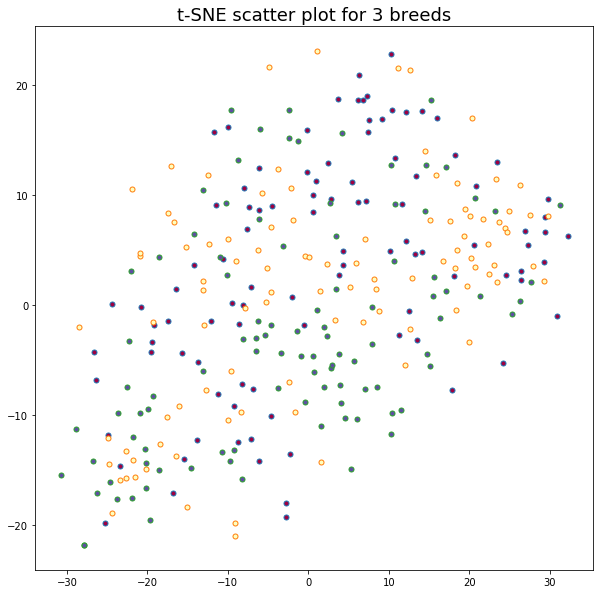

In [102]:
# Draw plots of t-SNE with various perplexities
from sklearn.preprocessing import scale
from sklearn import manifold

train_centroids, train_clusters = kmeans2(whiten(train_descriptors_list), n_clusters)
train_histos_scaled = scale(build_histograms(train_descriptors_number, train_descriptors_list, train_centroids))
tsne = manifold.TSNE(n_components=2, perplexity=10, n_iter=5000, init='pca')
df_tsne = tsne.fit_transform(train_histos_scaled)

# plt.scatter(df_tsne[:,0],df_tsne[:,1])
# plt.show()

# Get colors plot accordding on the k-means clustering
labels = sample_train_df['label']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_tsne[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=5)

plt.title('t-SNE scatter plot for {0} breeds'.format(nb_breeds), fontsize=18)
plt.show()

In [118]:
len(train_histos_scaled)

300

In [122]:
for cluster_nb in np.logspace(0.5, 3, 10):
    eval_score(int(cluster_nb))

Score for 3 clusters : 17.08%
Score for 5 clusters : 20.57%
Score for 11 clusters : 22.63%
Score for 21 clusters : 26.44%
Score for 40 clusters : 28.29%
Score for 77 clusters : 29.60%
Score for 146 clusters : 29.27%
Score for 278 clusters : 30.58%
Score for 527 clusters : 28.07%
Score for 1000 clusters : 25.35%
